In [1]:
# data management
import numpy as np                   # for linear algebra
import pandas as pd                  # for tabular data manipulation and processing
import category_encoders             # for categorical encoding

# machine learning
import sklearn                       # for data prep and classical ML

# data visualization and graphics
import matplotlib.pyplot as plt      # for visualization fundamentals
import seaborn as sns                # for pretty visualizations
sns.set_palette("magma")

# misc
import math                          # for calculation
import sys                           # for system manipulation
import os                            # for file manipulation

# stats
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.proportion import proportion_confint

In [2]:
# Load Dataset

file_path = "/Users/Sebastiano/data/Clinical_MRI.xlsx"
db = pd.read_excel(file_path)
pd.set_option('display.max_columns', None)

print("N° of patients: {}".format(len(db)))
print("N° of columns: {}".format(db.shape[1]))
db.head()

N° of patients: 27
N° of columns: 969


Patient  Date of Birth  Gender    Education  Disease duration (months)  \
0  Paziente 1          30084       0  High School                      109.5   
1  Paziente 2          26505       0   University                       96.0   
2  Paziente 3          31954       0   University                       76.5   
3  Paziente 4          32438       0   University                       79.1   
4  Paziente 5          28445       0  high school                       42.0   

     Age  SLEDAI-2k (at the time of NP event)  PGA (at the time of fMRI)  \
0  38.00                                    0                        0.0   
1  41.17                                   13                        2.1   
2  32.00                                    2                        0.5   
3  31.00                                    2                        0.0   
4  43.00                                    2                        0.4   

   SLICC-DI (at the time of NP event)  \
0                                   1   
1                                   0   
2                                   0   
3                                   1   
4                                   0   

   anti-dsDNA Titre  (0=absent; 1=present) )  \
0                                          1   
1                                          1   
2                                          1   
3                                          1   
4                                          1   

   anti-dsDNA Titre  (insert NV here <7 )  Anti-Ro-SSA  Anti-La-SSB  Anti-RNP  \
0                                     3.0            0            0         0   
1                                    84.4            1            0         0   
2                                     4.0            1            0         0   
3                                     5.0            0            0         0   
4                                    37.2            1            0         0   

   anti-Sm  C3 (mgdl)  C4 (mgdl)  aPL syndrome  LAC  aCL IgG  aCL IgM  \
0        0         89         20             0    0        0        0   
1        0         64         15             0    0        0        0   
2        0         97         17             0    0        1        1   
3        0         84         14             0    0        1        0   
4        0        101         11             0    1        0        0   

   aB2GPI IgG  aB2GPI IgM  aPL+  No Treatment Antiplatelet Anticoagulant  \
0           0           0     0             0         None          None   
1           0           0     0             0         None          None   
2           0           0     1             0         None          None   
3           0           0     1             0         None          None   
4           0           0     1             0          yes          None   

   Prednisone  (mg equivalent)        Antimalarial Immunosuppressant  \
0                          2.5                None      Methotrexate   
1                          7.5  Hydroxychloroquine      Methotrexate   
2                          5.4  Hydroxychloroquine      Azathioprine   
3                          3.6  Hydroxychloroquine      Methotrexate   
4                          4.0  hydroxychloroquine      Methotrexate   

      Biologic  AnAb   Anti-Rib-P  Anti-DWEYS  NP-SLE  \
0         None      1           1           1       1   
1    Rituximab      1           1           0       0   
2    Belimumab      1           0           0       0   
3  tocilizumab      0           0           0       1   
4    Rituximab      0           0           1       0   

                             Event  Livedo reticularis  Cutaneous vasculitis  \
0  Mood abnormalities (depressive)                   0                     0   
1                              NaN                   0                     0   
2                              NaN                   0                     1   
3                          Seizure                   

In [3]:
# Drop unwanted columns

df = db.drop(['Patient','Date of Birth', 'Gender', 'Education', 'Age'], axis = 'columns')
# drop columns that include "%" in their name
#cols_to_drop = [col for col in df.columns if "%" in col]
#df = df.drop(columns=cols_to_drop)
print("Effective features to consider: {} ".format(len(df.columns)-1))

Effective features to consider: 963 


In [4]:
# One Hot Encoding for Scores, Antiplatelets and Coagulants, Therapy, NP Event

from sklearn.preprocessing import OneHotEncoder

categ = ['Antiplatelet', 'Anticoagulant', 'Antimalarial', 'Immunosuppressant', 'Biologic', 'Event']
ohe = OneHotEncoder(categories='auto',sparse=False)
df_enc = ohe.fit_transform(df[categ])
df_enc = pd.DataFrame(df_enc,columns=ohe.get_feature_names_out(categ))
df = pd.concat([df, df_enc], axis=1)
df = df.drop(categ, axis=1)
df.tail()

/opt/homebrew/Caskroom/miniforge/base/envs/lupus/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Disease duration (months)  SLEDAI-2k (at the time of NP event)  \
22                      30.20                                   14   
23                      21.80                                    6   
24                     243.30                                   21   
25                     159.13                                    2   
26                      45.10                                    2   

    PGA (at the time of fMRI)  SLICC-DI (at the time of NP event)  \
22                        1.6                                   1   
23                        1.0                                   0   
24                        2.6                                   4   
25                        1.7                                   0   
26                        0.0                                   0   

    anti-dsDNA Titre  (0=absent; 1=present) )  \
22                                          0   
23                                          1   
24                                          1   
25                                          1   
26                                          1   

    anti-dsDNA Titre  (insert NV here <7 )  Anti-Ro-SSA  Anti-La-SSB  \
22                                     4.0            1            1   
23                                    41.2            0            0   
24                                     1.9            0            0   
25                                     2.0            0            0   
26                                     2.6            0            0   

    Anti-RNP  anti-Sm  C3 (mgdl)  C4 (mgdl)  aPL syndrome  LAC  aCL IgG  \
22         0        1         78         13             0    1        0   
23         0        0         96         17             0    0        0   
24         0        0         62         11             1    1        1   
25         1        0         97          8             0    1        1   
26         0        0         85         19             0    1        0   

    aCL IgM  aB2GPI IgG  aB2GPI IgM  aPL+  No Treatment  \
22        1           0           1     1             0   
23        0           0           0     0             0   
24        0           1           0     1             0   
25        0           1           0     1             0   
26        0           0           0     1             0   

    Prednisone  (mg equivalent)  AnAb   Anti-Rib-P  Anti-DWEYS  NP-SLE  \
22                         10.1      0           0           1       1   
23                         15.0      1           1           0       1   
24                         14.3      1           0           0       1   
25                          5.0      1           0           1       0   
26                          0.0      0           0           0       0   

    Livedo reticularis  Cutaneous vasculitis  Hypertension  Hyperlipidaemia  \
22                   0                     1             1                1   
23                   0                     0             0                0   
24                   0                     0             0                0   
25                   0                     0             0                0   
26                   0                     0             0                0   

    current Smoking  ever smoking  Scale factor       SNR  \
22                0             0       0.62973   43.8559   
23                1             1       0.73500   47.0085   
24                1             1       0.75214   45.3995   
25                0             0       0.57994  102.2972   
26                0             0       0.82252   38.7983   

    White Matter (WM) volume cm3  White Matter (WM) volume %  \
22                      393.3745                     34.4270   
23                      495.4935                     37.0849   
24                      457.9349                     34.1854   
25                      415.1286                     39.2274   
26                      550

# Partial Correlations

## NP-SLE

Event_CVA vs Abnormal Appearing White Matter volume cm3: r = 0.38, p = 0.05
Event_CVA vs Abnormal Appearing White Matter volume cm3 (partial corr): r = 0.56, p = 0.00
total_neurocog vs Abnormal Appearing White Matter volume cm3: r = 0.16, p = 0.43
NP-SLE vs Abnormal Appearing White Matter volume cm3 (partial corr): r = 0.30, p = 0.15


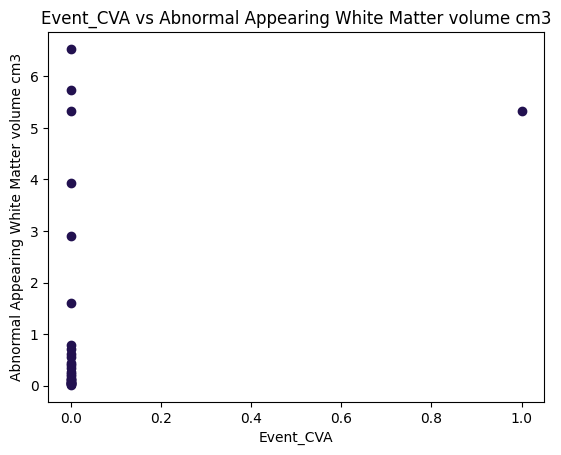

<Figure size 640x480 with 0 Axes>

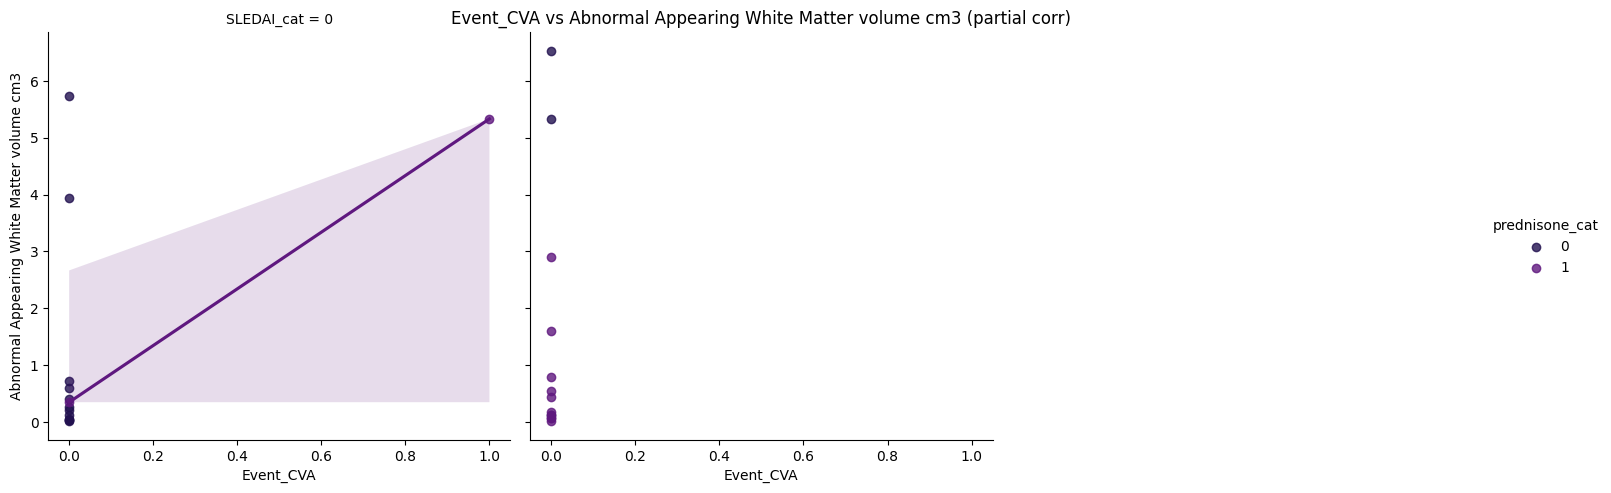

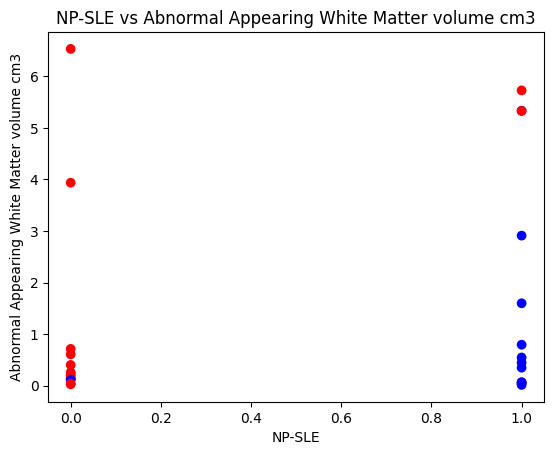

<Figure size 640x480 with 0 Axes>

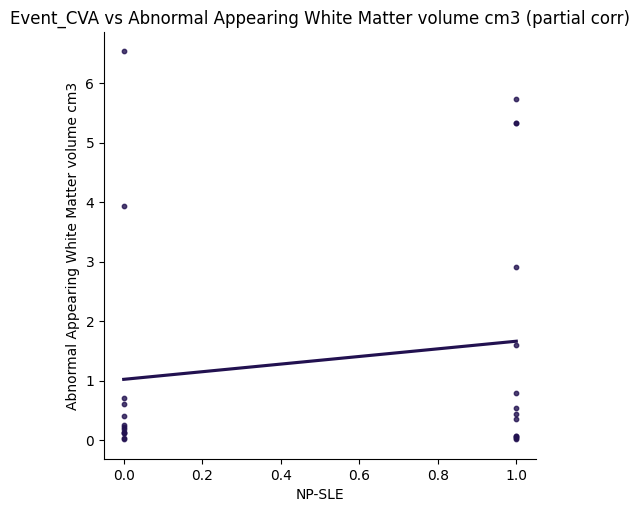

Event_Mood abnormalities (depressive) vs Abnormal Appearing White Matter volume cm3: r = -0.25, p = 0.21
Event_Mood abnormalities (depressive) vs Abnormal Appearing White Matter volume cm3 (partial corr): r = -0.24, p = 0.24
total_neurocog vs Abnormal Appearing White Matter volume cm3: r = 0.16, p = 0.43
NP-SLE vs Abnormal Appearing White Matter volume cm3 (partial corr): r = 0.30, p = 0.15


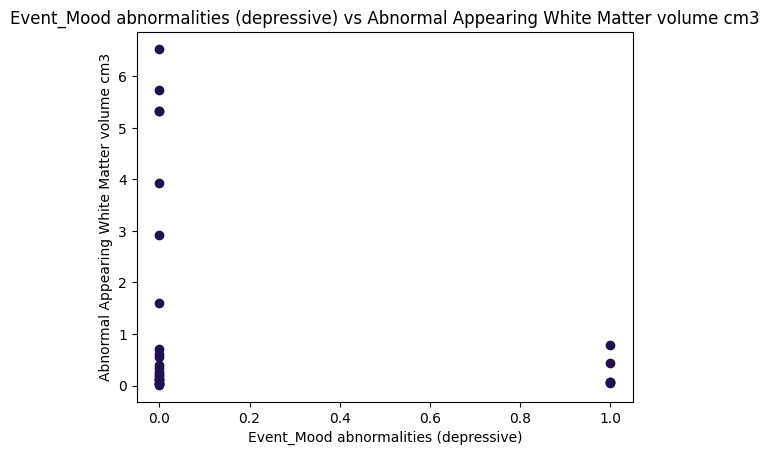

<Figure size 640x480 with 0 Axes>

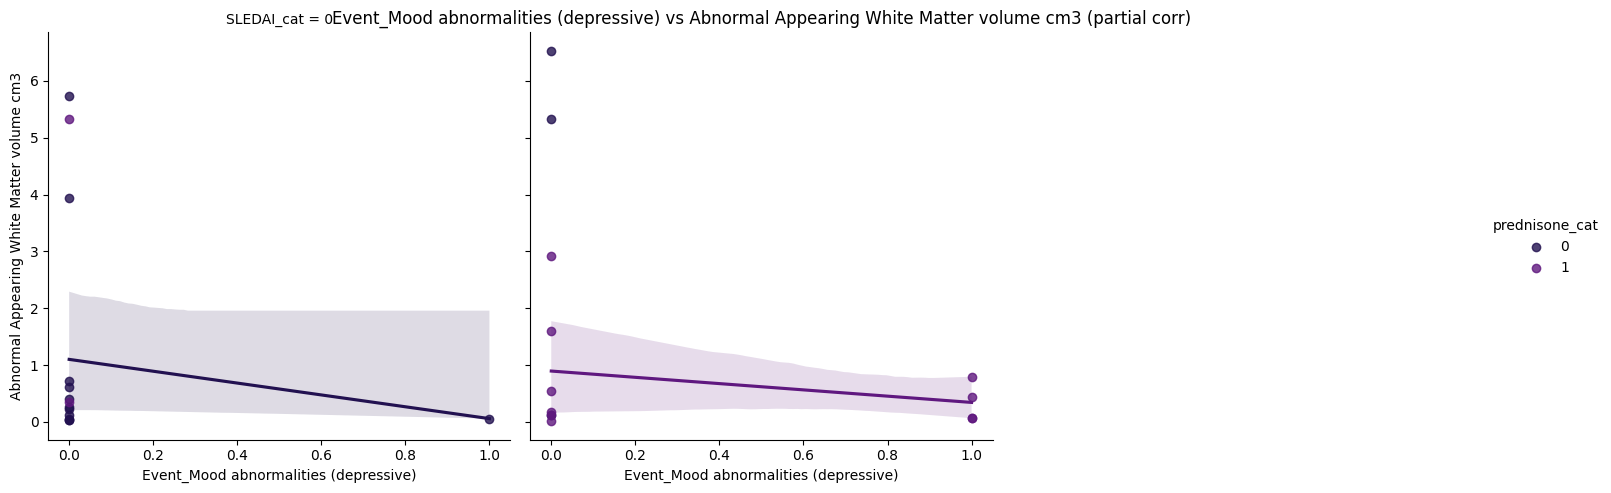

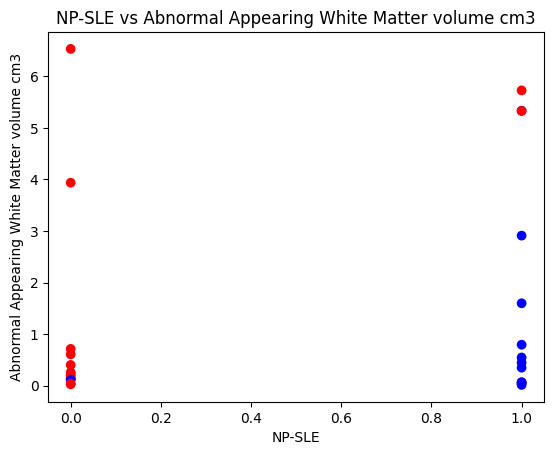

<Figure size 640x480 with 0 Axes>

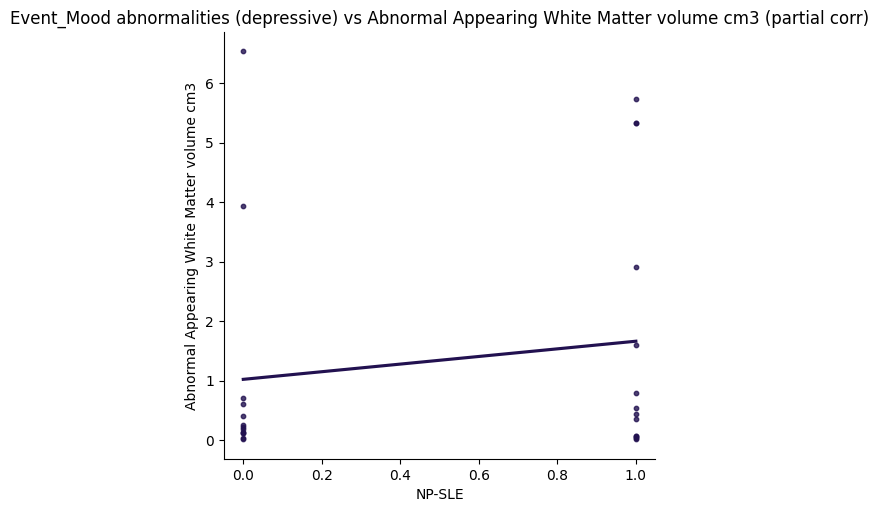

Event_Mood abnormalities (mixed) vs Abnormal Appearing White Matter volume cm3: r = -0.13, p = 0.52
Event_Mood abnormalities (mixed) vs Abnormal Appearing White Matter volume cm3 (partial corr): r = -0.12, p = 0.57
total_neurocog vs Abnormal Appearing White Matter volume cm3: r = 0.16, p = 0.43
NP-SLE vs Abnormal Appearing White Matter volume cm3 (partial corr): r = 0.30, p = 0.15


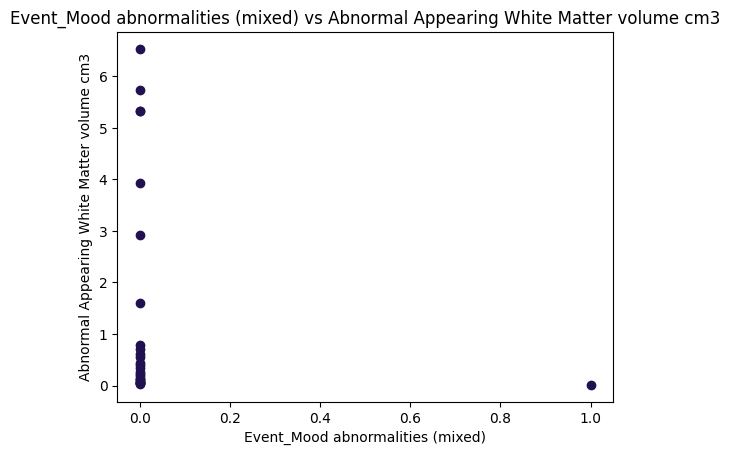

<Figure size 640x480 with 0 Axes>

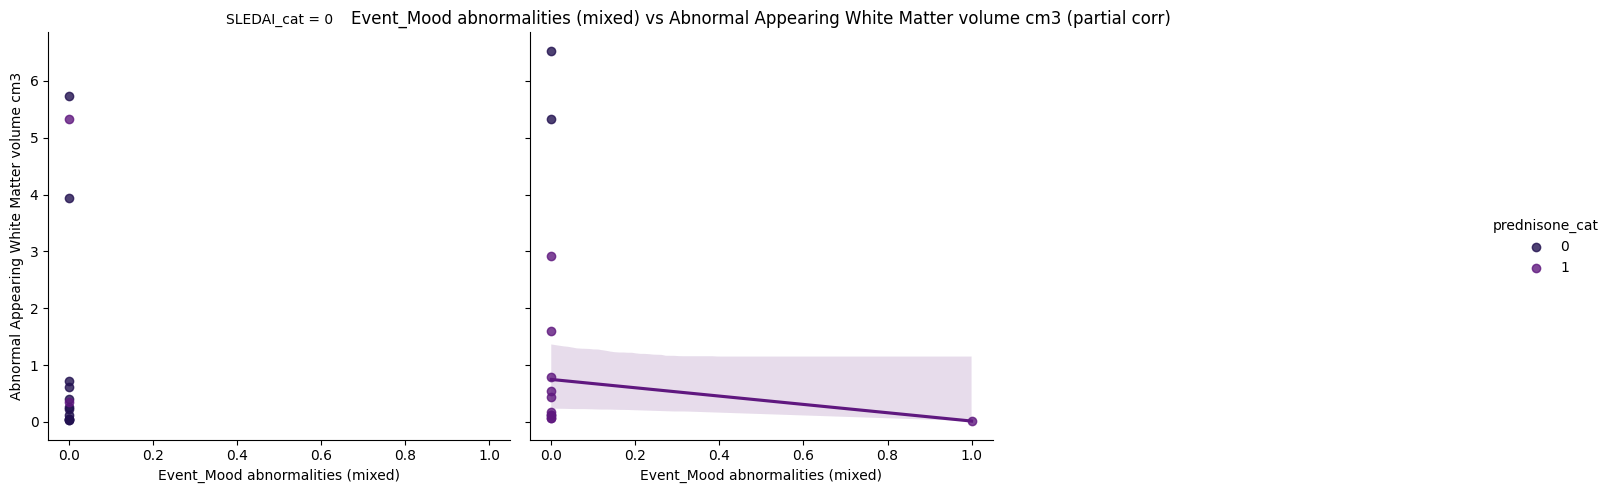

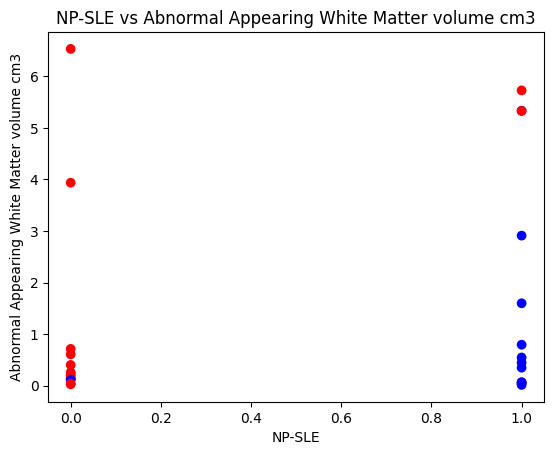

<Figure size 640x480 with 0 Axes>

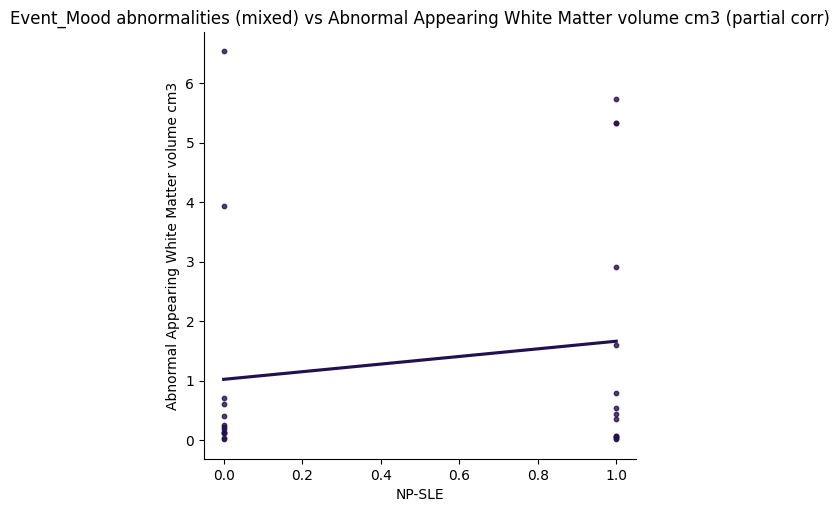

Event_Movement Disorder vs Abnormal Appearing White Matter volume cm3: r = -0.08, p = 0.70
Event_Movement Disorder vs Abnormal Appearing White Matter volume cm3 (partial corr): r = -0.06, p = 0.76
total_neurocog vs Abnormal Appearing White Matter volume cm3: r = 0.16, p = 0.43
NP-SLE vs Abnormal Appearing White Matter volume cm3 (partial corr): r = 0.30, p = 0.15


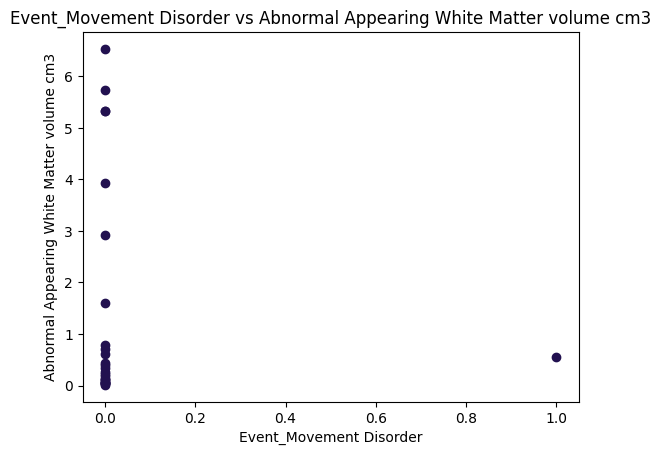

<Figure size 640x480 with 0 Axes>

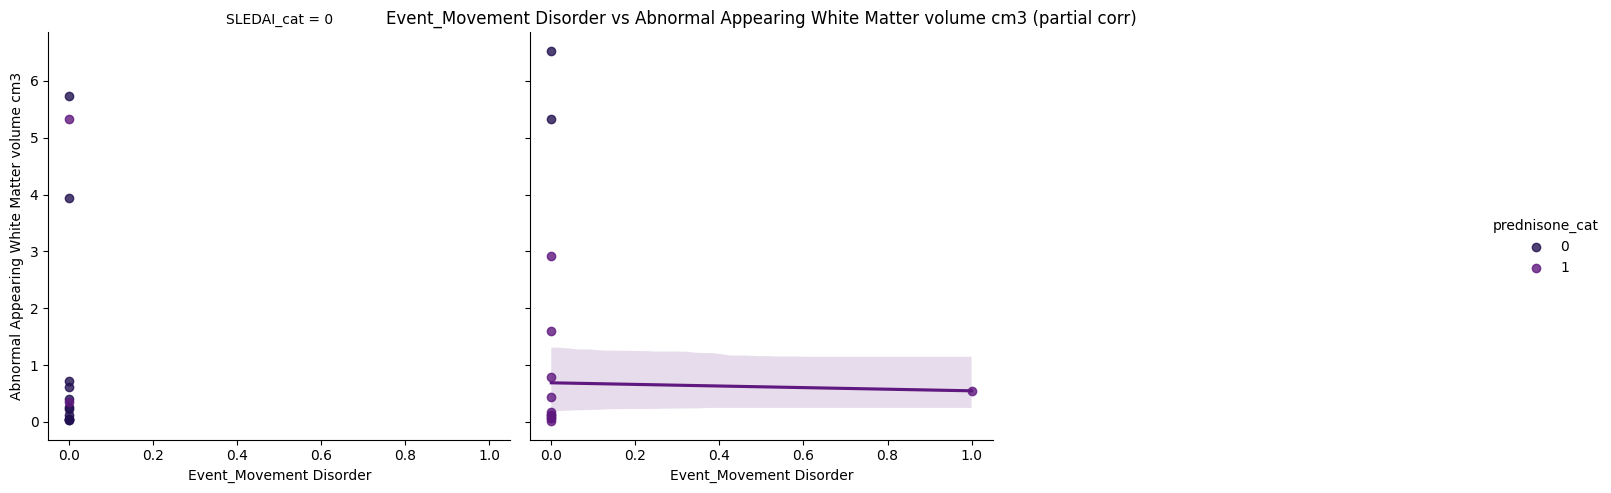

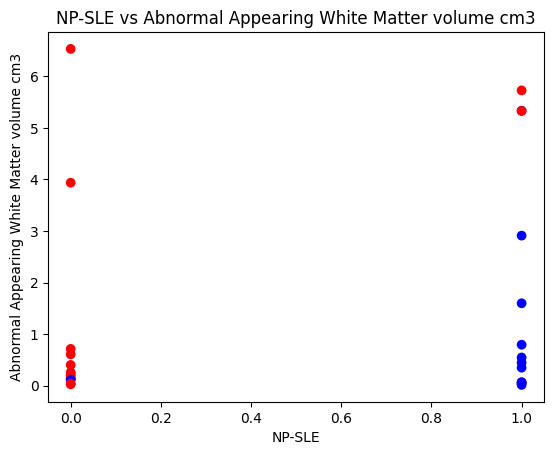

<Figure size 640x480 with 0 Axes>

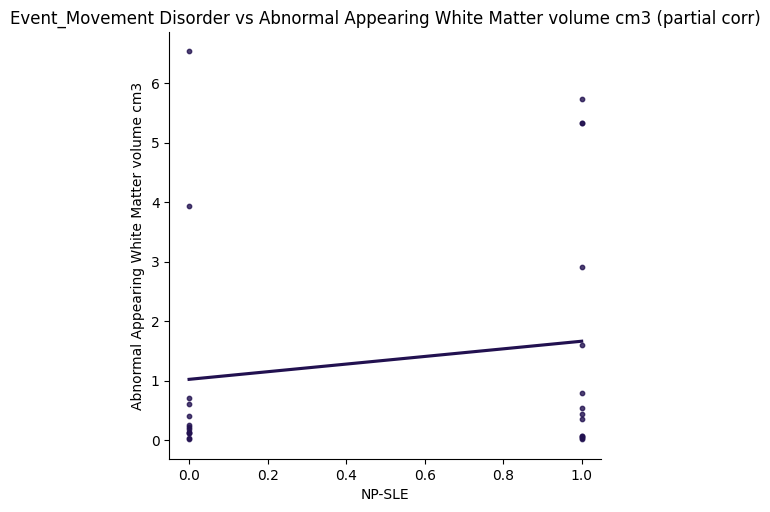

Event_Psychosis vs Abnormal Appearing White Matter volume cm3: r = -0.05, p = 0.79
Event_Psychosis vs Abnormal Appearing White Matter volume cm3 (partial corr): r = 0.04, p = 0.87
total_neurocog vs Abnormal Appearing White Matter volume cm3: r = 0.16, p = 0.43
NP-SLE vs Abnormal Appearing White Matter volume cm3 (partial corr): r = 0.30, p = 0.15


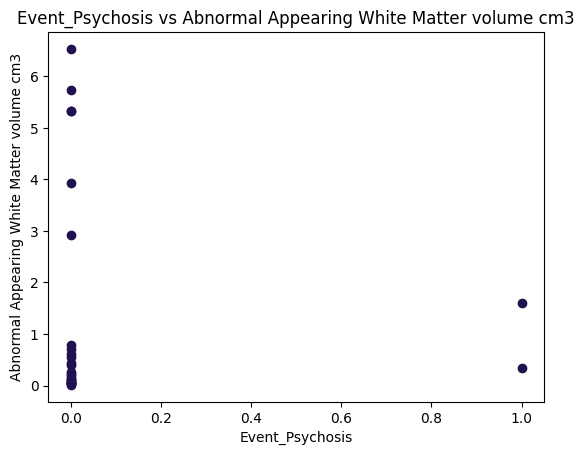

<Figure size 640x480 with 0 Axes>

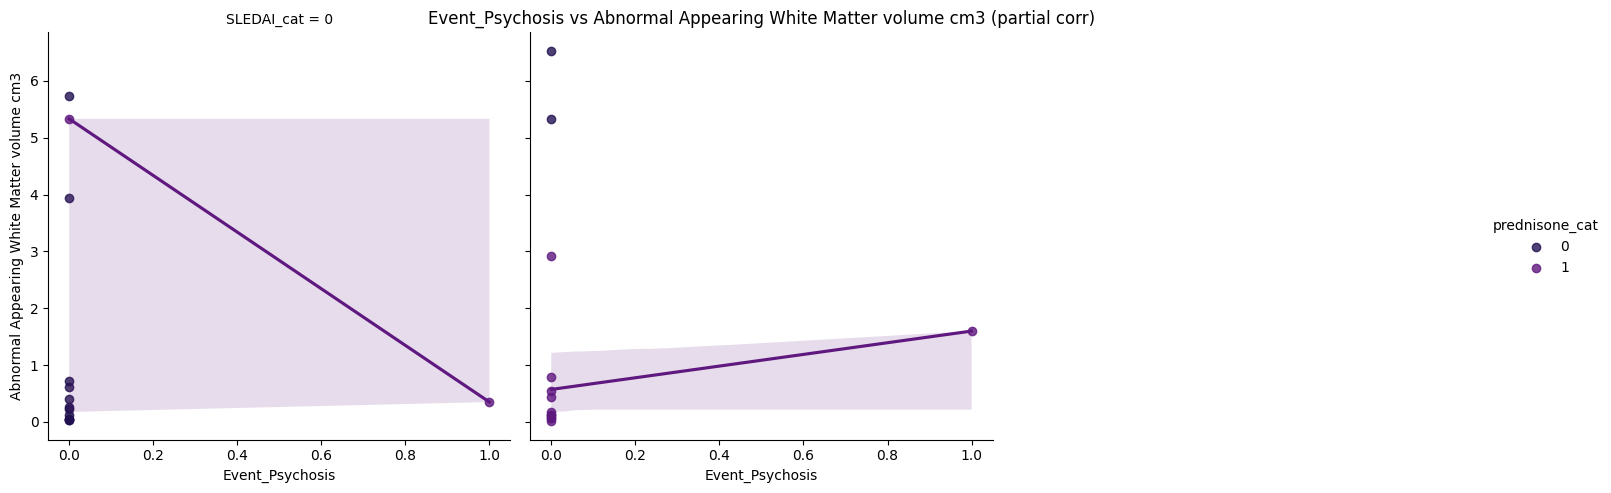

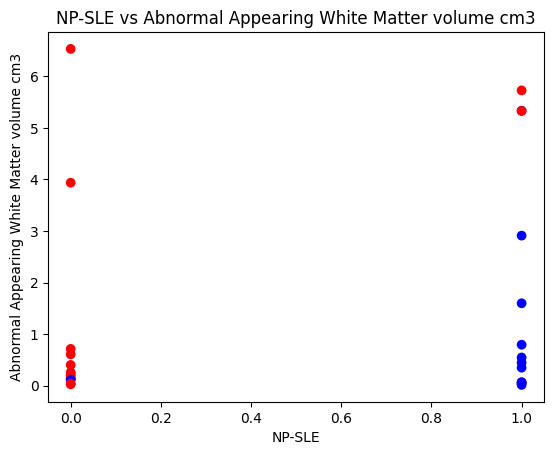

<Figure size 640x480 with 0 Axes>

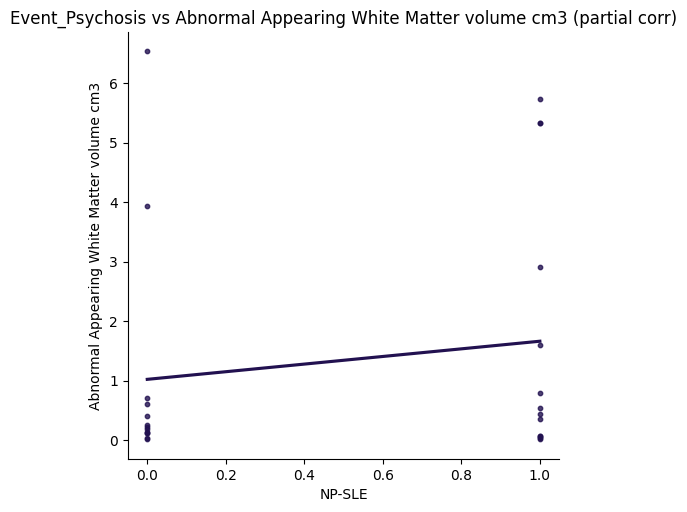

Event_Seizure vs Abnormal Appearing White Matter volume cm3: r = 0.27, p = 0.18
Event_Seizure vs Abnormal Appearing White Matter volume cm3 (partial corr): r = 0.28, p = 0.18
total_neurocog vs Abnormal Appearing White Matter volume cm3: r = 0.16, p = 0.43
NP-SLE vs Abnormal Appearing White Matter volume cm3 (partial corr): r = 0.30, p = 0.15


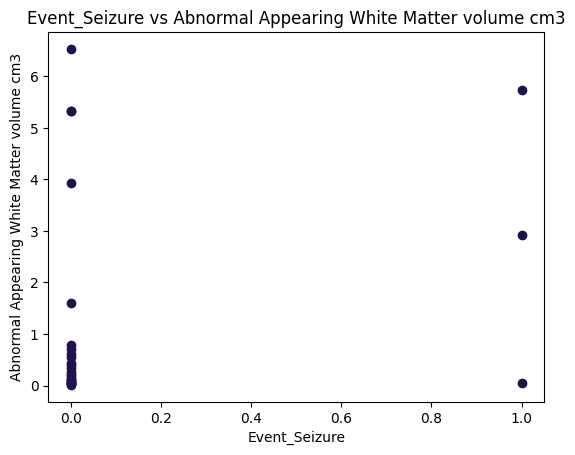

<Figure size 640x480 with 0 Axes>

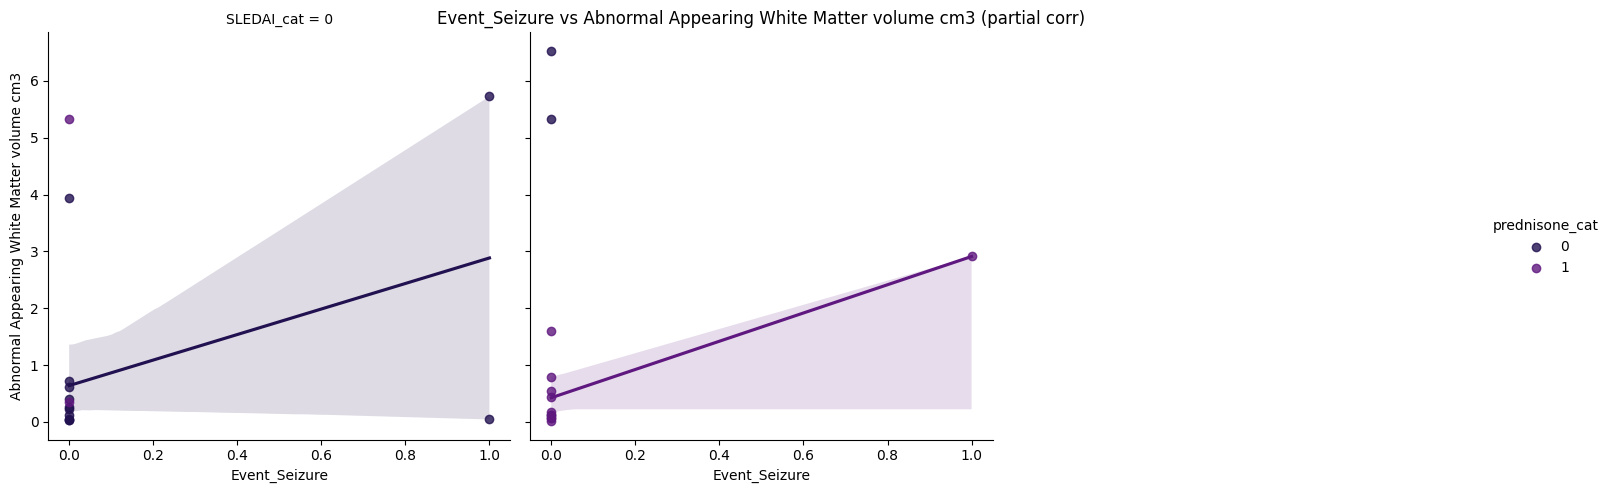

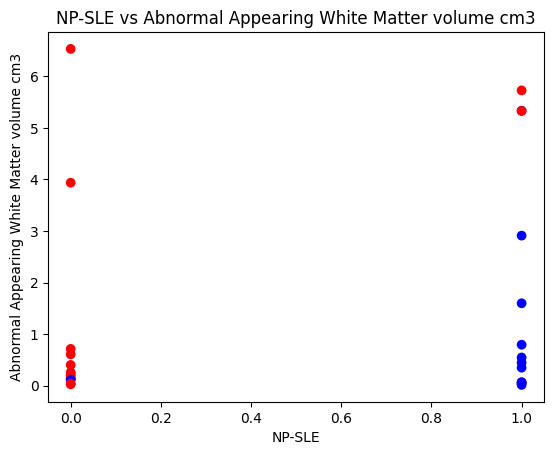

<Figure size 640x480 with 0 Axes>

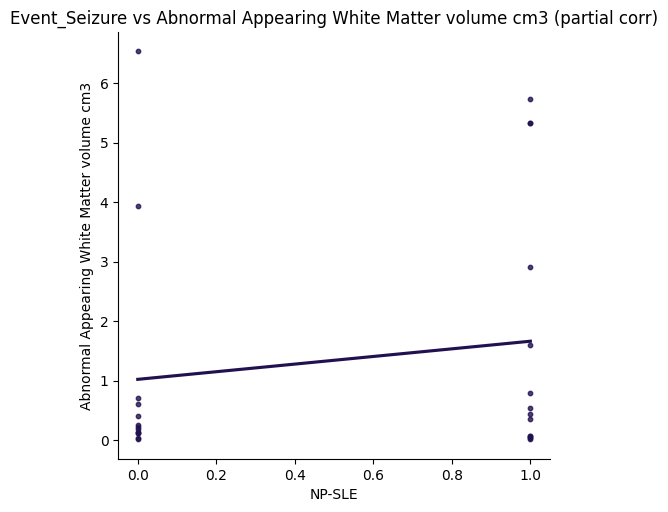

Event_Seizure, ACS, myelitis, CVA vs Abnormal Appearing White Matter volume cm3: r = 0.38, p = 0.05
Event_Seizure, ACS, myelitis, CVA vs Abnormal Appearing White Matter volume cm3 (partial corr): r = 0.33, p = 0.10
total_neurocog vs Abnormal Appearing White Matter volume cm3: r = 0.16, p = 0.43
NP-SLE vs Abnormal Appearing White Matter volume cm3 (partial corr): r = 0.30, p = 0.15


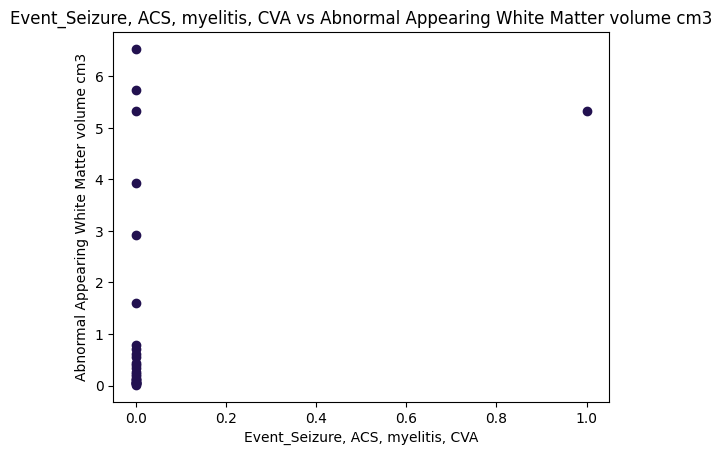

<Figure size 640x480 with 0 Axes>

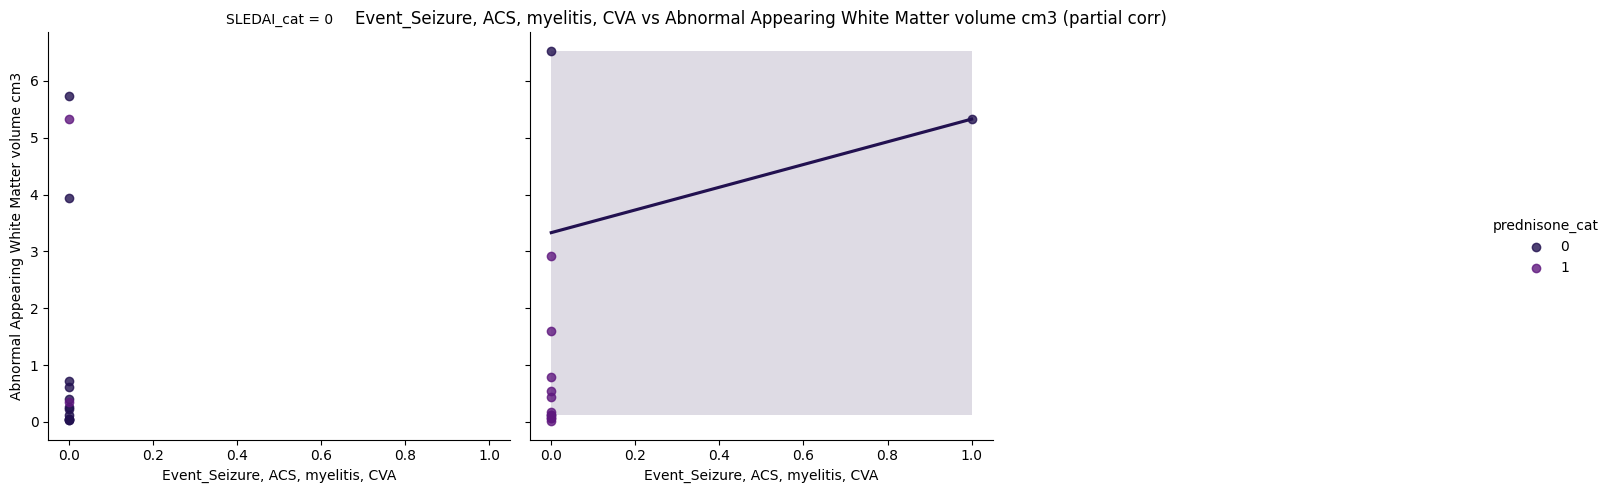

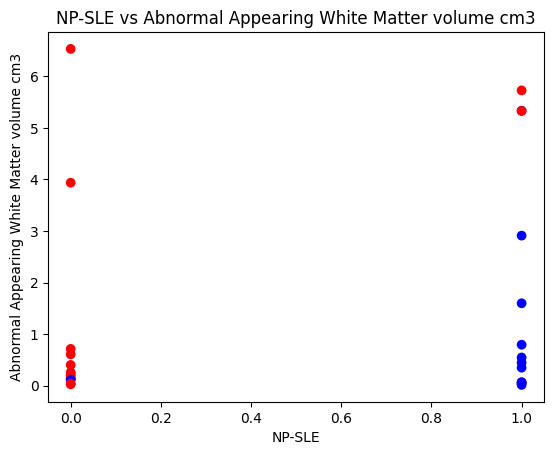

<Figure size 640x480 with 0 Axes>

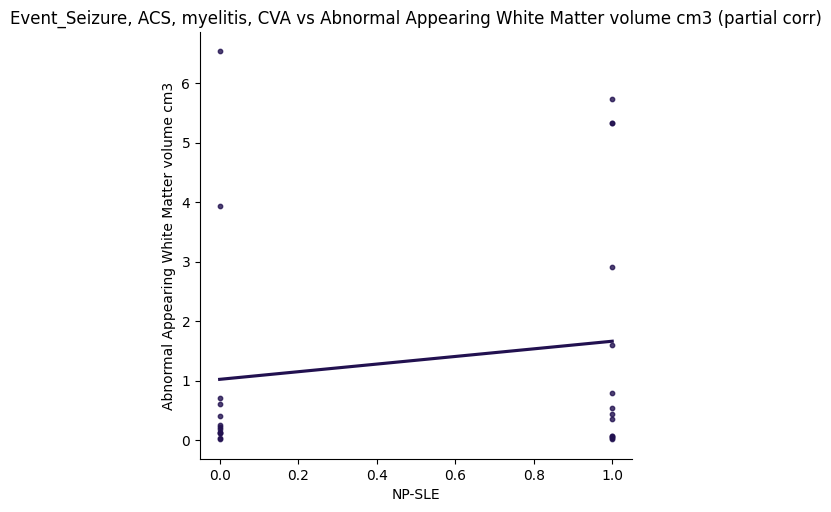

Abnormal Appearing White Matter volume cm3 vs Abnormal Appearing White Matter volume cm3: r = 1.00, p = 0.00
total_neurocog vs Abnormal Appearing White Matter volume cm3: r = 0.16, p = 0.43
NP-SLE vs Abnormal Appearing White Matter volume cm3 (partial corr): r = 0.30, p = 0.15


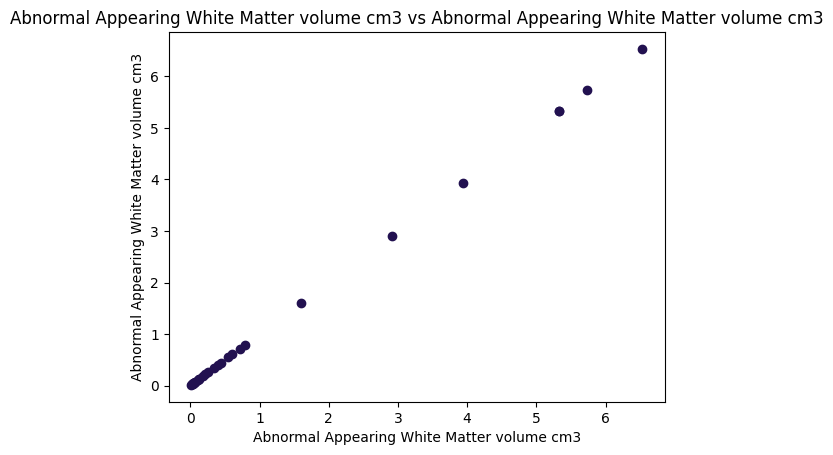

<Figure size 640x480 with 0 Axes>

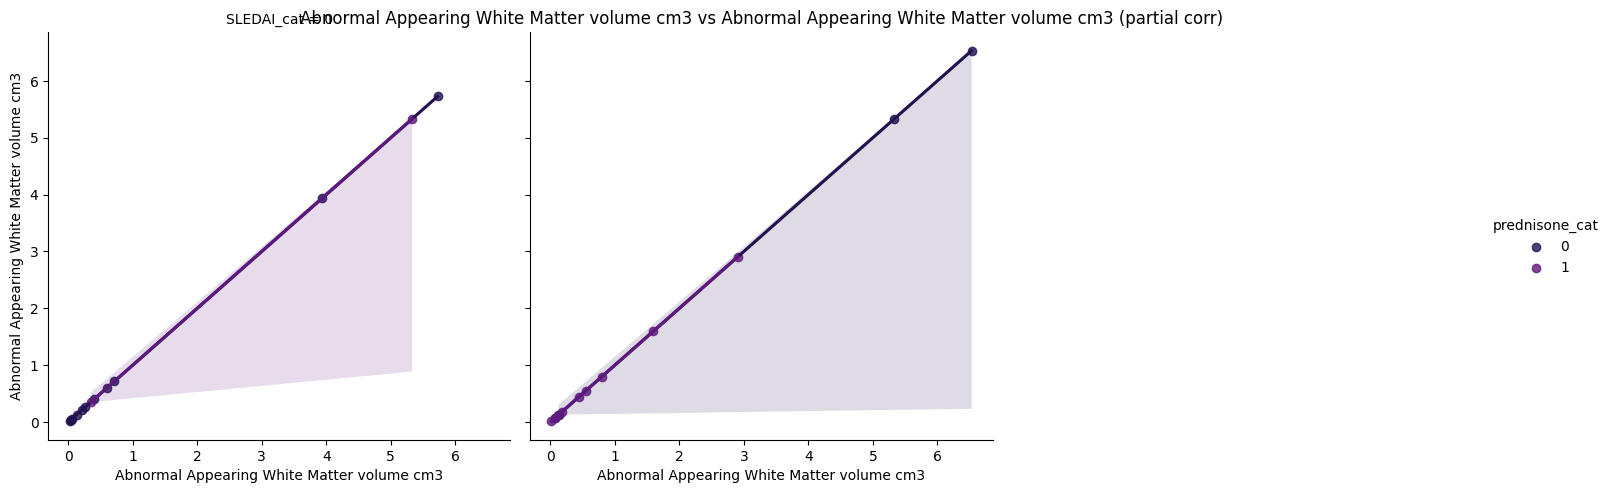

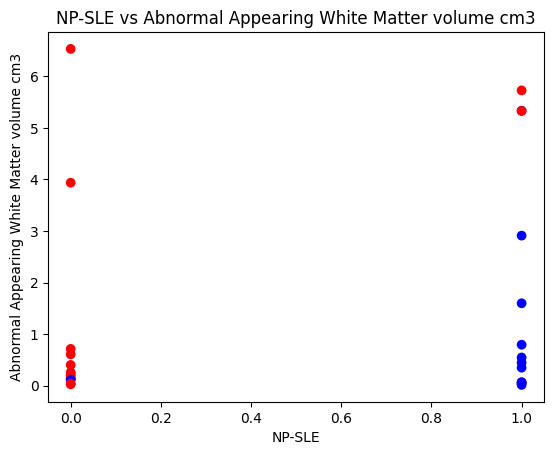

<Figure size 640x480 with 0 Axes>

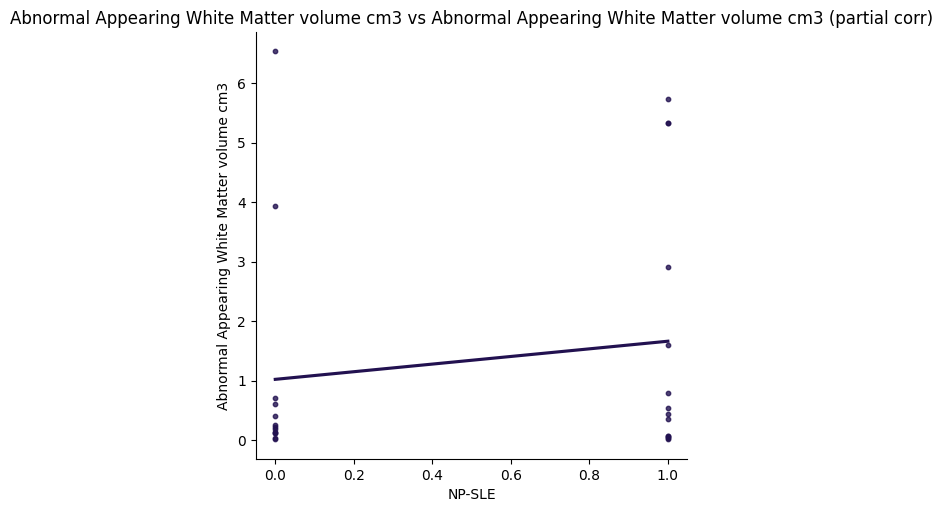

In [6]:
from scipy.stats import pearsonr
import pingouin as pg

df['SLEDAI_cat'] = np.where(df['SLEDAI-2k (at the time of NP event)'] > df['SLEDAI-2k (at the time of NP event)'].median(), 1, 0)
df['prednisone_cat'] = np.where(df['Prednisone  (mg equivalent)'] > df['Prednisone  (mg equivalent)'].median(), 1, 0)
# Define the variables
neurocog_cols = ['Event_CVA', 'Event_Mood abnormalities (depressive)', 'Event_Mood abnormalities (mixed)', 'Event_Movement Disorder', 'Event_Psychosis','Event_Seizure','Event_Seizure, ACS, myelitis, CVA']
lesion_load = 'Abnormal Appearing White Matter volume cm3'
prednisone = 'prednisone_cat'
sledai = 'SLEDAI_cat'

# Compute the correlations
for col in neurocog_cols + [lesion_load]:
    # Compute the Pearson correlation between each neurocognitive domain and lesion load
    r, p = pearsonr(df[col], df[lesion_load])
    print(f'{col} vs {lesion_load}: r = {r:.2f}, p = {p:.2f}')

    # Compute the partial correlation adjusting for prednisone and SLEDAI
    if col != lesion_load:
        partial_corr_results = pg.partial_corr(data=df, x=col, y=lesion_load, covar=[prednisone, sledai])
        r_partial, p_partial = partial_corr_results['r'][0], partial_corr_results['p-val'][0]
        print(f'{col} vs {lesion_load} (partial corr): r = {r_partial:.2f}, p = {p_partial:.2f}')
        assert abs(r - r_partial) > 1e-10, f'{col} and {lesion_load} are perfectly correlated'

    # Compute the Pearson correlation between total neurocognitive score and lesion load
    r_total, p_total = pearsonr(df['NP-SLE'], df[lesion_load])
    print(f'total_neurocog vs {lesion_load}: r = {r_total:.2f}, p = {p_total:.2f}')

    # Compute the partial correlation adjusting for prednisone and SLEDAI
    total_partial_results = pg.partial_corr(data=df, x='NP-SLE', y=lesion_load, covar=[prednisone, sledai])
    r_total_partial, p_total_partial = total_partial_results['r'][0], total_partial_results['p-val'][0]
    print(f'NP-SLE vs {lesion_load} (partial corr): r = {r_total_partial:.2f}, p = {p_total_partial:.2f}')


    # Plot the scatter plot
    plt.figure()
    plt.scatter(df[col], df[lesion_load])
    plt.xlabel(col)
    plt.ylabel(lesion_load)
    plt.title(f'{col} vs {lesion_load}')
    plt.show()

    # Plot the partial scatter plot
    plt.figure()
    sns.lmplot(data=df, x=col, y=lesion_load, hue=prednisone, col=sledai, col_wrap=3)
    plt.title(f'{col} vs {lesion_load} (partial corr)')
    plt.show()
    
    colors = ['red' if p == 0 else 'blue' for p in df[prednisone]]
    # Plot the scatter plot of total neurocognitive score vs lesion load
    plt.figure()
    plt.scatter(df['NP-SLE'], df[lesion_load], c=colors)
    plt.xlabel('NP-SLE')
    plt.ylabel(lesion_load)
    plt.title(f'NP-SLE vs {lesion_load}')
    plt.show()

    # Plot the partial scatter plot of total neurocognitive score vs lesion load
    plt.figure()
    sns.lmplot(data=df, x='NP-SLE', y=lesion_load, ci=None, scatter_kws={"s": 10})
    plt.title(f'{col} vs {lesion_load} (partial corr)')
    plt.show()

Event_CVA vs SCA thickness asymmetry: r = 0.62, p = 0.00
Event_CVA vs SCA thickness asymmetry (partial corr): r = 0.63, p = 0.00
total_neurocog vs SCA thickness asymmetry: r = 0.51, p = 0.01
NP-SLE vs SCA thickness asymmetry (partial corr): r = 0.34, p = 0.09


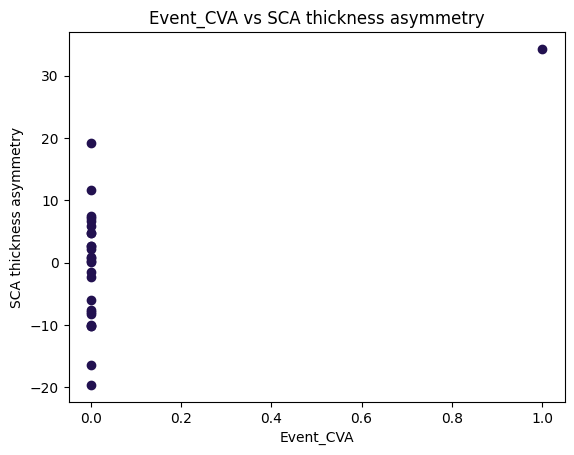

<Figure size 640x480 with 0 Axes>

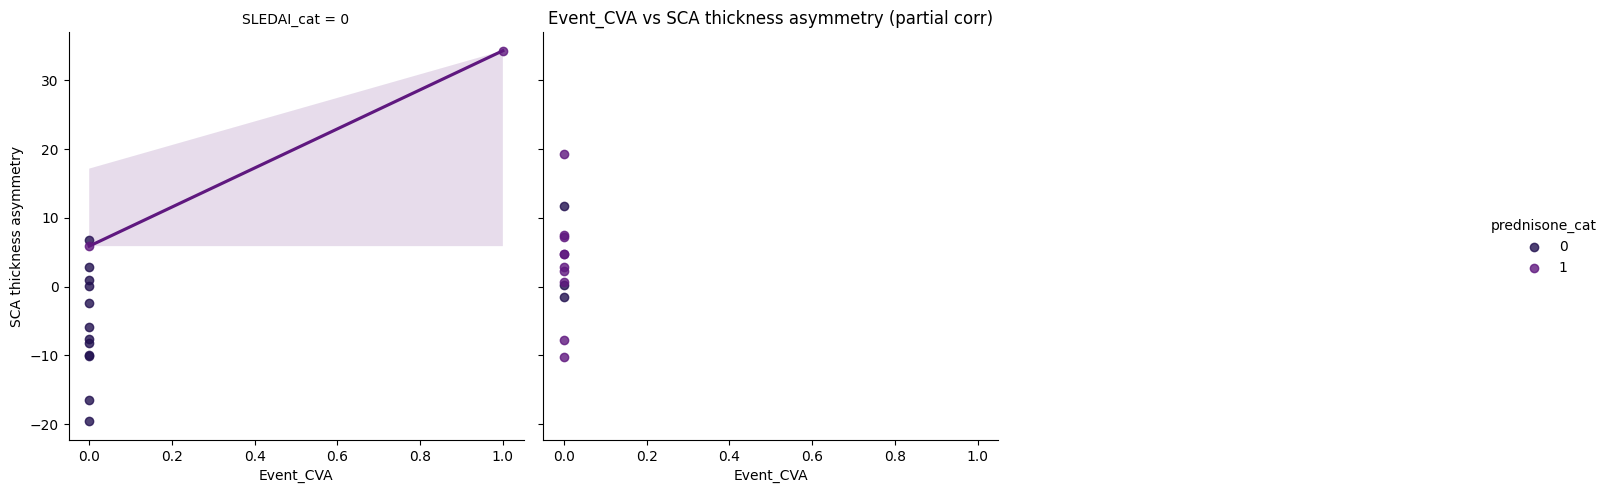

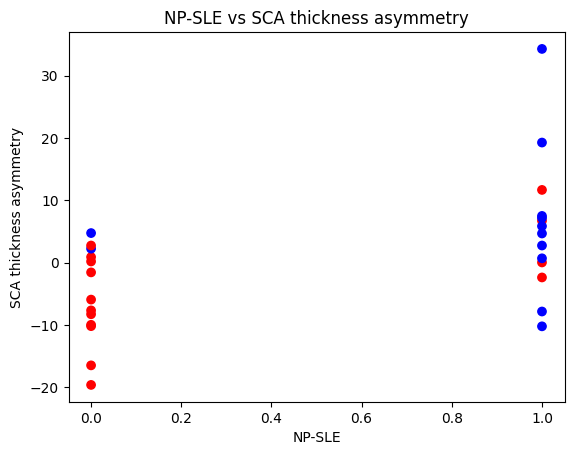

<Figure size 640x480 with 0 Axes>

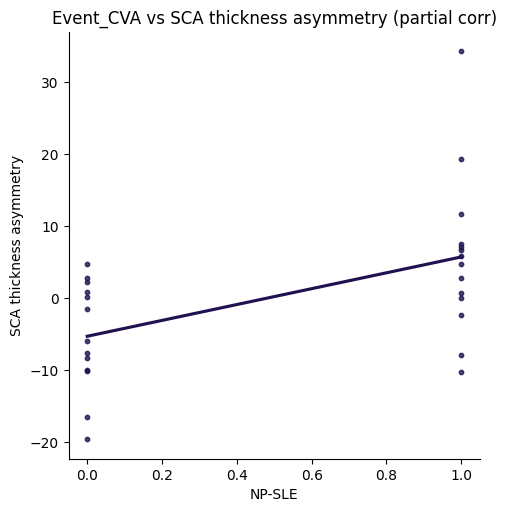

Event_Mood abnormalities (depressive) vs SCA thickness asymmetry: r = -0.01, p = 0.95
Event_Mood abnormalities (depressive) vs SCA thickness asymmetry (partial corr): r = -0.20, p = 0.35
total_neurocog vs SCA thickness asymmetry: r = 0.51, p = 0.01
NP-SLE vs SCA thickness asymmetry (partial corr): r = 0.34, p = 0.09


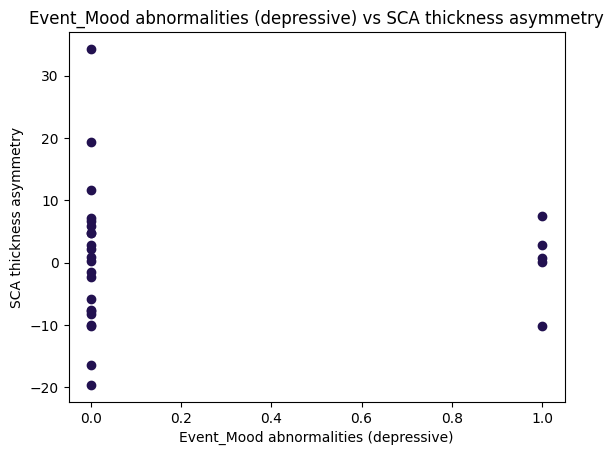

<Figure size 640x480 with 0 Axes>

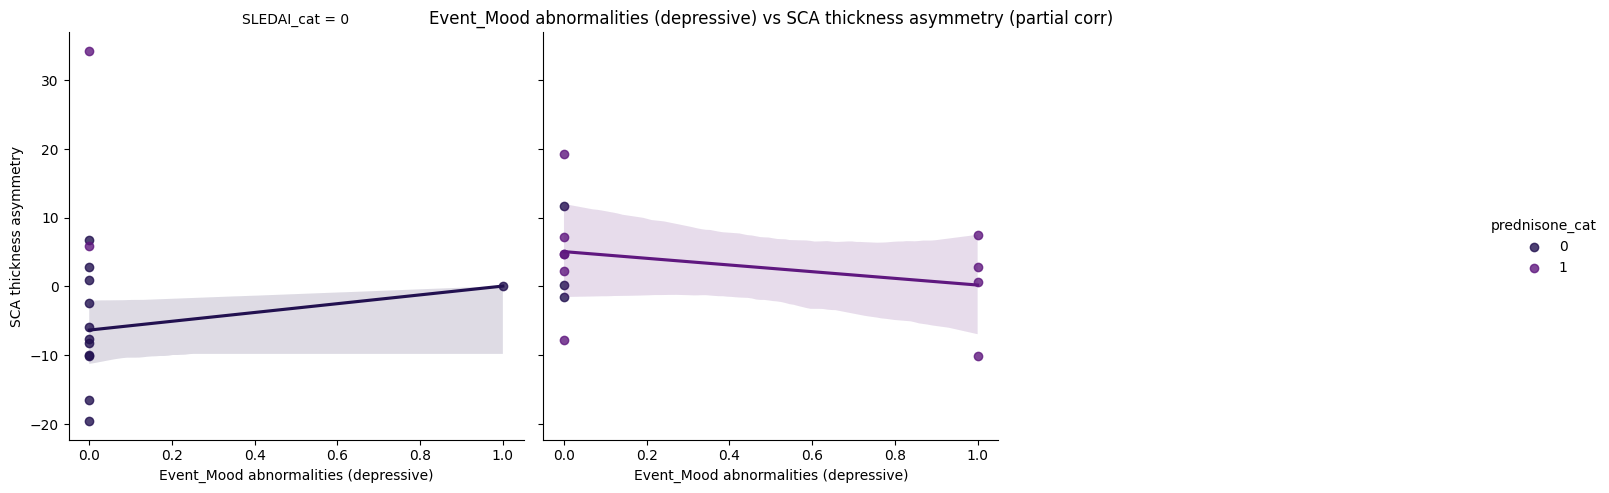

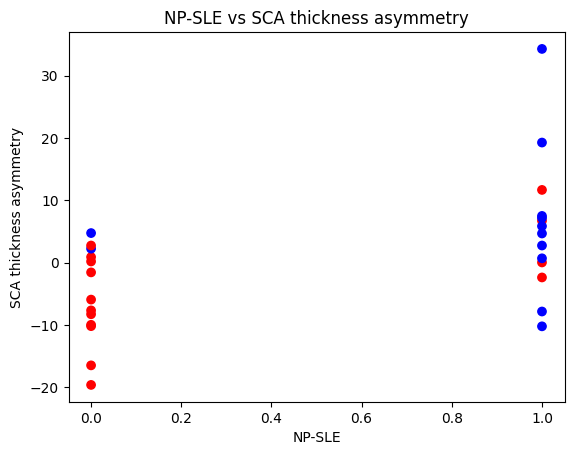

<Figure size 640x480 with 0 Axes>

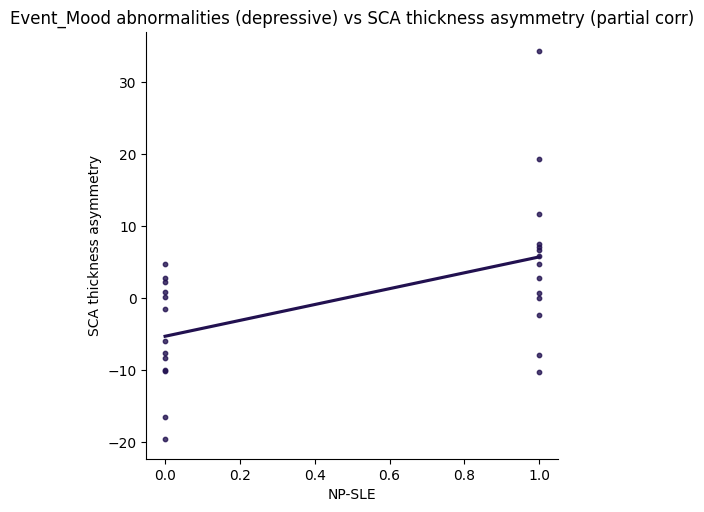

Event_Mood abnormalities (mixed) vs SCA thickness asymmetry: r = 0.08, p = 0.70
Event_Mood abnormalities (mixed) vs SCA thickness asymmetry (partial corr): r = -0.02, p = 0.92
total_neurocog vs SCA thickness asymmetry: r = 0.51, p = 0.01
NP-SLE vs SCA thickness asymmetry (partial corr): r = 0.34, p = 0.09


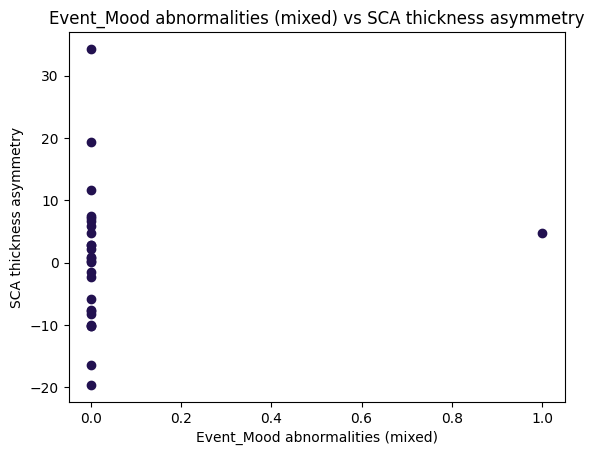

<Figure size 640x480 with 0 Axes>

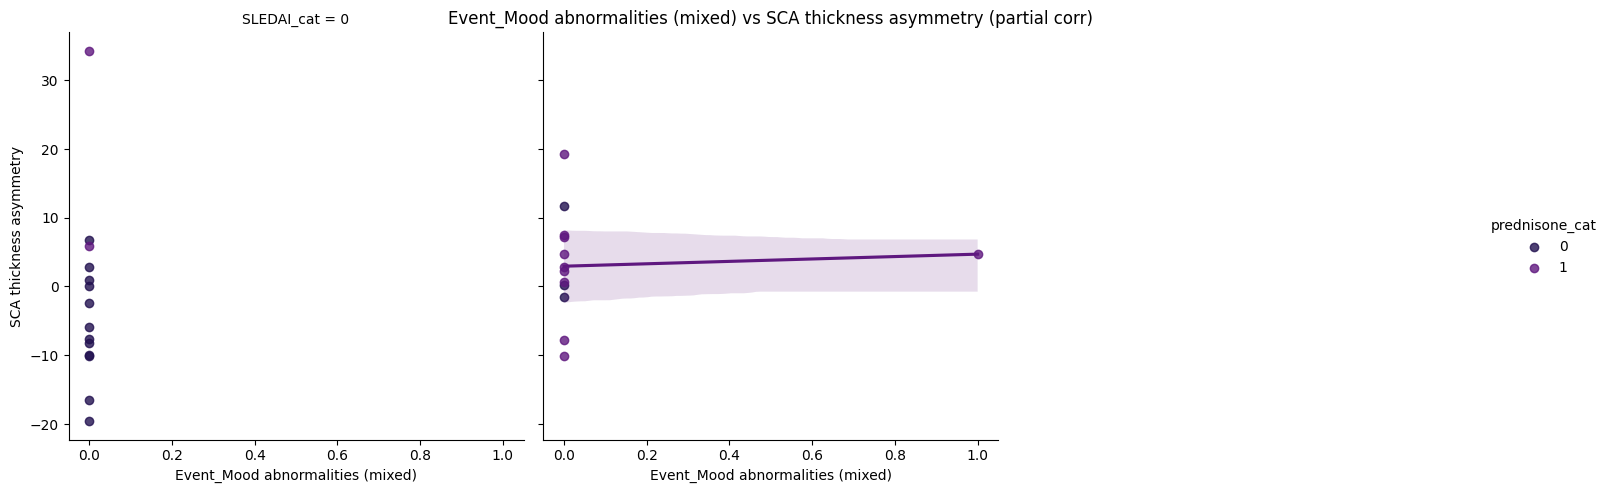

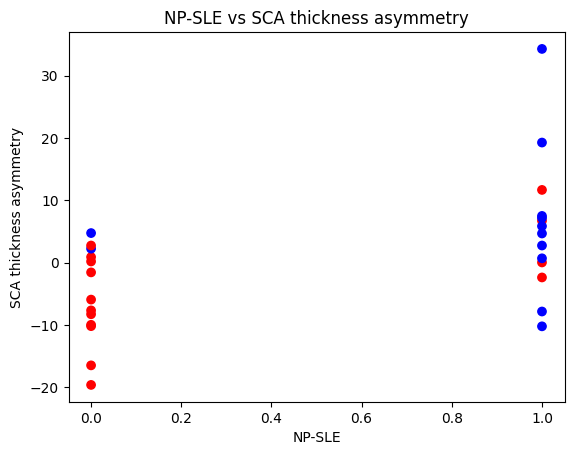

<Figure size 640x480 with 0 Axes>

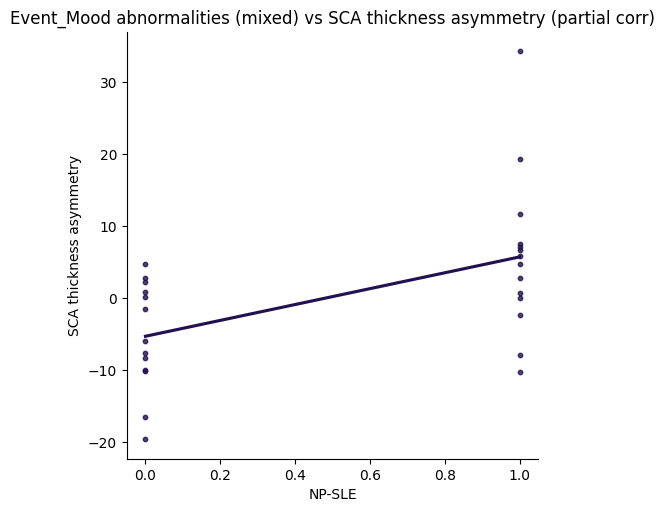

Event_Movement Disorder vs SCA thickness asymmetry: r = 0.12, p = 0.54
Event_Movement Disorder vs SCA thickness asymmetry (partial corr): r = 0.03, p = 0.88
total_neurocog vs SCA thickness asymmetry: r = 0.51, p = 0.01
NP-SLE vs SCA thickness asymmetry (partial corr): r = 0.34, p = 0.09


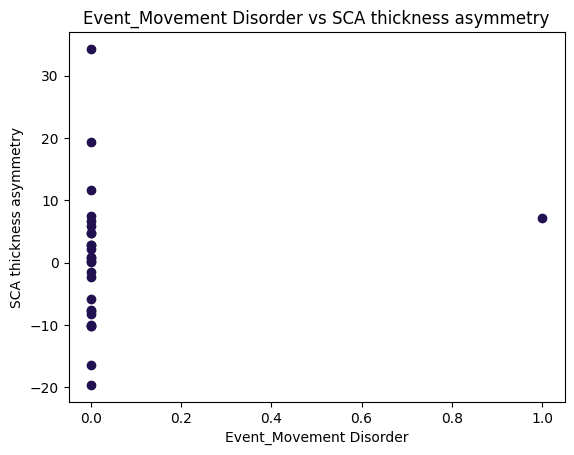

<Figure size 640x480 with 0 Axes>

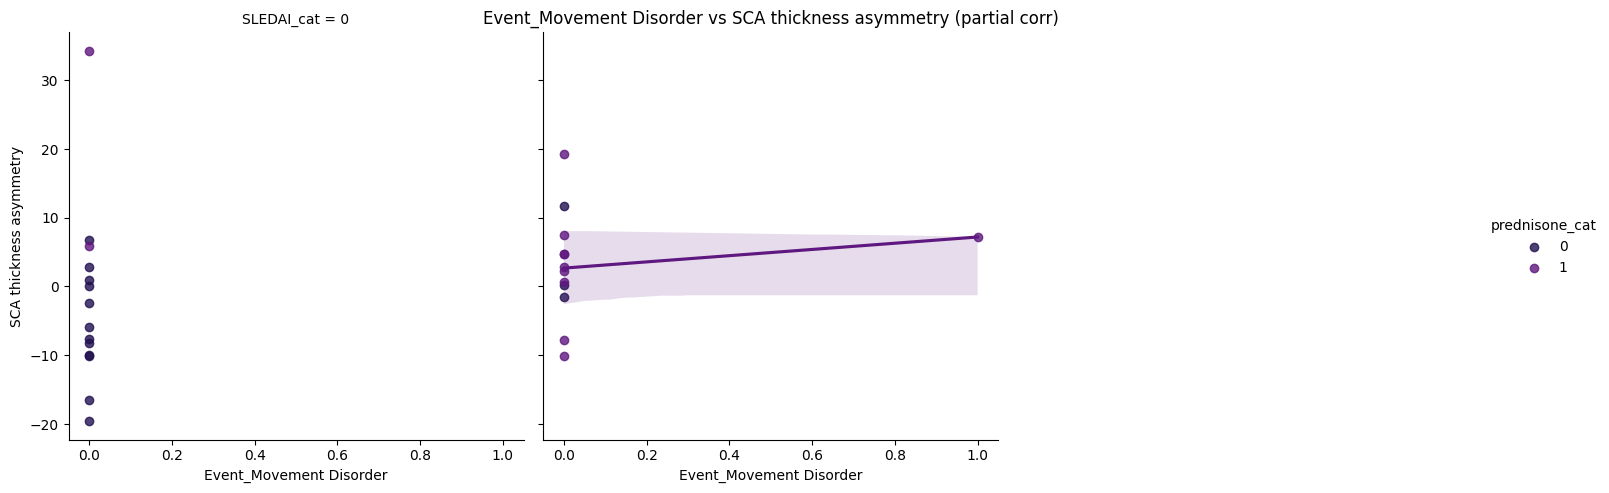

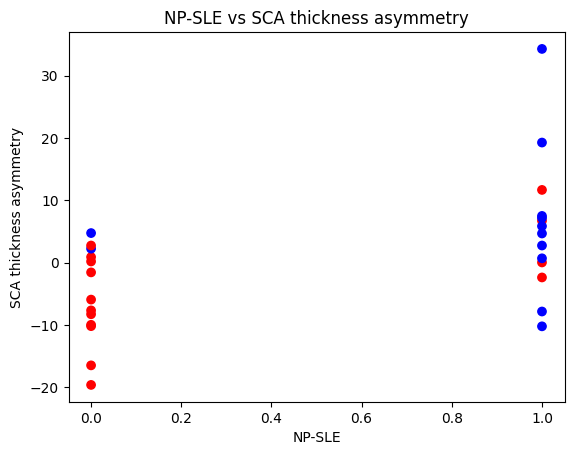

<Figure size 640x480 with 0 Axes>

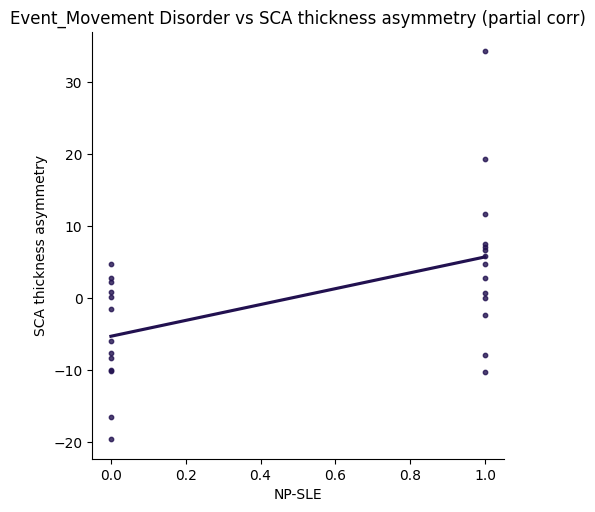

Event_Psychosis vs SCA thickness asymmetry: r = 0.32, p = 0.10
Event_Psychosis vs SCA thickness asymmetry (partial corr): r = 0.20, p = 0.34
total_neurocog vs SCA thickness asymmetry: r = 0.51, p = 0.01
NP-SLE vs SCA thickness asymmetry (partial corr): r = 0.34, p = 0.09


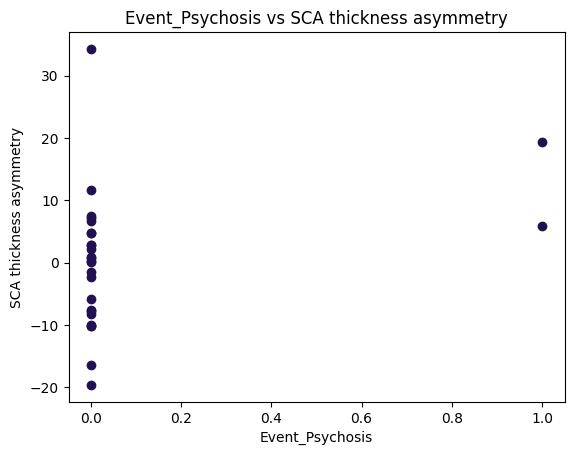

<Figure size 640x480 with 0 Axes>

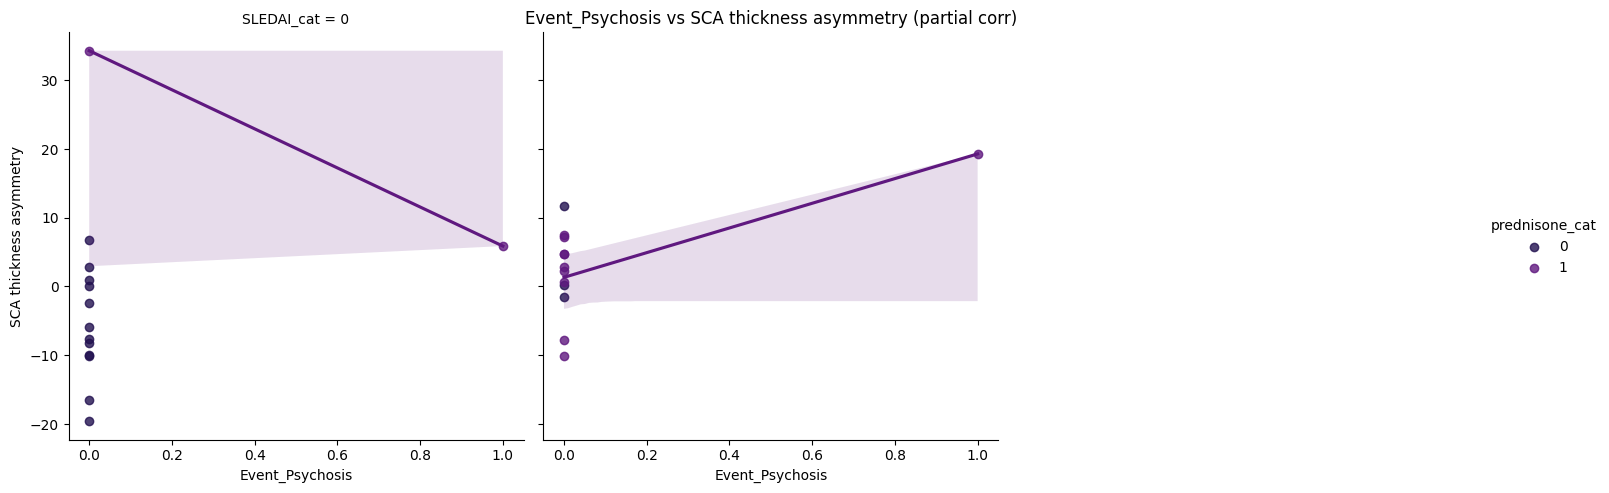

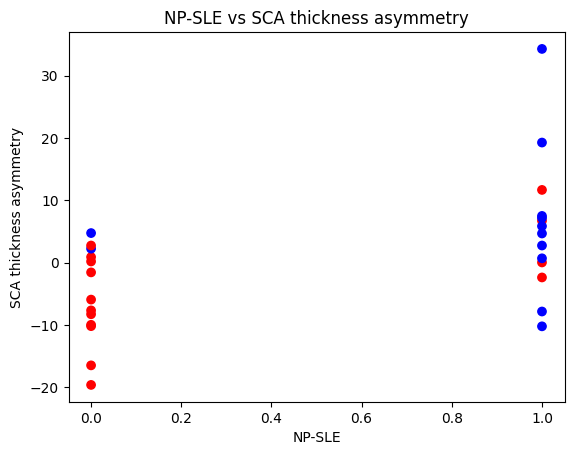

<Figure size 640x480 with 0 Axes>

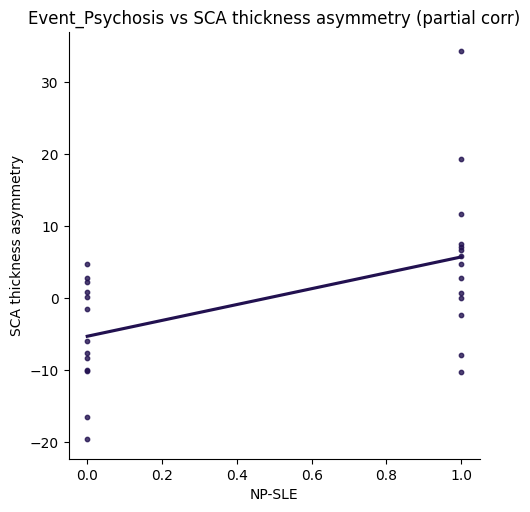

Event_Seizure vs SCA thickness asymmetry: r = -0.05, p = 0.80
Event_Seizure vs SCA thickness asymmetry (partial corr): r = -0.02, p = 0.92
total_neurocog vs SCA thickness asymmetry: r = 0.51, p = 0.01
NP-SLE vs SCA thickness asymmetry (partial corr): r = 0.34, p = 0.09


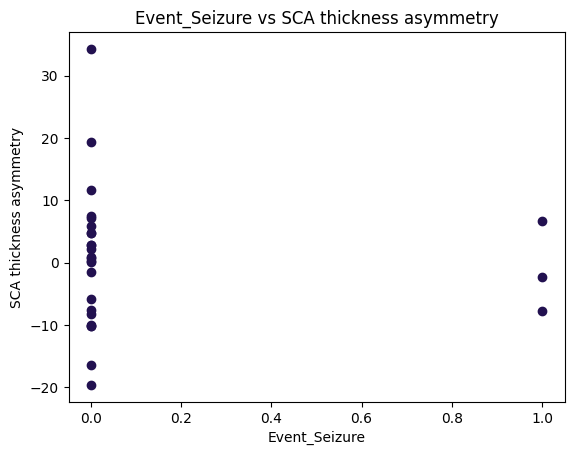

<Figure size 640x480 with 0 Axes>

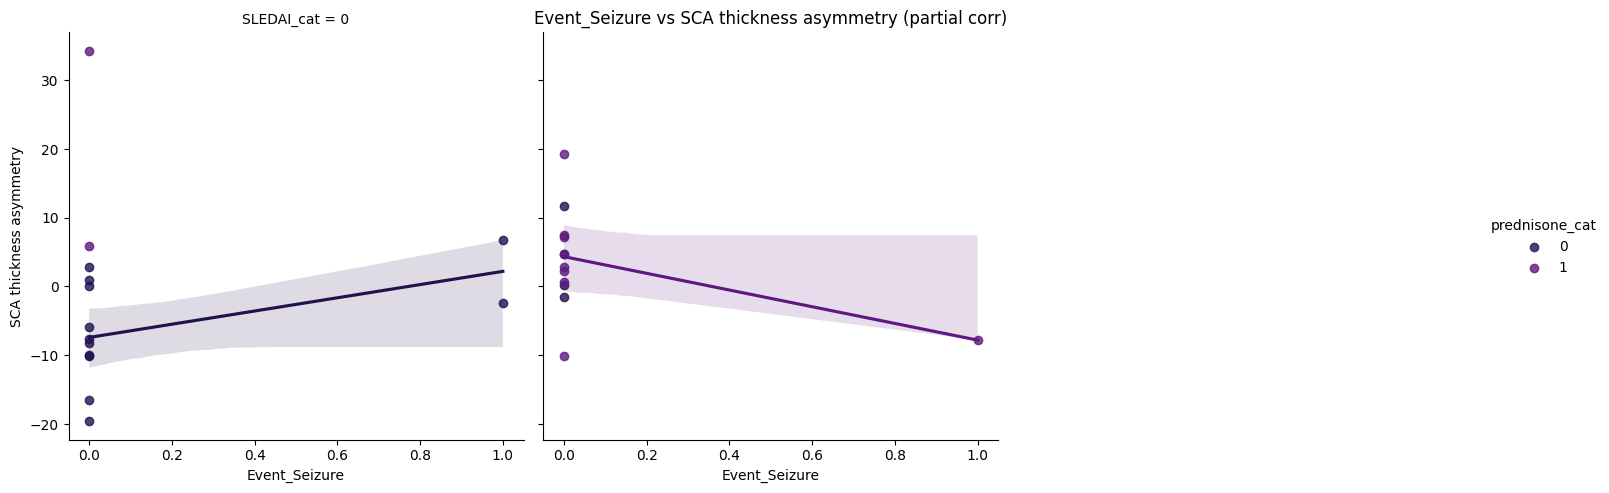

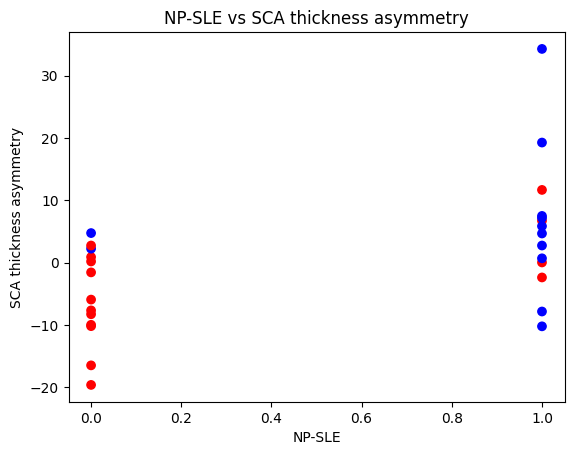

<Figure size 640x480 with 0 Axes>

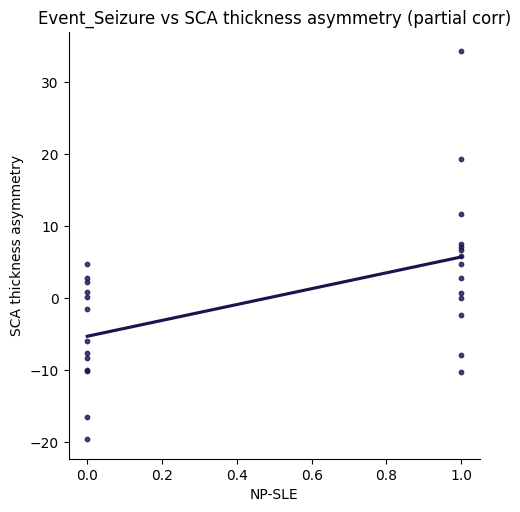

Event_Seizure, ACS, myelitis, CVA vs SCA thickness asymmetry: r = 0.20, p = 0.31
Event_Seizure, ACS, myelitis, CVA vs SCA thickness asymmetry (partial corr): r = 0.39, p = 0.06
total_neurocog vs SCA thickness asymmetry: r = 0.51, p = 0.01
NP-SLE vs SCA thickness asymmetry (partial corr): r = 0.34, p = 0.09


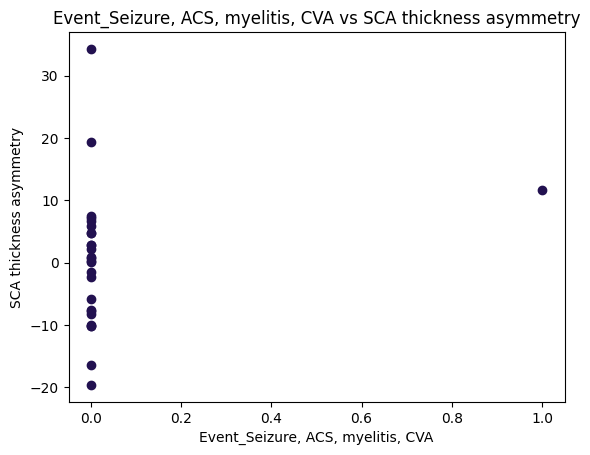

<Figure size 640x480 with 0 Axes>

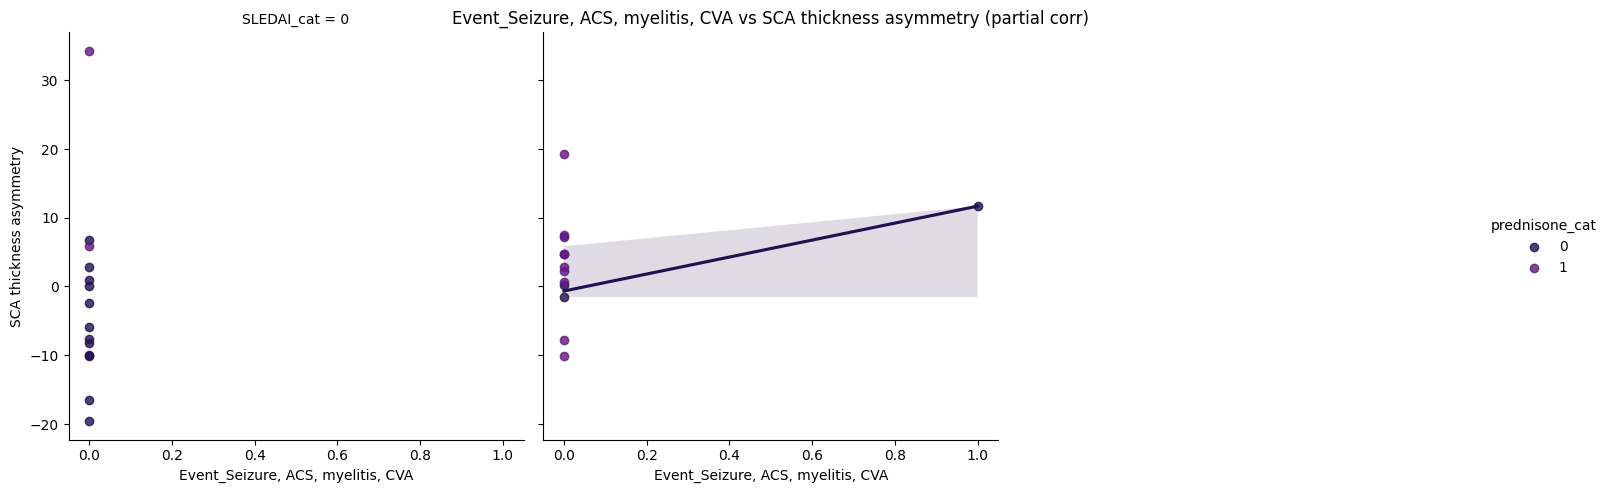

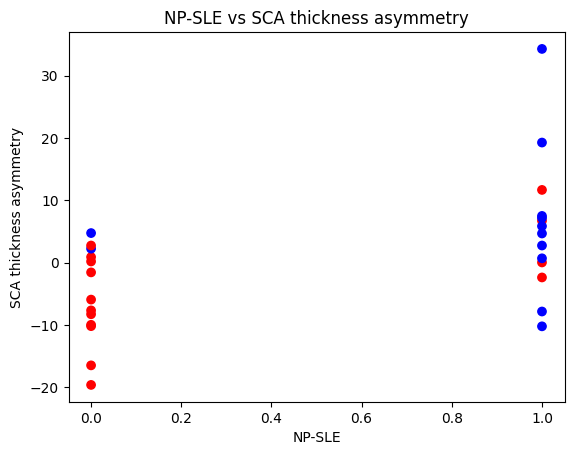

<Figure size 640x480 with 0 Axes>

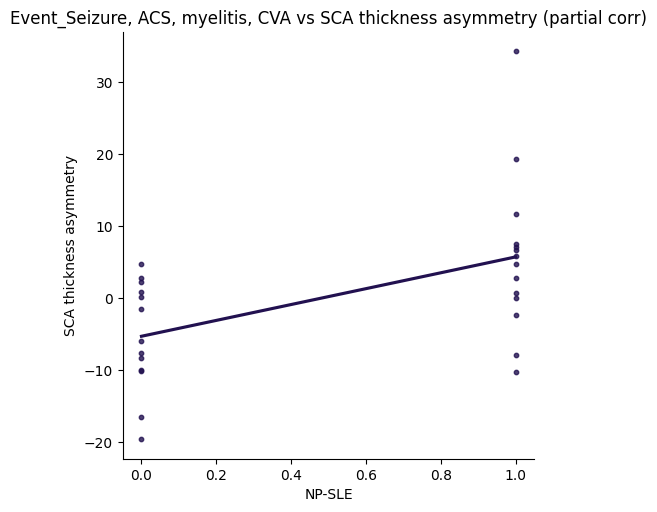

SCA thickness asymmetry vs SCA thickness asymmetry: r = 1.00, p = 0.00
total_neurocog vs SCA thickness asymmetry: r = 0.51, p = 0.01
NP-SLE vs SCA thickness asymmetry (partial corr): r = 0.34, p = 0.09


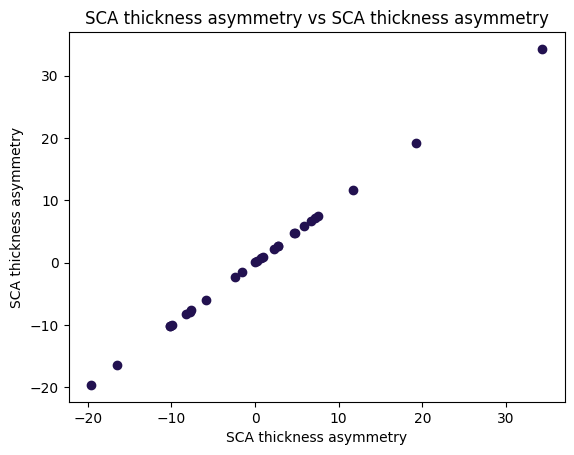

<Figure size 640x480 with 0 Axes>

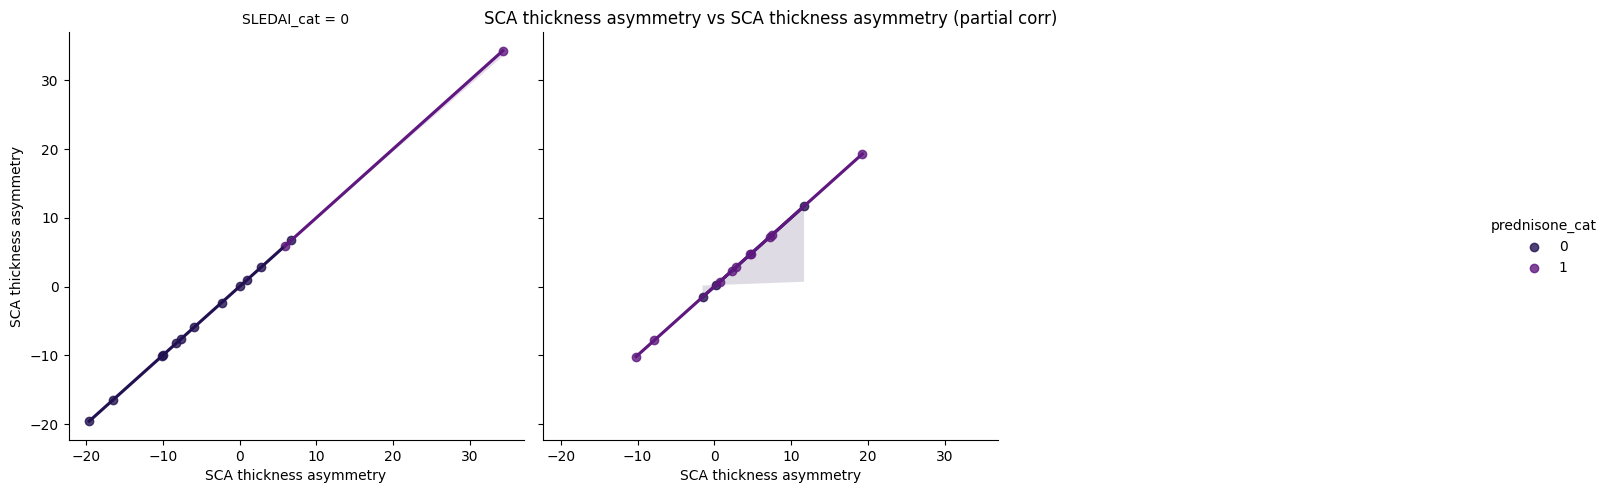

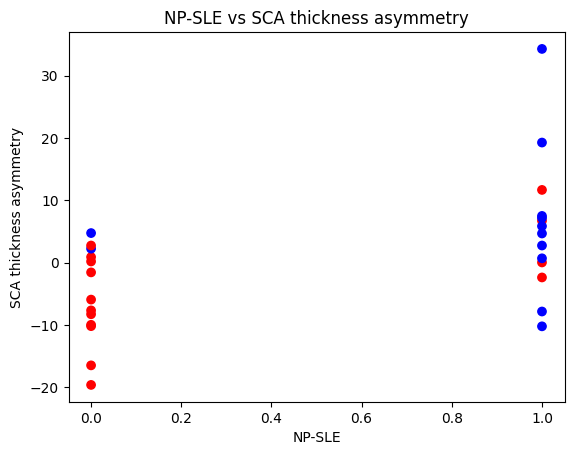

<Figure size 640x480 with 0 Axes>

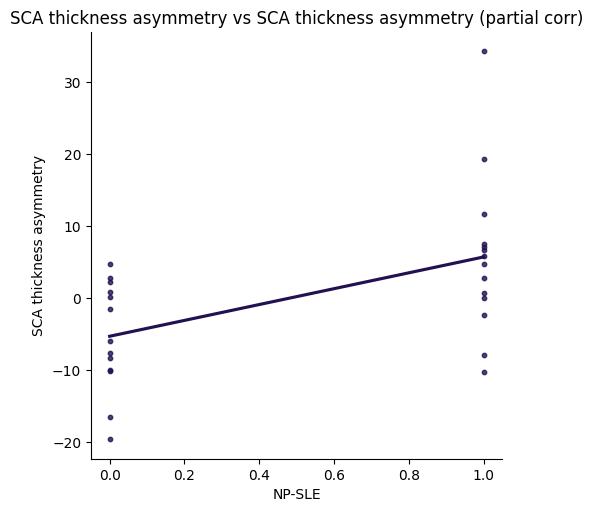

In [7]:
from scipy.stats import pearsonr
import pingouin as pg

df['SLEDAI_cat'] = np.where(df['SLEDAI-2k (at the time of NP event)'] > df['SLEDAI-2k (at the time of NP event)'].median(), 1, 0)
df['prednisone_cat'] = np.where(df['Prednisone  (mg equivalent)'] > df['Prednisone  (mg equivalent)'].median(), 1, 0)
# Define the variables
neurocog_cols = ['Event_CVA', 'Event_Mood abnormalities (depressive)', 'Event_Mood abnormalities (mixed)', 'Event_Movement Disorder', 'Event_Psychosis','Event_Seizure','Event_Seizure, ACS, myelitis, CVA']
lesion_load = 'SCA thickness asymmetry'
prednisone = 'prednisone_cat'
sledai = 'SLEDAI_cat'

# Compute the correlations
for col in neurocog_cols + [lesion_load]:
    # Compute the Pearson correlation between each neurocognitive domain and lesion load
    r, p = pearsonr(df[col], df[lesion_load])
    print(f'{col} vs {lesion_load}: r = {r:.2f}, p = {p:.2f}')

    # Compute the partial correlation adjusting for prednisone and SLEDAI
    if col != lesion_load:
        partial_corr_results = pg.partial_corr(data=df, x=col, y=lesion_load, covar=[prednisone, sledai])
        r_partial, p_partial = partial_corr_results['r'][0], partial_corr_results['p-val'][0]
        print(f'{col} vs {lesion_load} (partial corr): r = {r_partial:.2f}, p = {p_partial:.2f}')
        assert abs(r - r_partial) > 1e-10, f'{col} and {lesion_load} are perfectly correlated'

    # Compute the Pearson correlation between total neurocognitive score and lesion load
    r_total, p_total = pearsonr(df['NP-SLE'], df[lesion_load])
    print(f'total_neurocog vs {lesion_load}: r = {r_total:.2f}, p = {p_total:.2f}')

    # Compute the partial correlation adjusting for prednisone and SLEDAI
    total_partial_results = pg.partial_corr(data=df, x='NP-SLE', y=lesion_load, covar=[prednisone, sledai])
    r_total_partial, p_total_partial = total_partial_results['r'][0], total_partial_results['p-val'][0]
    print(f'NP-SLE vs {lesion_load} (partial corr): r = {r_total_partial:.2f}, p = {p_total_partial:.2f}')


    # Plot the scatter plot
    plt.figure()
    plt.scatter(df[col], df[lesion_load])
    plt.xlabel(col)
    plt.ylabel(lesion_load)
    plt.title(f'{col} vs {lesion_load}')
    plt.show()

    # Plot the partial scatter plot
    plt.figure()
    sns.lmplot(data=df, x=col, y=lesion_load, hue=prednisone, col=sledai, col_wrap=3)
    plt.title(f'{col} vs {lesion_load} (partial corr)')
    plt.show()
    
    colors = ['red' if p == 0 else 'blue' for p in df[prednisone]]
    # Plot the scatter plot of total neurocognitive score vs lesion load
    plt.figure()
    plt.scatter(df['NP-SLE'], df[lesion_load], c=colors)
    plt.xlabel('NP-SLE')
    plt.ylabel(lesion_load)
    plt.title(f'NP-SLE vs {lesion_load}')
    plt.show()

    # Plot the partial scatter plot of total neurocognitive score vs lesion load
    plt.figure()
    sns.lmplot(data=df, x='NP-SLE', y=lesion_load, ci=None, scatter_kws={"s": 10})
    plt.title(f'{col} vs {lesion_load} (partial corr)')
    plt.show()

Event_CVA vs Amygdala right volume %: r = 0.04, p = 0.86
Event_CVA vs Amygdala right volume % (partial corr): r = 0.04, p = 0.84
total_neurocog vs Amygdala right volume %: r = 0.46, p = 0.02
NP-SLE vs Amygdala right volume % (partial corr): r = 0.39, p = 0.05


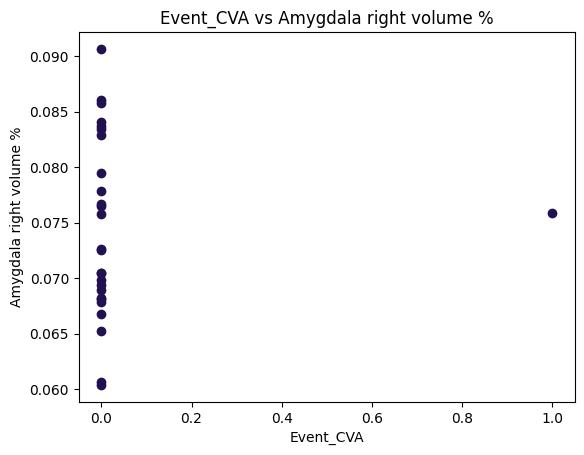

<Figure size 640x480 with 0 Axes>

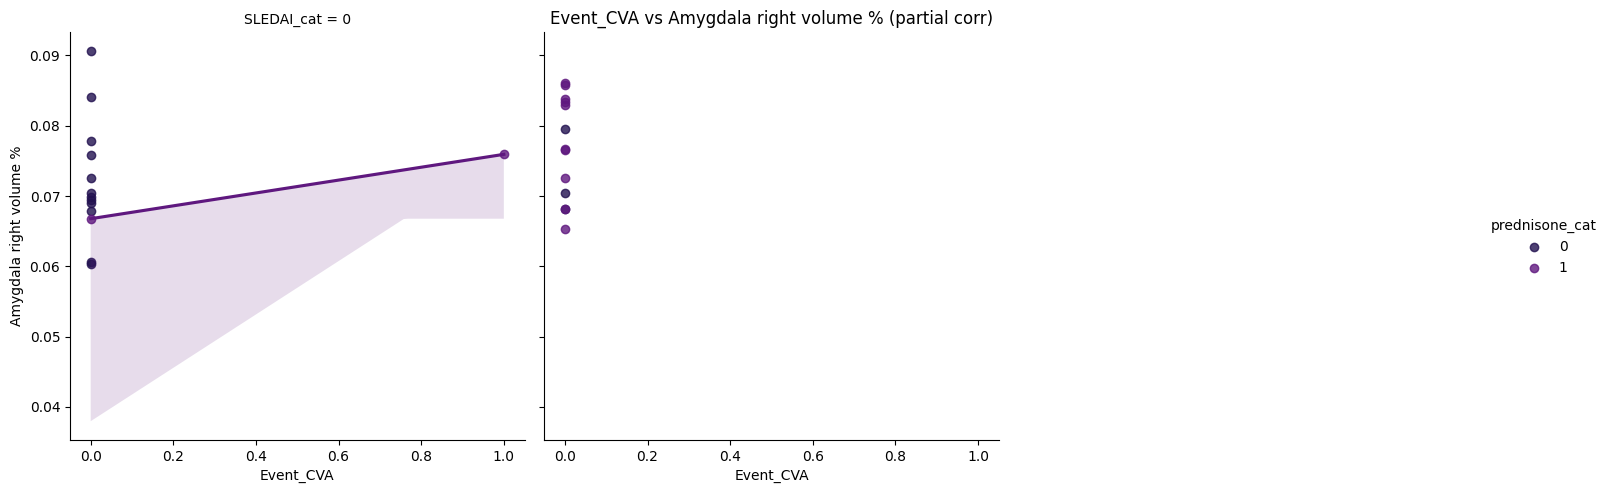

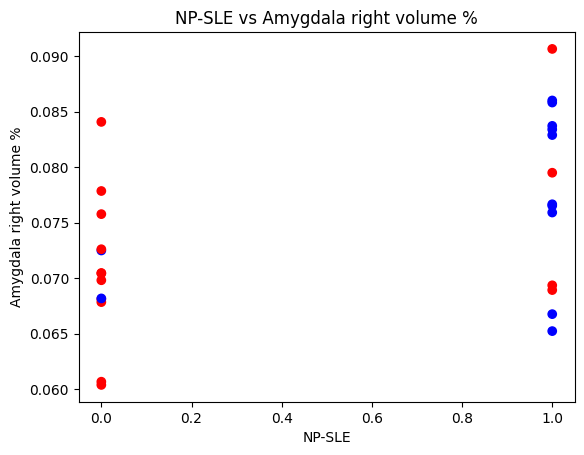

<Figure size 640x480 with 0 Axes>

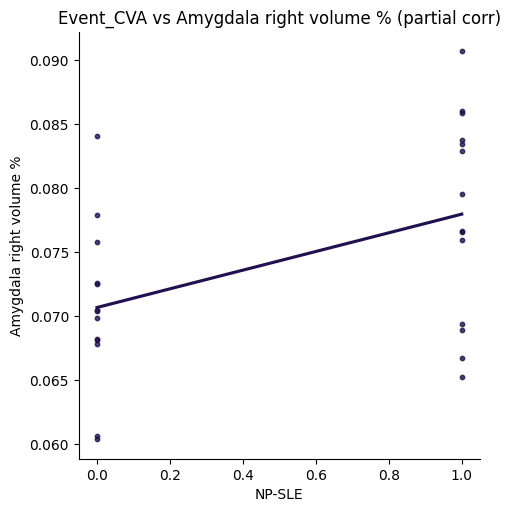

Event_Mood abnormalities (depressive) vs Amygdala right volume %: r = 0.28, p = 0.15
Event_Mood abnormalities (depressive) vs Amygdala right volume % (partial corr): r = 0.19, p = 0.36
total_neurocog vs Amygdala right volume %: r = 0.46, p = 0.02
NP-SLE vs Amygdala right volume % (partial corr): r = 0.39, p = 0.05


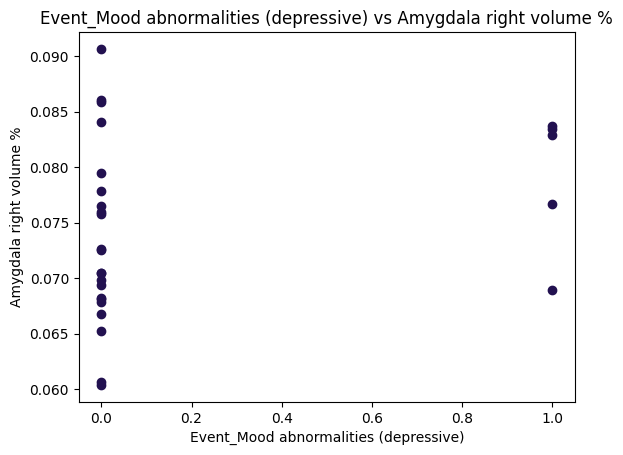

<Figure size 640x480 with 0 Axes>

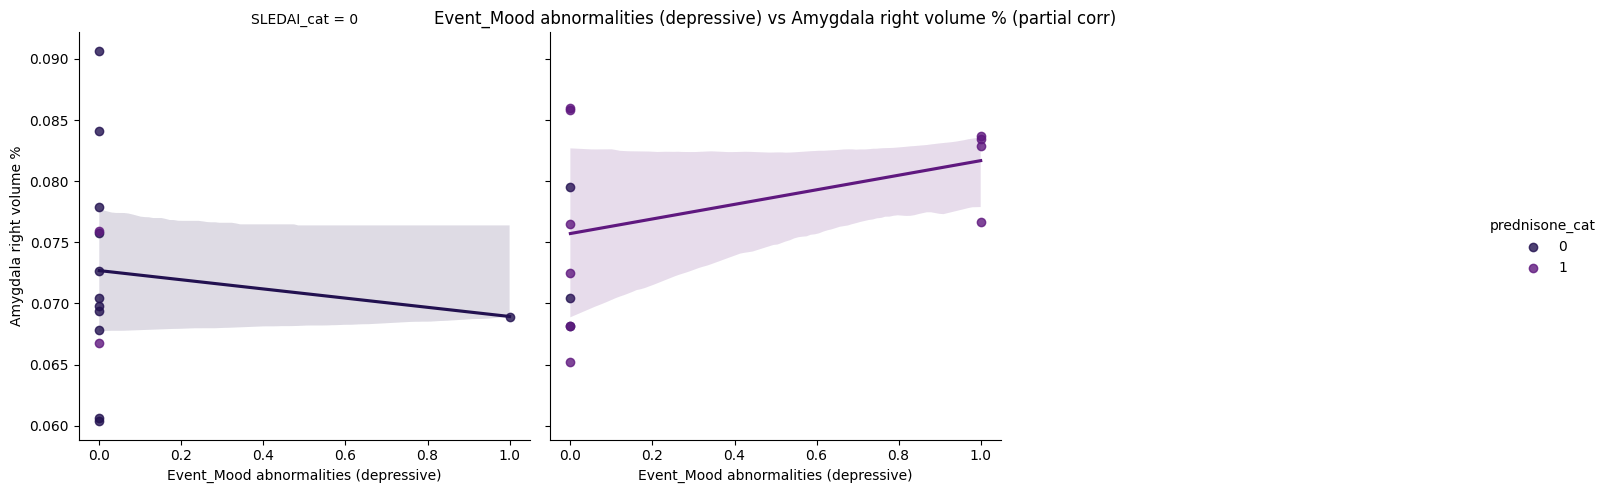

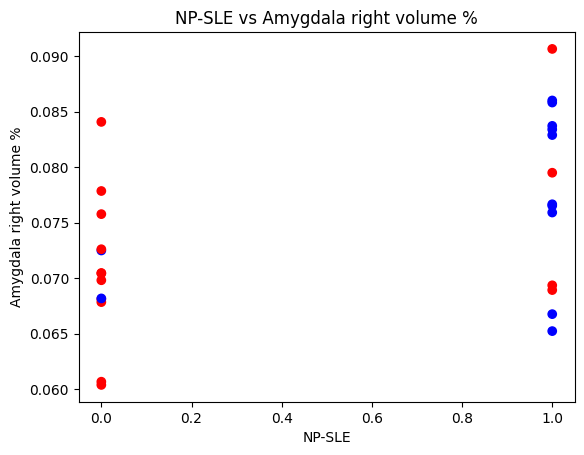

<Figure size 640x480 with 0 Axes>

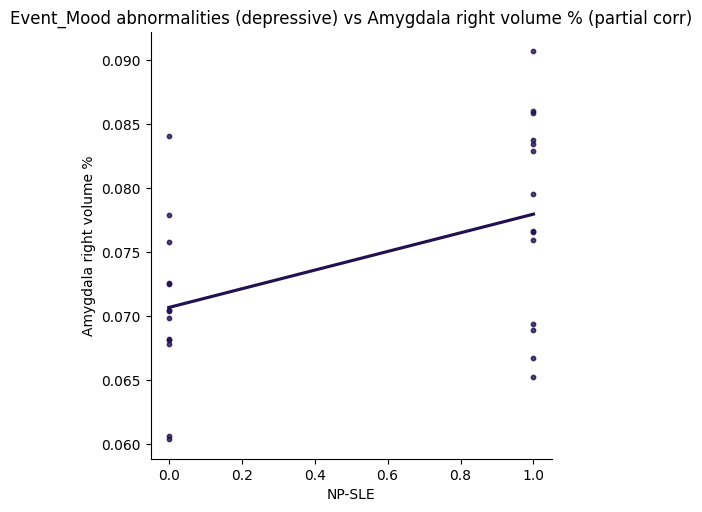

Event_Mood abnormalities (mixed) vs Amygdala right volume %: r = 0.28, p = 0.15
Event_Mood abnormalities (mixed) vs Amygdala right volume % (partial corr): r = 0.23, p = 0.28
total_neurocog vs Amygdala right volume %: r = 0.46, p = 0.02
NP-SLE vs Amygdala right volume % (partial corr): r = 0.39, p = 0.05


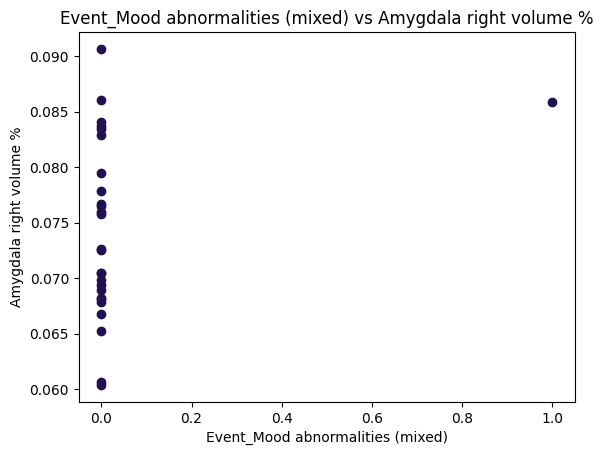

<Figure size 640x480 with 0 Axes>

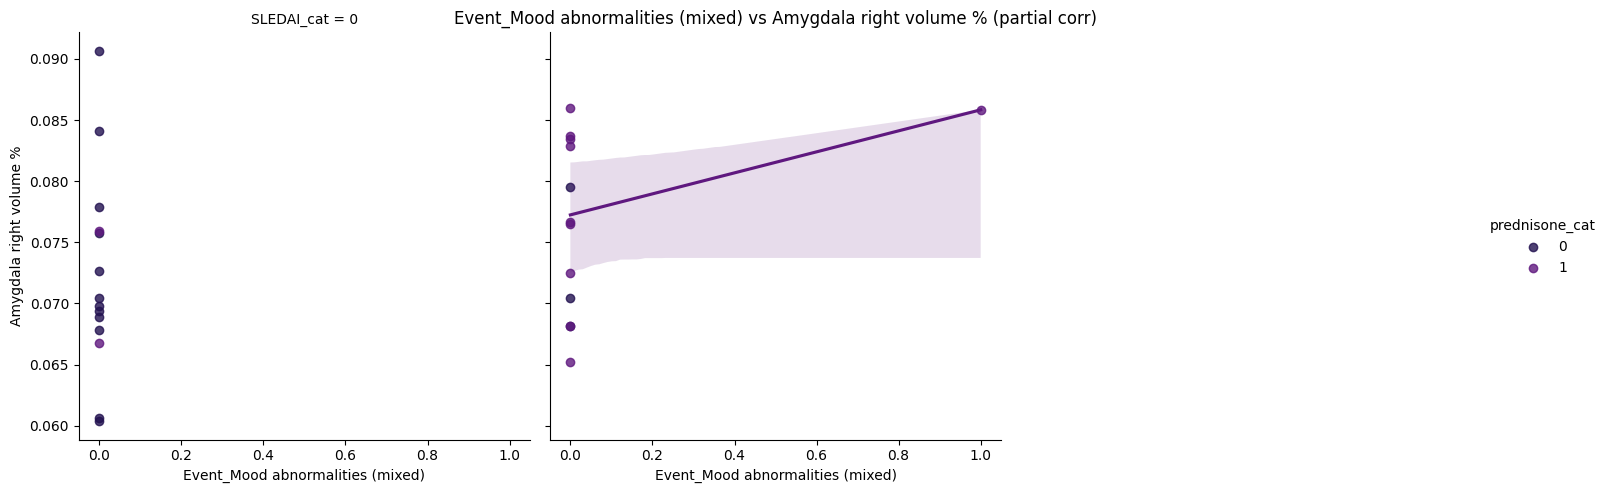

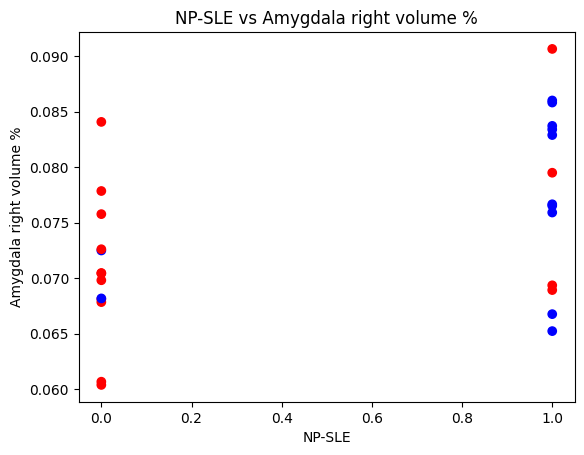

<Figure size 640x480 with 0 Axes>

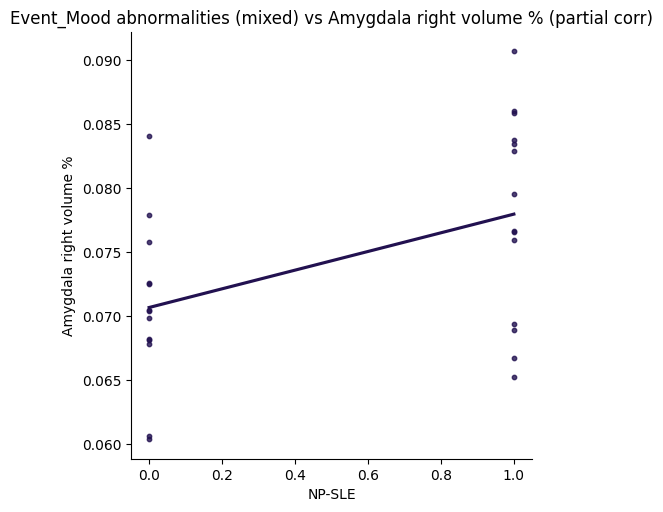

Event_Movement Disorder vs Amygdala right volume %: r = 0.29, p = 0.15
Event_Movement Disorder vs Amygdala right volume % (partial corr): r = 0.23, p = 0.27
total_neurocog vs Amygdala right volume %: r = 0.46, p = 0.02
NP-SLE vs Amygdala right volume % (partial corr): r = 0.39, p = 0.05


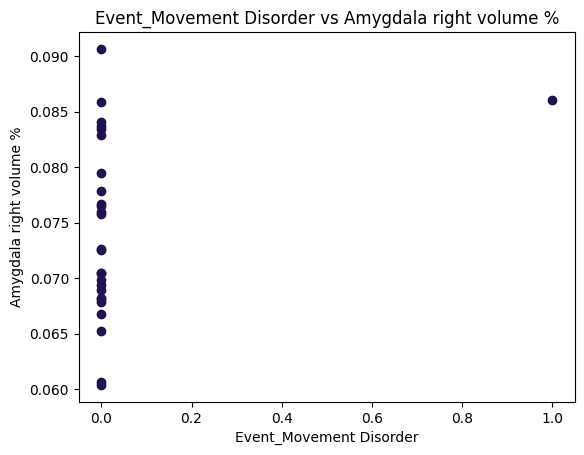

<Figure size 640x480 with 0 Axes>

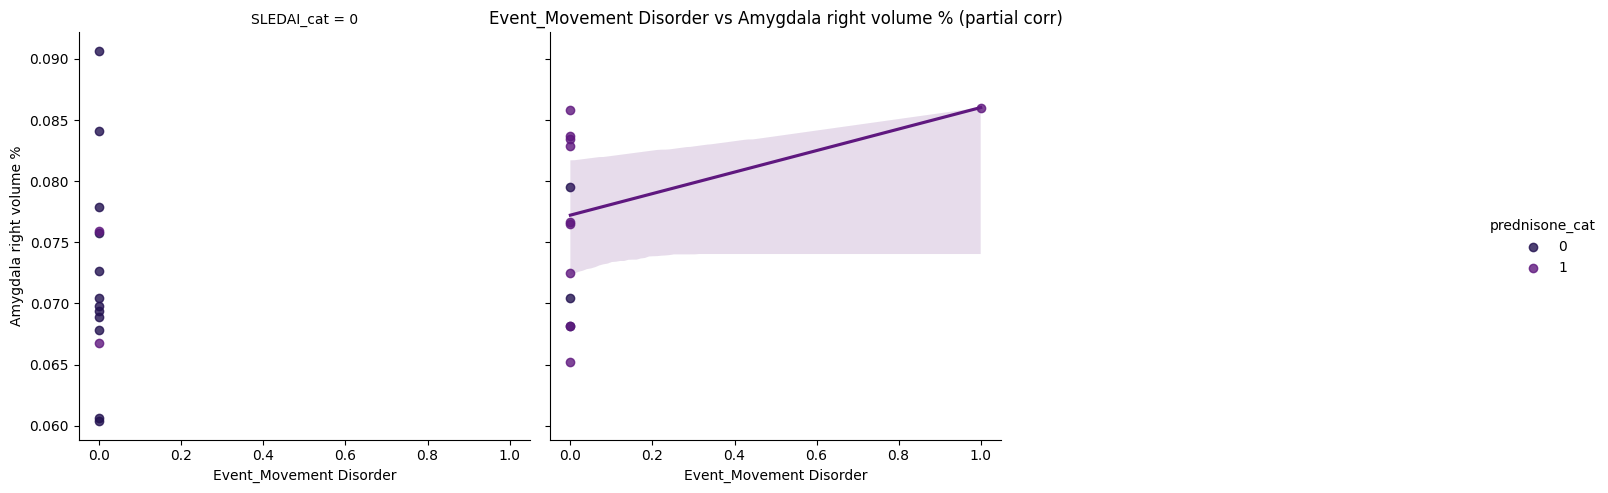

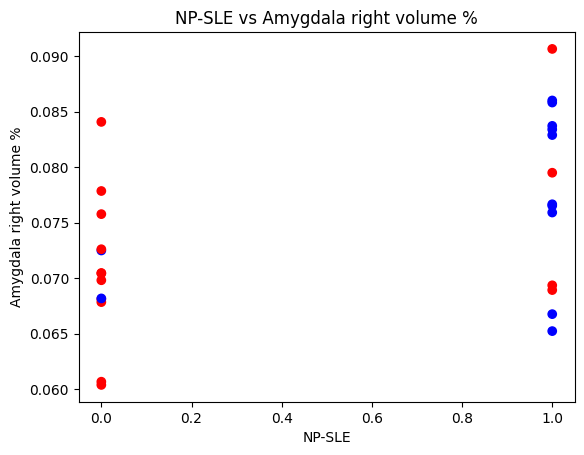

<Figure size 640x480 with 0 Axes>

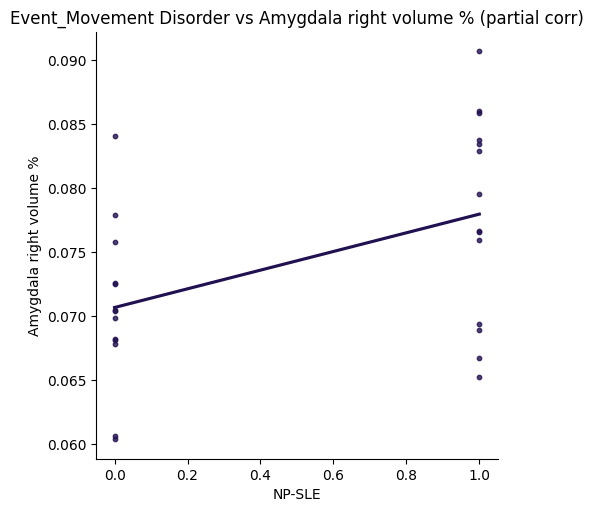

Event_Psychosis vs Amygdala right volume %: r = -0.10, p = 0.62
Event_Psychosis vs Amygdala right volume % (partial corr): r = -0.18, p = 0.39
total_neurocog vs Amygdala right volume %: r = 0.46, p = 0.02
NP-SLE vs Amygdala right volume % (partial corr): r = 0.39, p = 0.05


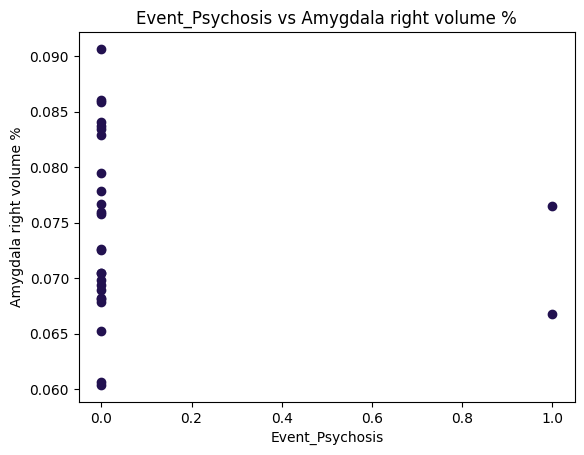

<Figure size 640x480 with 0 Axes>

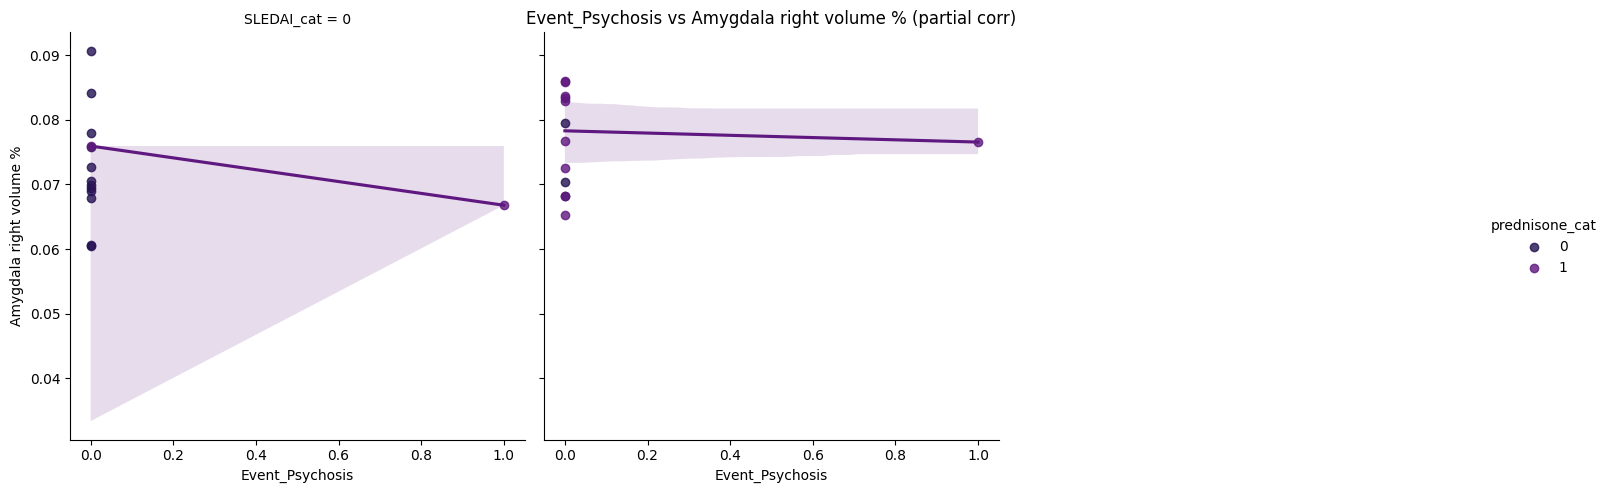

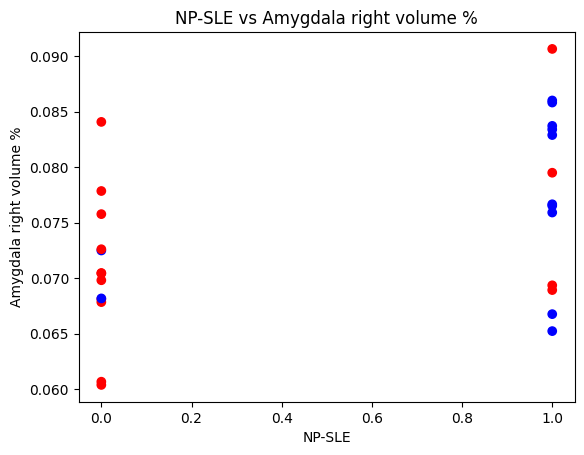

<Figure size 640x480 with 0 Axes>

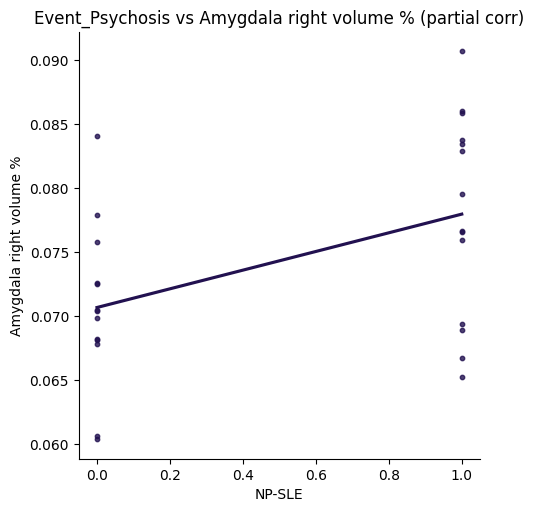

Event_Seizure vs Amygdala right volume %: r = 0.03, p = 0.89
Event_Seizure vs Amygdala right volume % (partial corr): r = 0.07, p = 0.76
total_neurocog vs Amygdala right volume %: r = 0.46, p = 0.02
NP-SLE vs Amygdala right volume % (partial corr): r = 0.39, p = 0.05


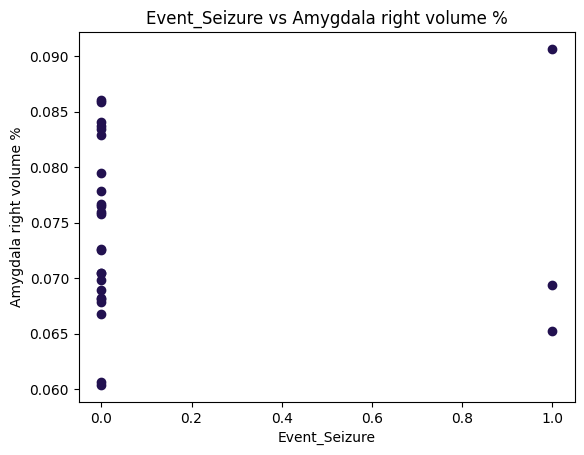

<Figure size 640x480 with 0 Axes>

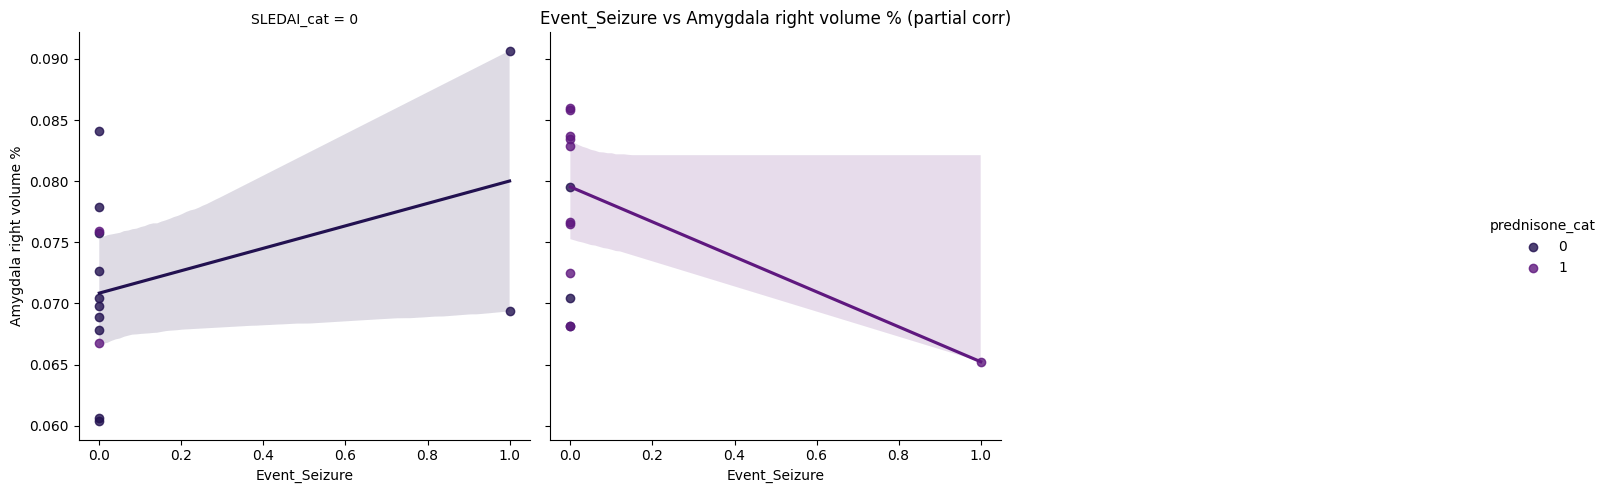

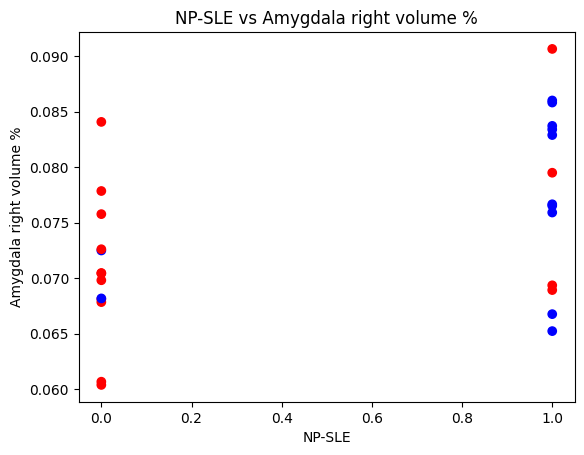

<Figure size 640x480 with 0 Axes>

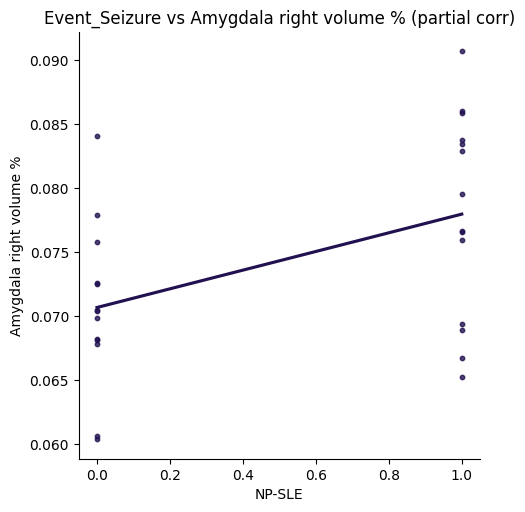

Event_Seizure, ACS, myelitis, CVA vs Amygdala right volume %: r = 0.13, p = 0.53
Event_Seizure, ACS, myelitis, CVA vs Amygdala right volume % (partial corr): r = 0.14, p = 0.51
total_neurocog vs Amygdala right volume %: r = 0.46, p = 0.02
NP-SLE vs Amygdala right volume % (partial corr): r = 0.39, p = 0.05


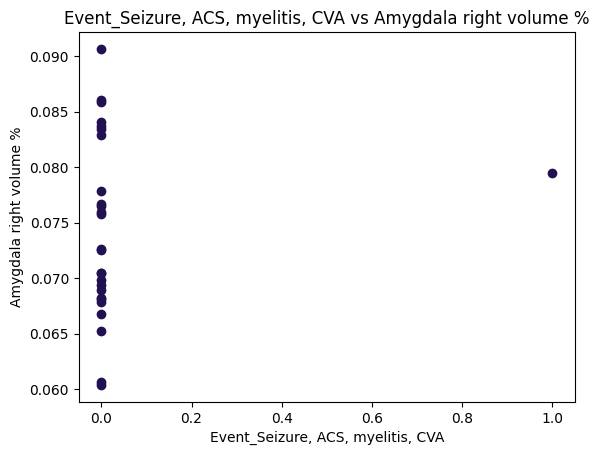

<Figure size 640x480 with 0 Axes>

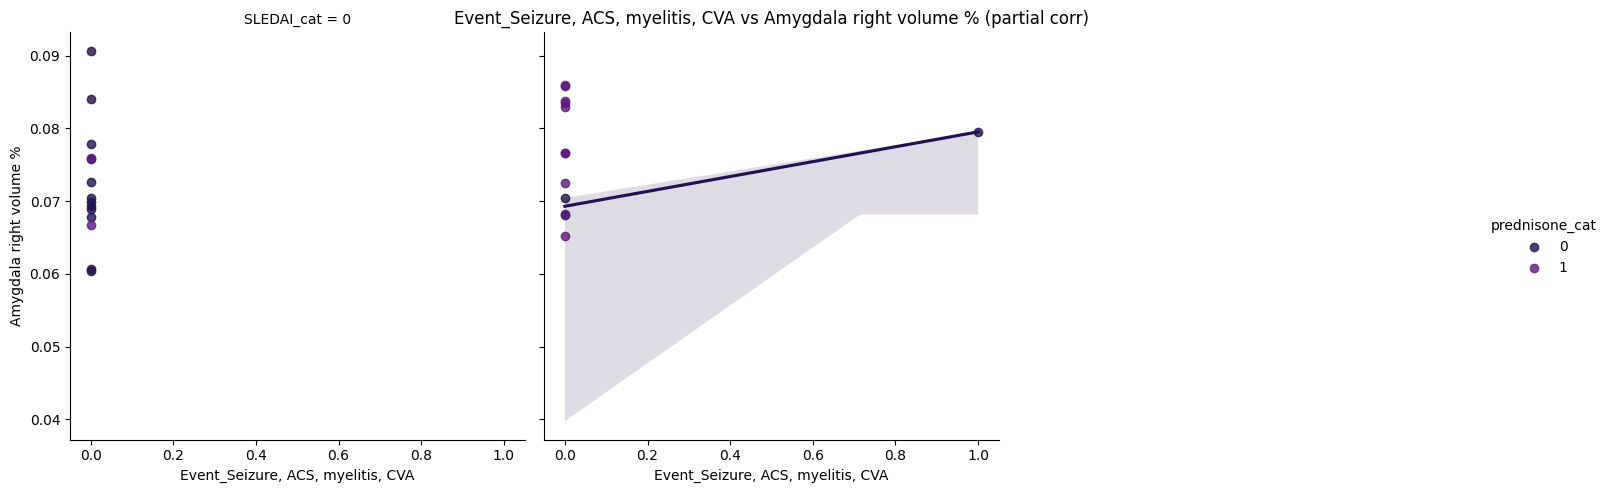

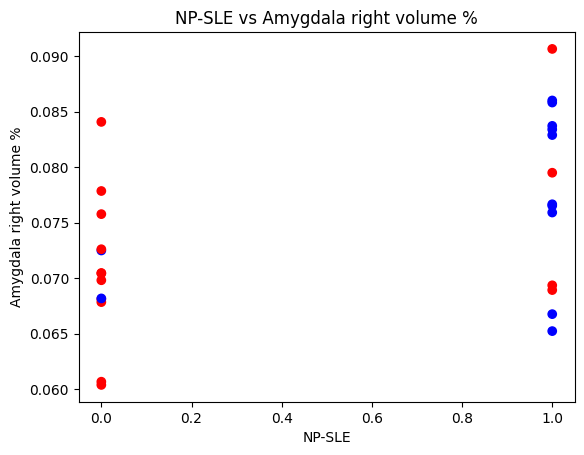

<Figure size 640x480 with 0 Axes>

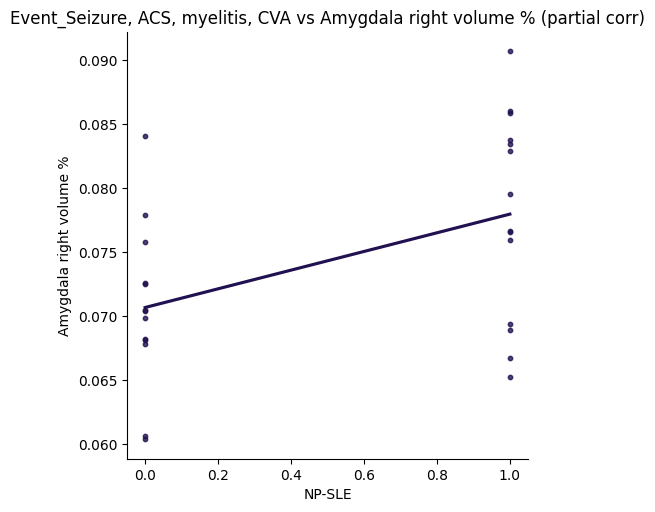

Amygdala right volume % vs Amygdala right volume %: r = 1.00, p = 0.00
total_neurocog vs Amygdala right volume %: r = 0.46, p = 0.02
NP-SLE vs Amygdala right volume % (partial corr): r = 0.39, p = 0.05


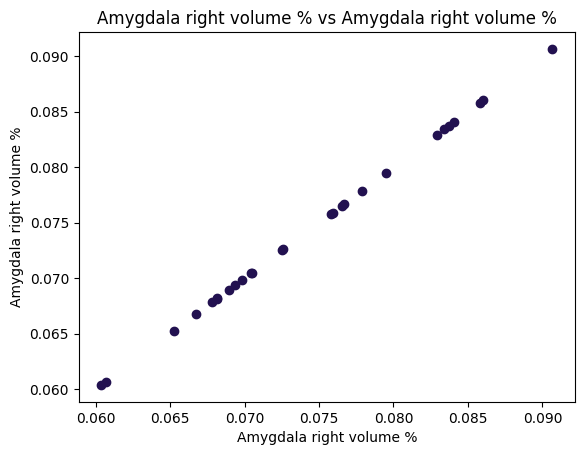

<Figure size 640x480 with 0 Axes>

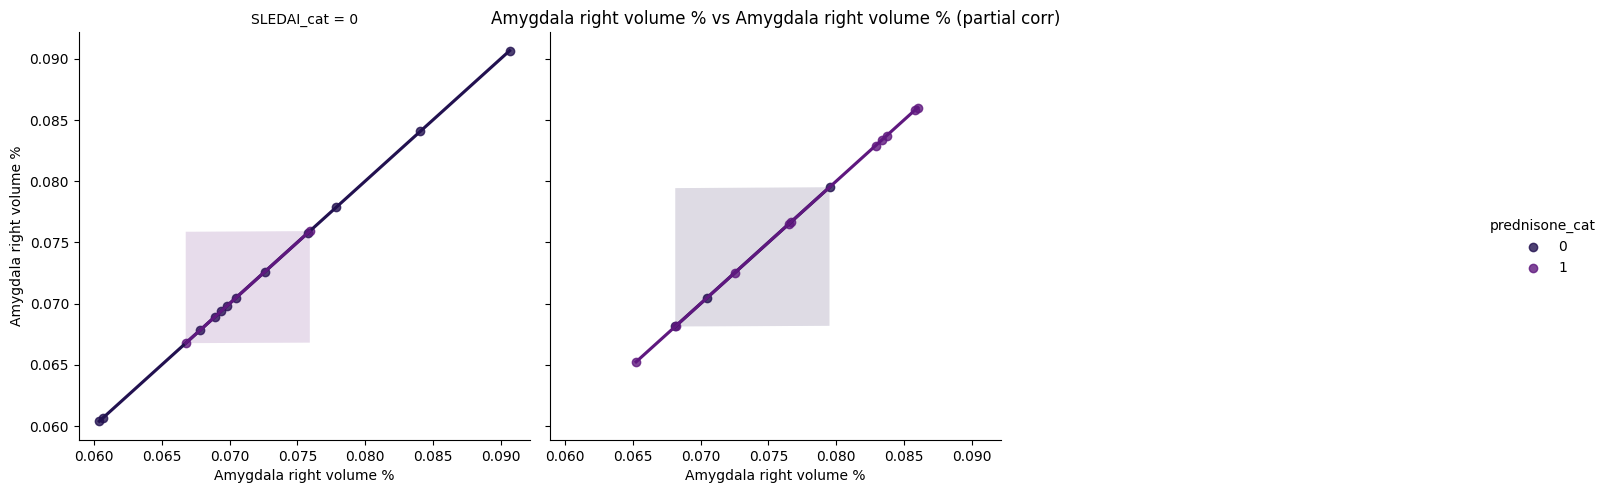

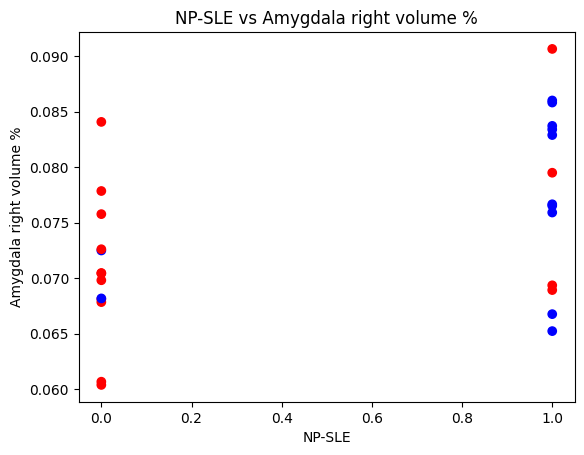

<Figure size 640x480 with 0 Axes>

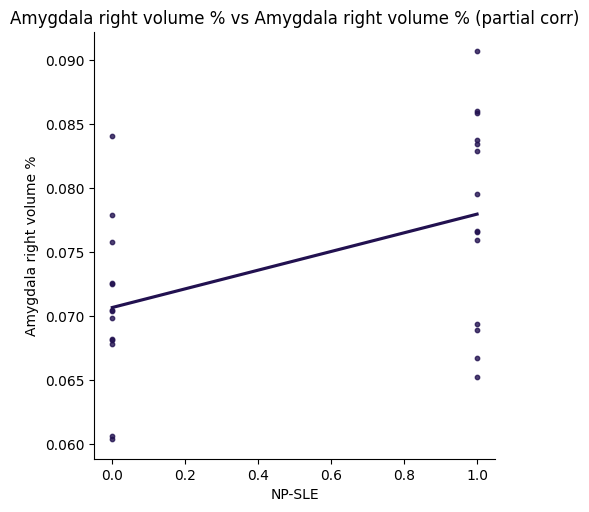

In [8]:
from scipy.stats import pearsonr
import pingouin as pg

df['SLEDAI_cat'] = np.where(df['SLEDAI-2k (at the time of NP event)'] > df['SLEDAI-2k (at the time of NP event)'].median(), 1, 0)
df['prednisone_cat'] = np.where(df['Prednisone  (mg equivalent)'] > df['Prednisone  (mg equivalent)'].median(), 1, 0)
# Define the variables
neurocog_cols = ['Event_CVA', 'Event_Mood abnormalities (depressive)', 'Event_Mood abnormalities (mixed)', 'Event_Movement Disorder', 'Event_Psychosis','Event_Seizure','Event_Seizure, ACS, myelitis, CVA']
lesion_load = 'Amygdala right volume %'
prednisone = 'prednisone_cat'
sledai = 'SLEDAI_cat'

# Compute the correlations
for col in neurocog_cols + [lesion_load]:
    # Compute the Pearson correlation between each neurocognitive domain and lesion load
    r, p = pearsonr(df[col], df[lesion_load])
    print(f'{col} vs {lesion_load}: r = {r:.2f}, p = {p:.2f}')

    # Compute the partial correlation adjusting for prednisone and SLEDAI
    if col != lesion_load:
        partial_corr_results = pg.partial_corr(data=df, x=col, y=lesion_load, covar=[prednisone, sledai])
        r_partial, p_partial = partial_corr_results['r'][0], partial_corr_results['p-val'][0]
        print(f'{col} vs {lesion_load} (partial corr): r = {r_partial:.2f}, p = {p_partial:.2f}')
        assert abs(r - r_partial) > 1e-10, f'{col} and {lesion_load} are perfectly correlated'

    # Compute the Pearson correlation between total neurocognitive score and lesion load
    r_total, p_total = pearsonr(df['NP-SLE'], df[lesion_load])
    print(f'total_neurocog vs {lesion_load}: r = {r_total:.2f}, p = {p_total:.2f}')

    # Compute the partial correlation adjusting for prednisone and SLEDAI
    total_partial_results = pg.partial_corr(data=df, x='NP-SLE', y=lesion_load, covar=[prednisone, sledai])
    r_total_partial, p_total_partial = total_partial_results['r'][0], total_partial_results['p-val'][0]
    print(f'NP-SLE vs {lesion_load} (partial corr): r = {r_total_partial:.2f}, p = {p_total_partial:.2f}')


    # Plot the scatter plot
    plt.figure()
    plt.scatter(df[col], df[lesion_load])
    plt.xlabel(col)
    plt.ylabel(lesion_load)
    plt.title(f'{col} vs {lesion_load}')
    plt.show()

    # Plot the partial scatter plot
    plt.figure()
    sns.lmplot(data=df, x=col, y=lesion_load, hue=prednisone, col=sledai, col_wrap=3)
    plt.title(f'{col} vs {lesion_load} (partial corr)')
    plt.show()
    
    colors = ['red' if p == 0 else 'blue' for p in df[prednisone]]
    # Plot the scatter plot of total neurocognitive score vs lesion load
    plt.figure()
    plt.scatter(df['NP-SLE'], df[lesion_load], c=colors)
    plt.xlabel('NP-SLE')
    plt.ylabel(lesion_load)
    plt.title(f'NP-SLE vs {lesion_load}')
    plt.show()

    # Plot the partial scatter plot of total neurocognitive score vs lesion load
    plt.figure()
    sns.lmplot(data=df, x='NP-SLE', y=lesion_load, ci=None, scatter_kws={"s": 10})
    plt.title(f'{col} vs {lesion_load} (partial corr)')
    plt.show()

Event_CVA vs Temporal thickness asymmetry: r = 0.36, p = 0.07
Event_CVA vs Temporal thickness asymmetry (partial corr): r = 0.34, p = 0.09
total_neurocog vs Temporal thickness asymmetry: r = 0.44, p = 0.02
NP-SLE vs Temporal thickness asymmetry (partial corr): r = 0.48, p = 0.02


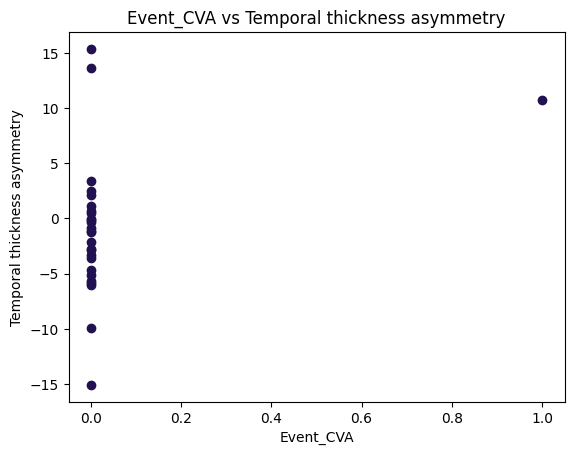

<Figure size 640x480 with 0 Axes>

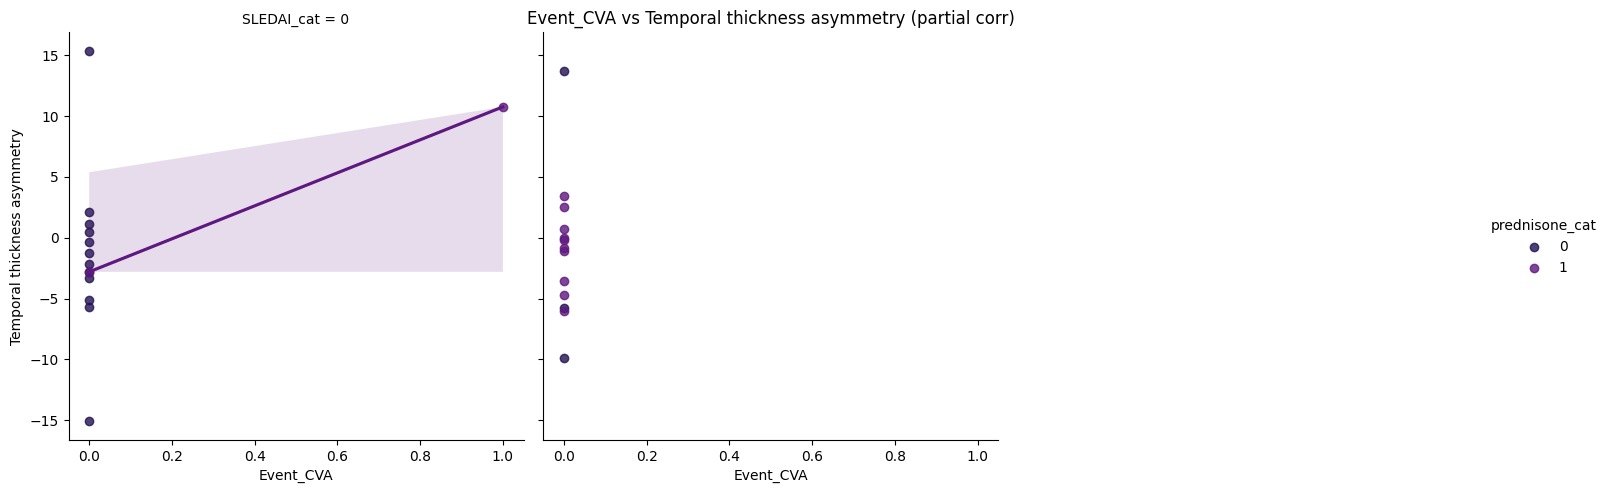

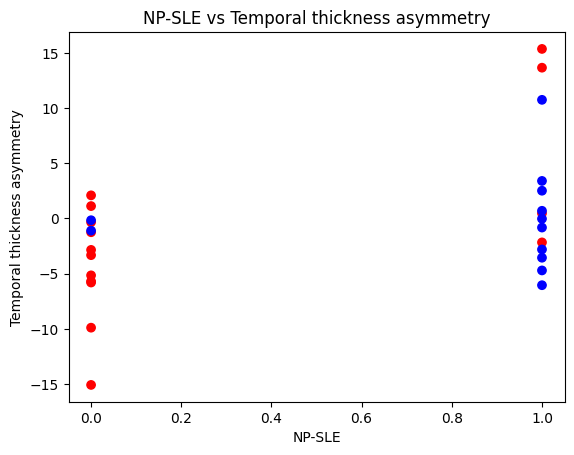

<Figure size 640x480 with 0 Axes>

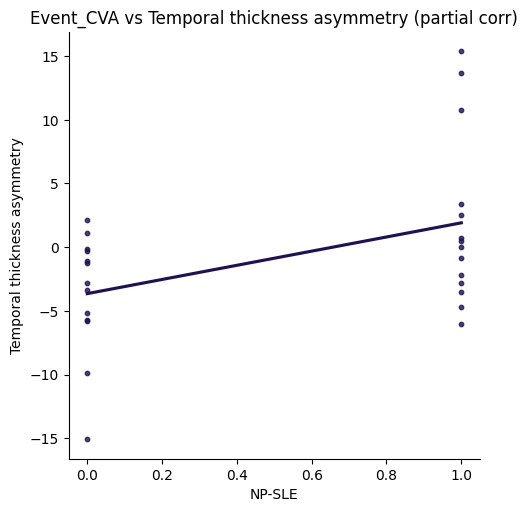

Event_Mood abnormalities (depressive) vs Temporal thickness asymmetry: r = 0.02, p = 0.91
Event_Mood abnormalities (depressive) vs Temporal thickness asymmetry (partial corr): r = 0.00, p = 0.99
total_neurocog vs Temporal thickness asymmetry: r = 0.44, p = 0.02
NP-SLE vs Temporal thickness asymmetry (partial corr): r = 0.48, p = 0.02


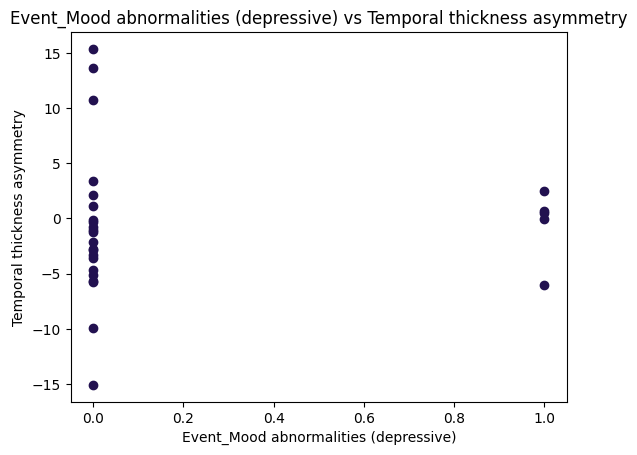

<Figure size 640x480 with 0 Axes>

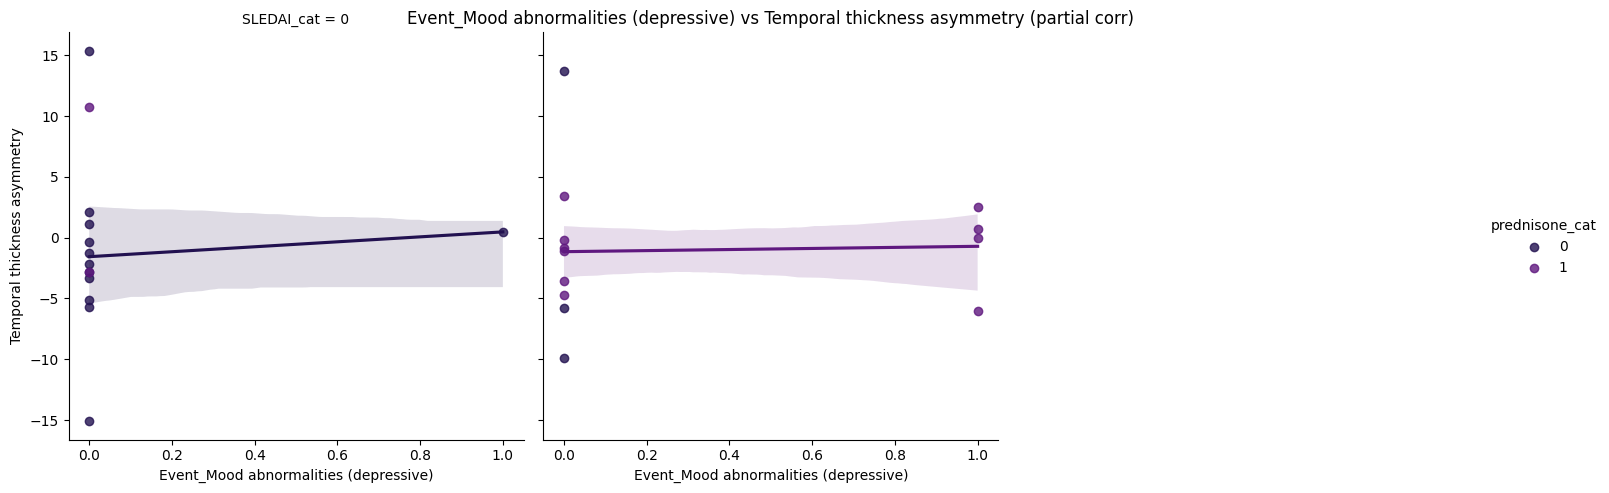

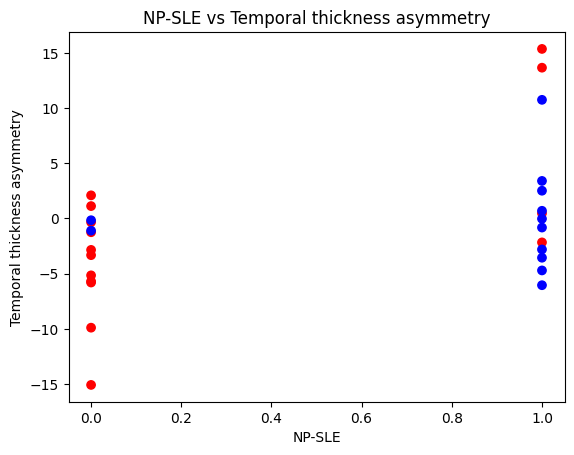

<Figure size 640x480 with 0 Axes>

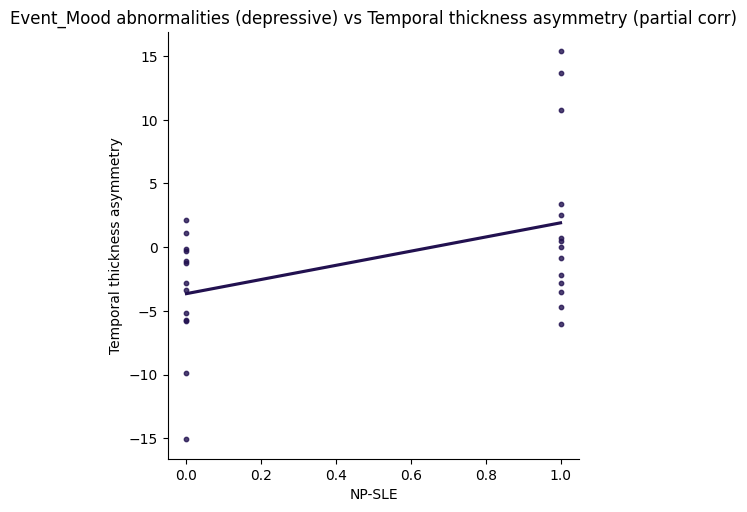

Event_Mood abnormalities (mixed) vs Temporal thickness asymmetry: r = -0.12, p = 0.54
Event_Mood abnormalities (mixed) vs Temporal thickness asymmetry (partial corr): r = -0.14, p = 0.51
total_neurocog vs Temporal thickness asymmetry: r = 0.44, p = 0.02
NP-SLE vs Temporal thickness asymmetry (partial corr): r = 0.48, p = 0.02


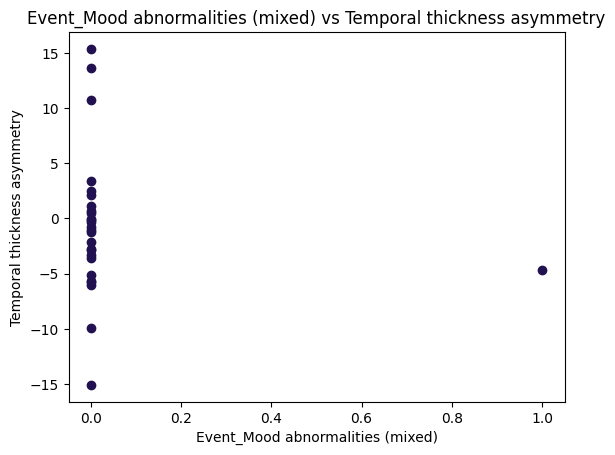

<Figure size 640x480 with 0 Axes>

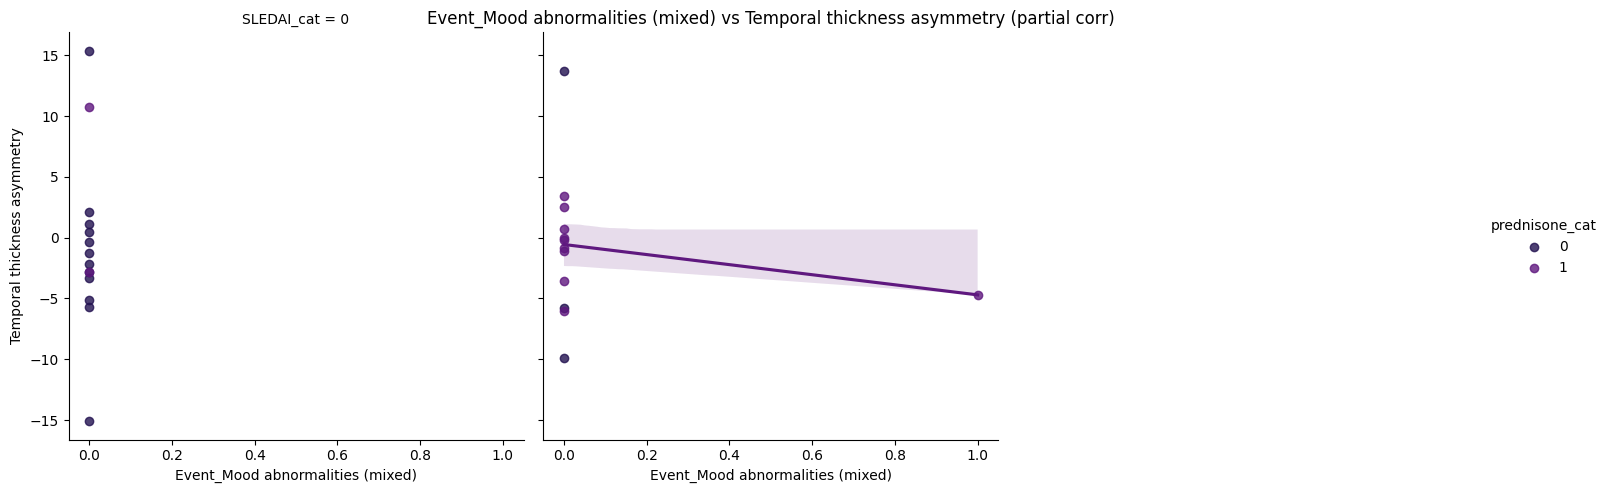

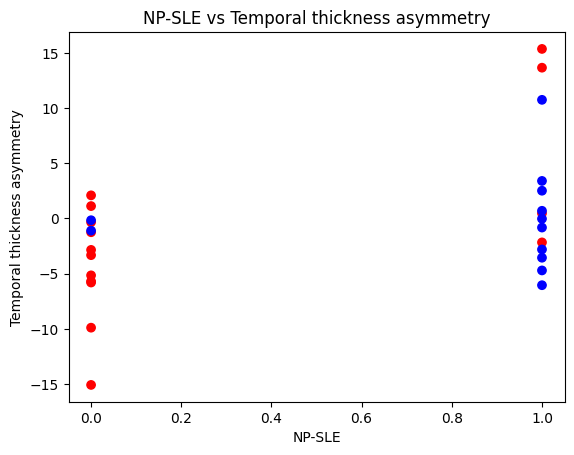

<Figure size 640x480 with 0 Axes>

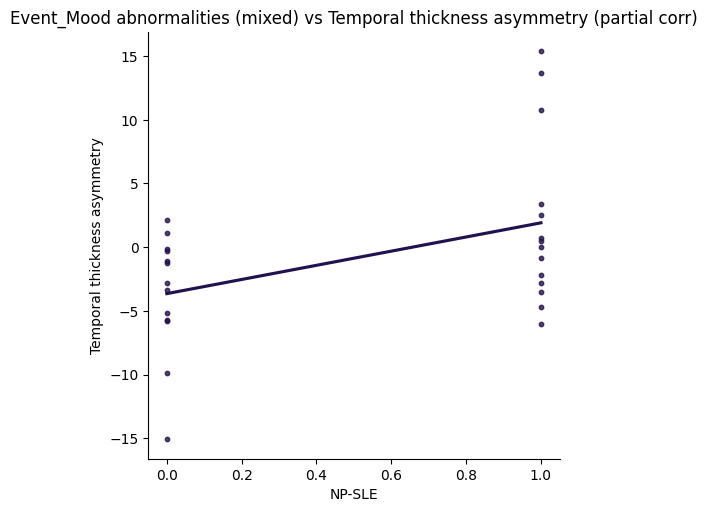

Event_Movement Disorder vs Temporal thickness asymmetry: r = 0.13, p = 0.52
Event_Movement Disorder vs Temporal thickness asymmetry (partial corr): r = 0.12, p = 0.56
total_neurocog vs Temporal thickness asymmetry: r = 0.44, p = 0.02
NP-SLE vs Temporal thickness asymmetry (partial corr): r = 0.48, p = 0.02


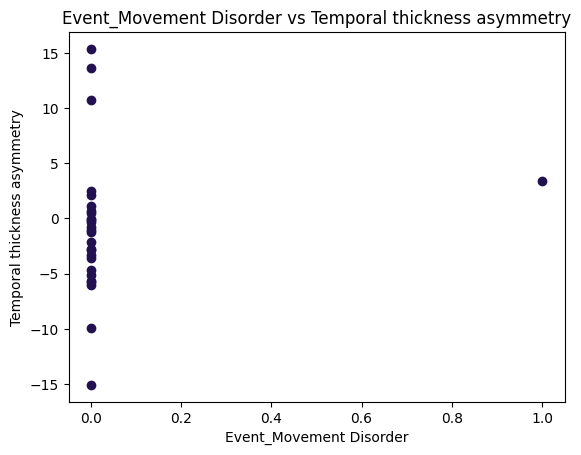

<Figure size 640x480 with 0 Axes>

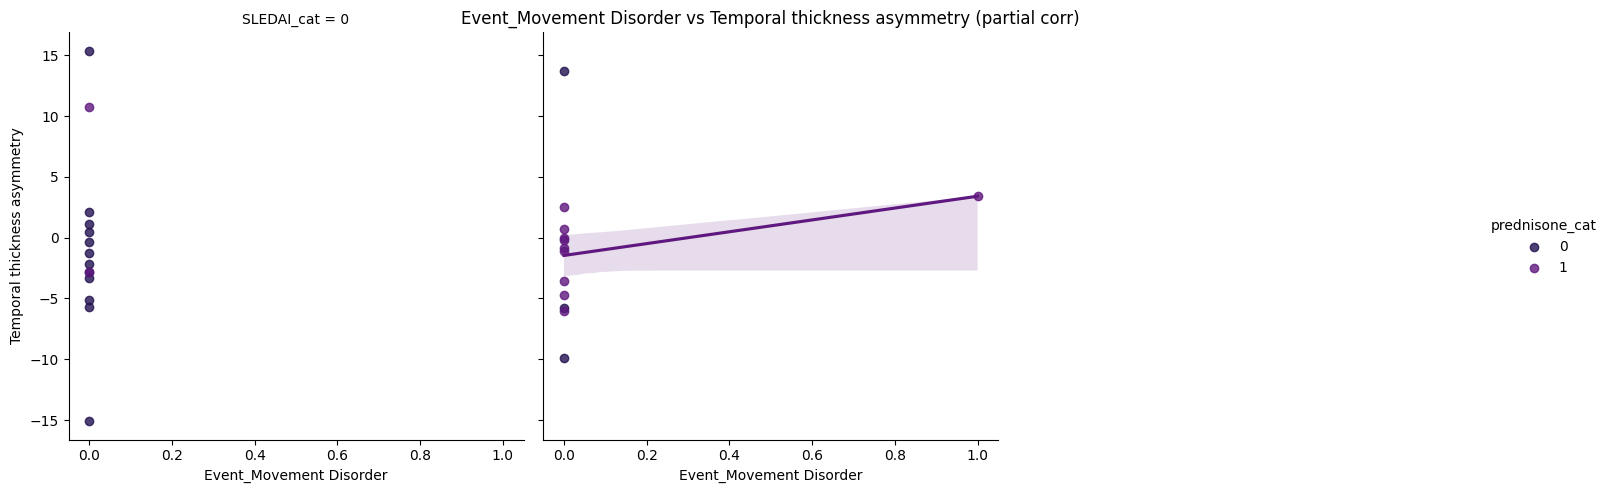

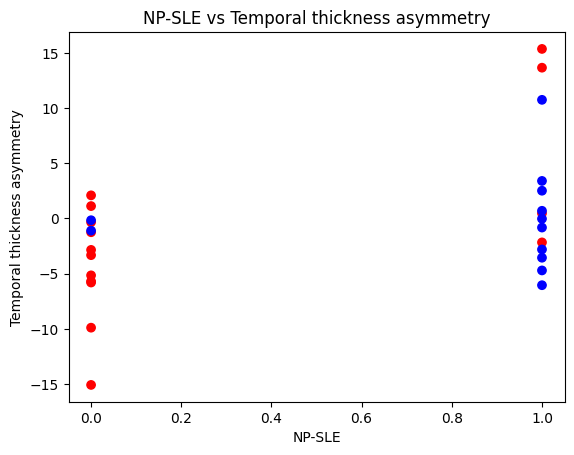

<Figure size 640x480 with 0 Axes>

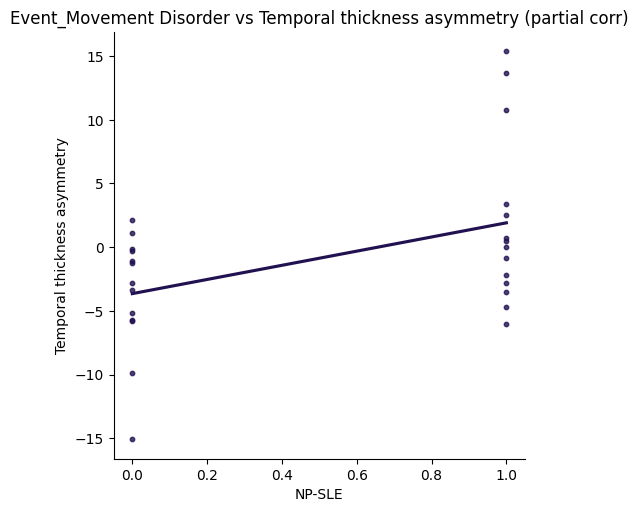

Event_Psychosis vs Temporal thickness asymmetry: r = -0.11, p = 0.59
Event_Psychosis vs Temporal thickness asymmetry (partial corr): r = -0.18, p = 0.40
total_neurocog vs Temporal thickness asymmetry: r = 0.44, p = 0.02
NP-SLE vs Temporal thickness asymmetry (partial corr): r = 0.48, p = 0.02


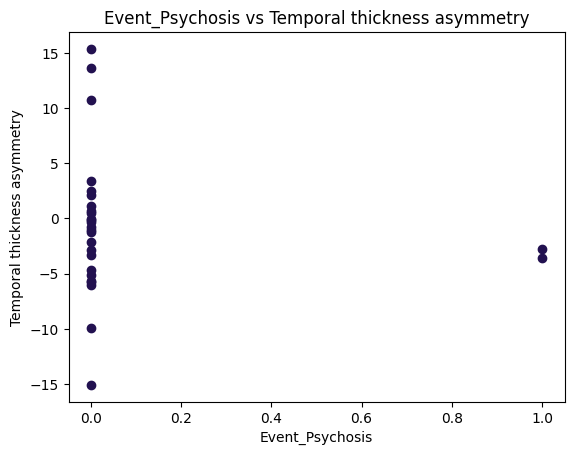

<Figure size 640x480 with 0 Axes>

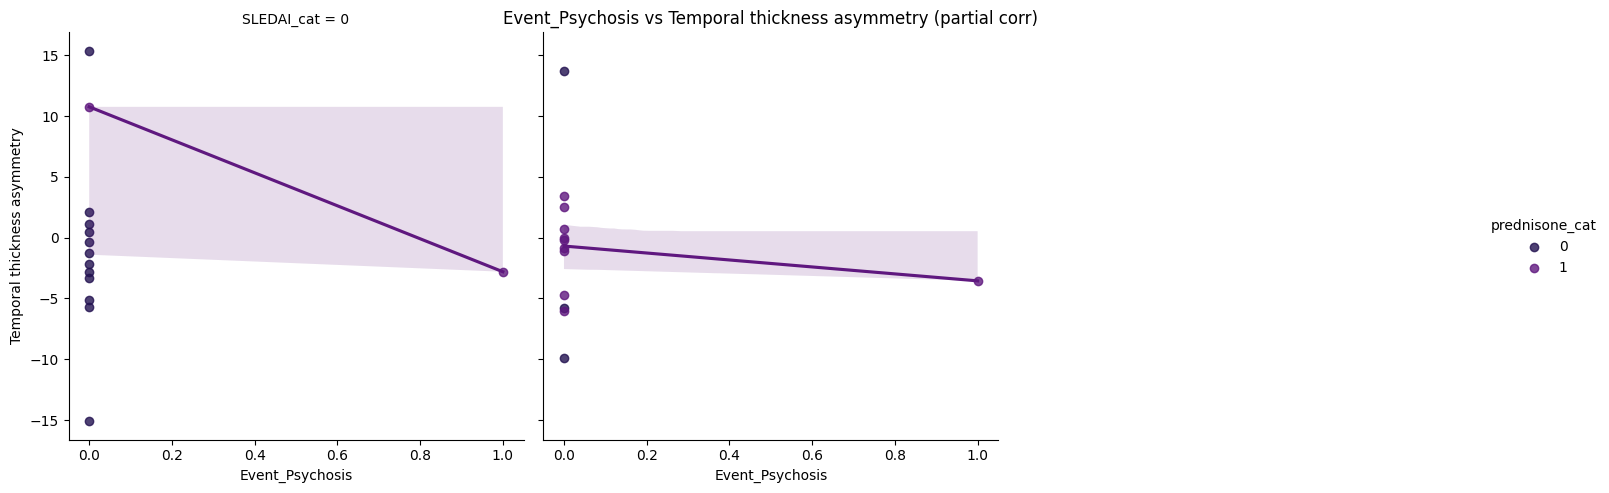

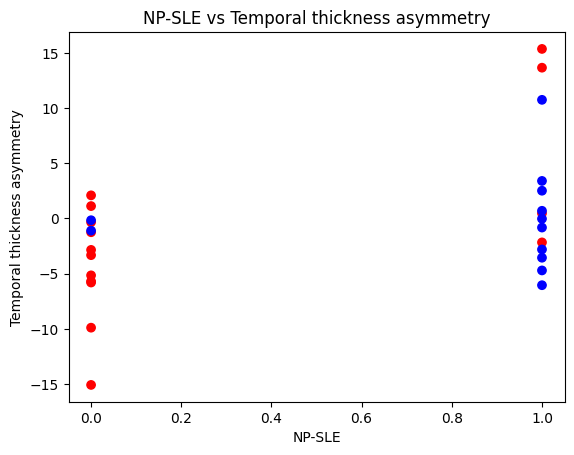

<Figure size 640x480 with 0 Axes>

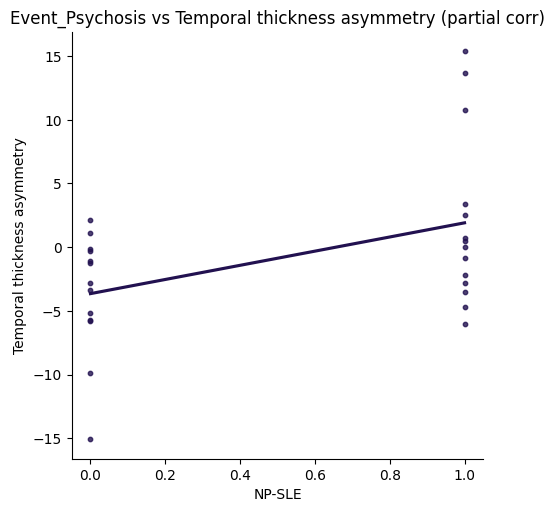

Event_Seizure vs Temporal thickness asymmetry: r = 0.27, p = 0.17
Event_Seizure vs Temporal thickness asymmetry (partial corr): r = 0.28, p = 0.18
total_neurocog vs Temporal thickness asymmetry: r = 0.44, p = 0.02
NP-SLE vs Temporal thickness asymmetry (partial corr): r = 0.48, p = 0.02


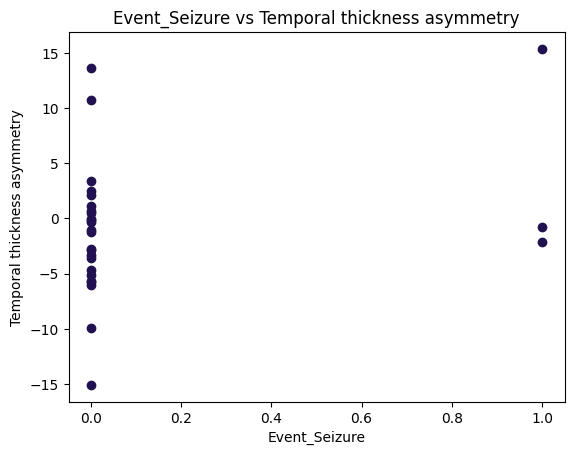

<Figure size 640x480 with 0 Axes>

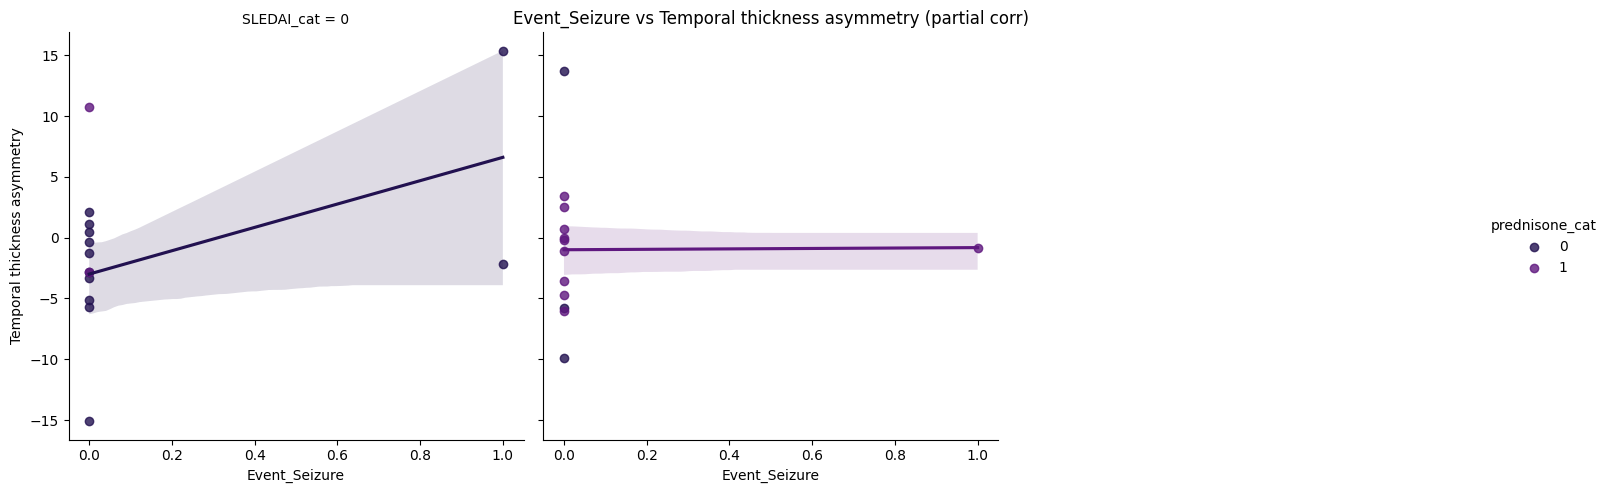

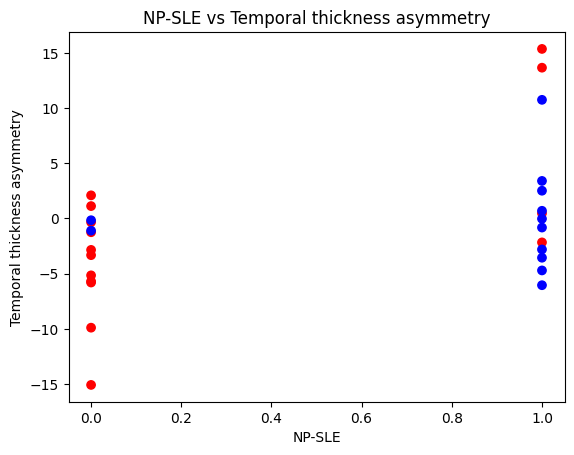

<Figure size 640x480 with 0 Axes>

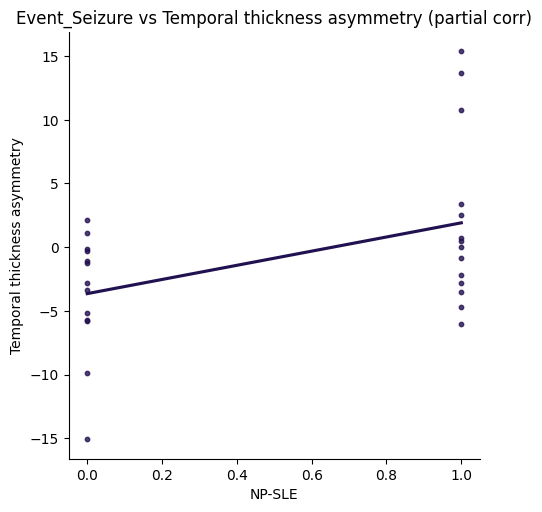

Event_Seizure, ACS, myelitis, CVA vs Temporal thickness asymmetry: r = 0.45, p = 0.02
Event_Seizure, ACS, myelitis, CVA vs Temporal thickness asymmetry (partial corr): r = 0.57, p = 0.00
total_neurocog vs Temporal thickness asymmetry: r = 0.44, p = 0.02
NP-SLE vs Temporal thickness asymmetry (partial corr): r = 0.48, p = 0.02


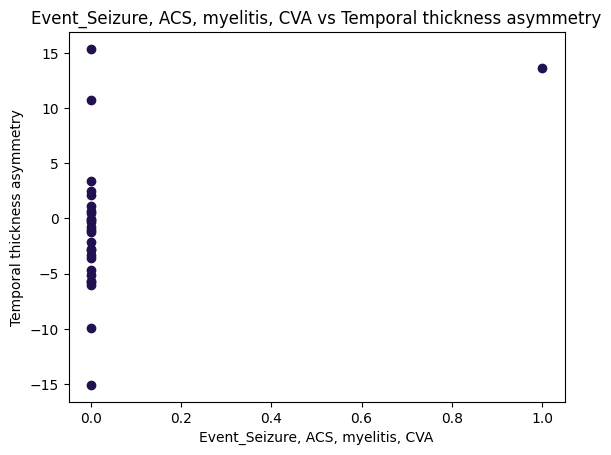

<Figure size 640x480 with 0 Axes>

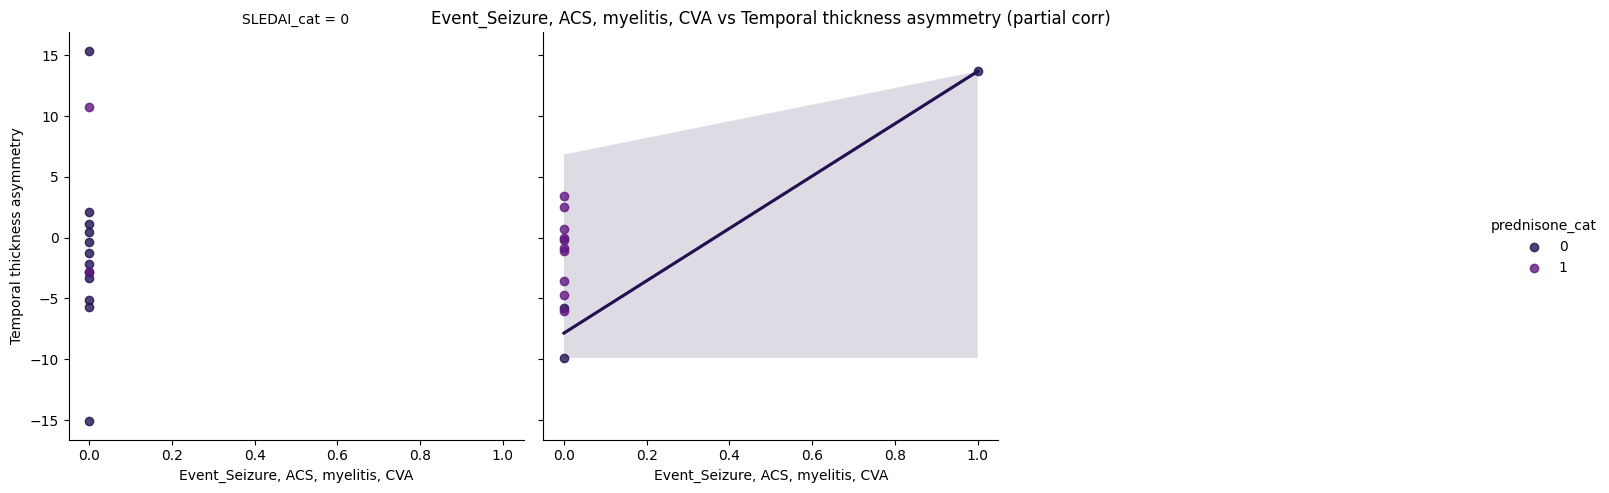

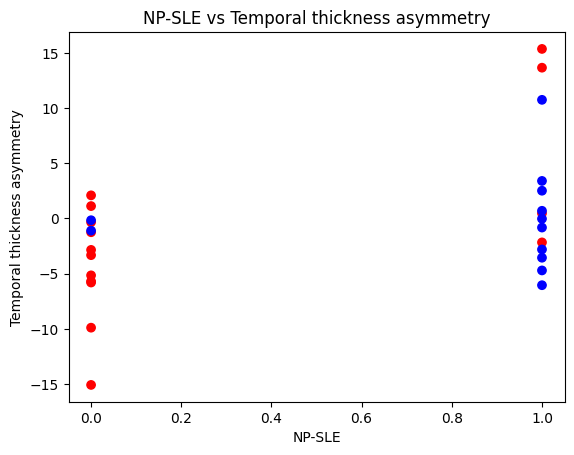

<Figure size 640x480 with 0 Axes>

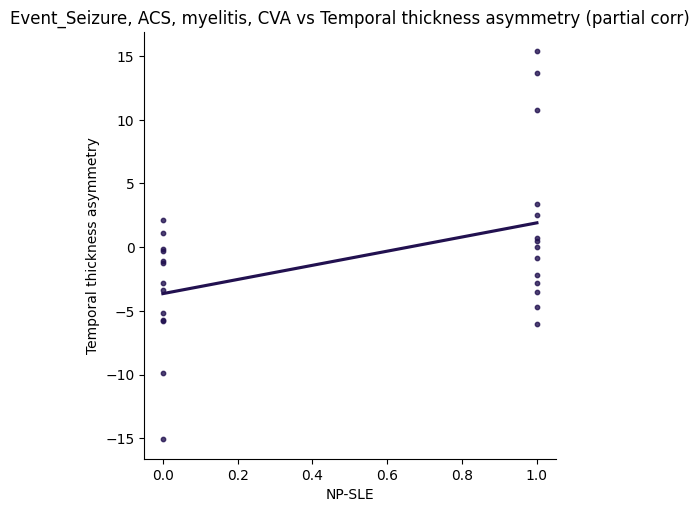

Temporal thickness asymmetry vs Temporal thickness asymmetry: r = 1.00, p = 0.00
total_neurocog vs Temporal thickness asymmetry: r = 0.44, p = 0.02
NP-SLE vs Temporal thickness asymmetry (partial corr): r = 0.48, p = 0.02


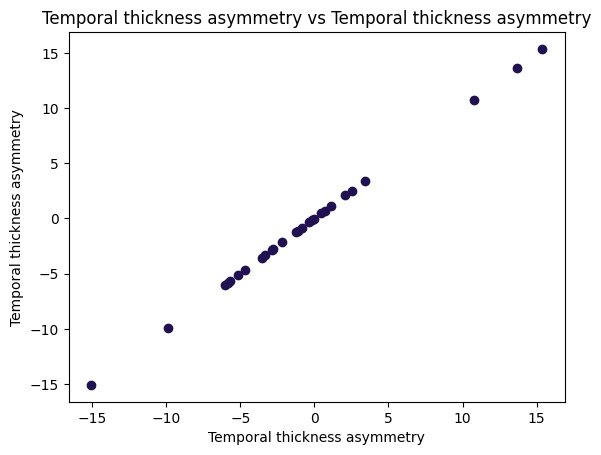

<Figure size 640x480 with 0 Axes>

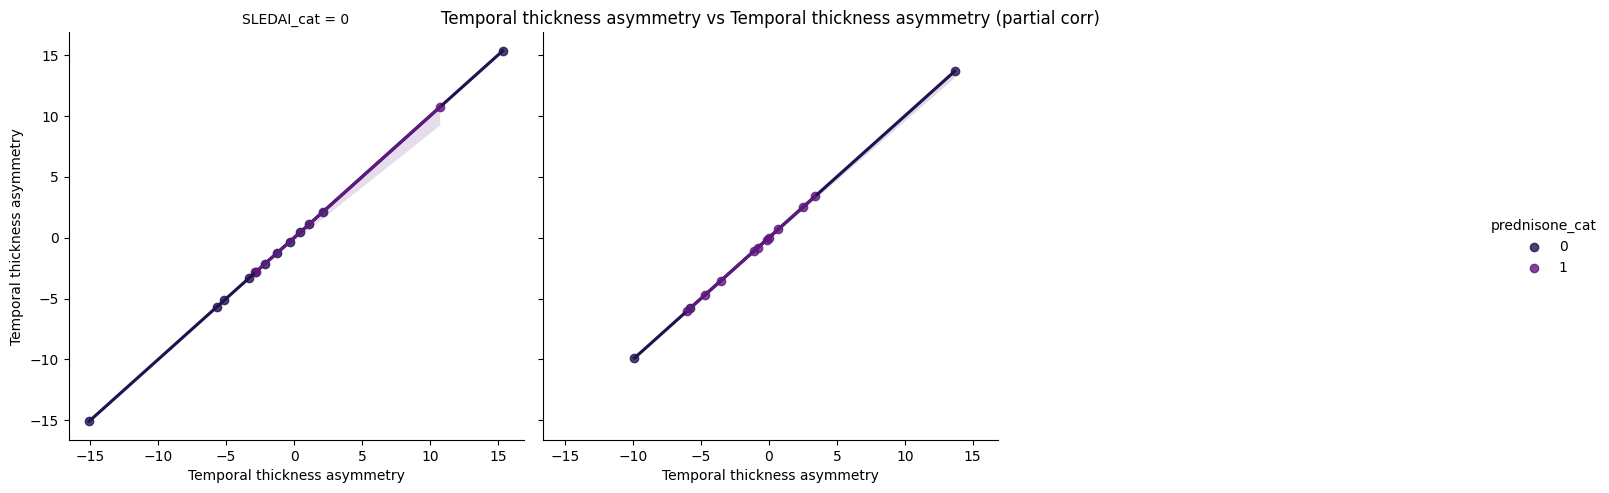

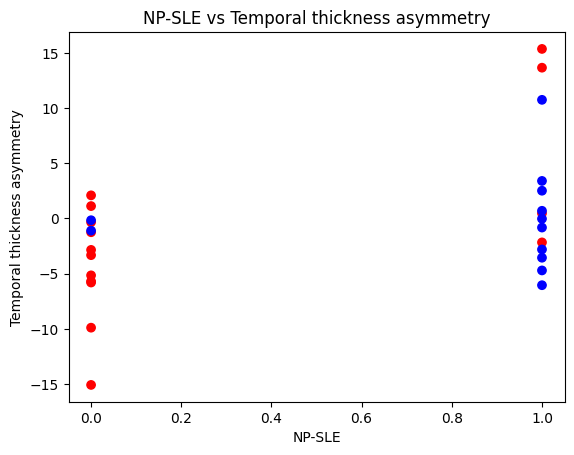

<Figure size 640x480 with 0 Axes>

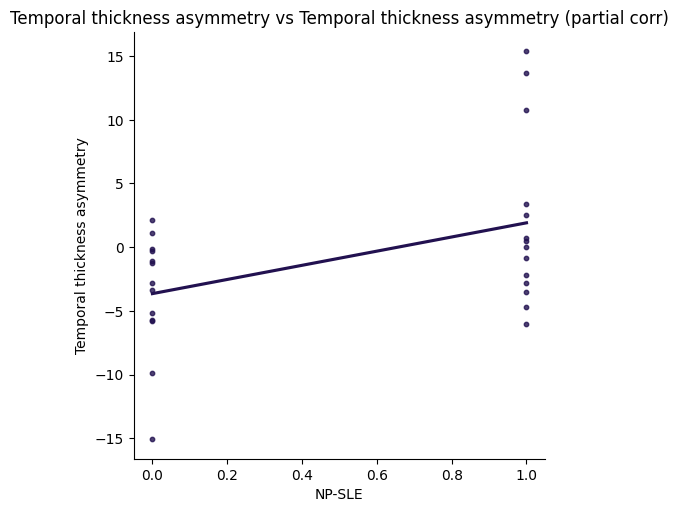

In [9]:
from scipy.stats import pearsonr
import pingouin as pg

df['SLEDAI_cat'] = np.where(df['SLEDAI-2k (at the time of NP event)'] > df['SLEDAI-2k (at the time of NP event)'].median(), 1, 0)
df['prednisone_cat'] = np.where(df['Prednisone  (mg equivalent)'] > df['Prednisone  (mg equivalent)'].median(), 1, 0)
# Define the variables
neurocog_cols = ['Event_CVA', 'Event_Mood abnormalities (depressive)', 'Event_Mood abnormalities (mixed)', 'Event_Movement Disorder', 'Event_Psychosis','Event_Seizure','Event_Seizure, ACS, myelitis, CVA']
lesion_load = 'Temporal thickness asymmetry'
prednisone = 'prednisone_cat'
sledai = 'SLEDAI_cat'

# Compute the correlations
for col in neurocog_cols + [lesion_load]:
    # Compute the Pearson correlation between each neurocognitive domain and lesion load
    r, p = pearsonr(df[col], df[lesion_load])
    print(f'{col} vs {lesion_load}: r = {r:.2f}, p = {p:.2f}')

    # Compute the partial correlation adjusting for prednisone and SLEDAI
    if col != lesion_load:
        partial_corr_results = pg.partial_corr(data=df, x=col, y=lesion_load, covar=[prednisone, sledai])
        r_partial, p_partial = partial_corr_results['r'][0], partial_corr_results['p-val'][0]
        print(f'{col} vs {lesion_load} (partial corr): r = {r_partial:.2f}, p = {p_partial:.2f}')
        assert abs(r - r_partial) > 1e-10, f'{col} and {lesion_load} are perfectly correlated'

    # Compute the Pearson correlation between total neurocognitive score and lesion load
    r_total, p_total = pearsonr(df['NP-SLE'], df[lesion_load])
    print(f'total_neurocog vs {lesion_load}: r = {r_total:.2f}, p = {p_total:.2f}')

    # Compute the partial correlation adjusting for prednisone and SLEDAI
    total_partial_results = pg.partial_corr(data=df, x='NP-SLE', y=lesion_load, covar=[prednisone, sledai])
    r_total_partial, p_total_partial = total_partial_results['r'][0], total_partial_results['p-val'][0]
    print(f'NP-SLE vs {lesion_load} (partial corr): r = {r_total_partial:.2f}, p = {p_total_partial:.2f}')


    # Plot the scatter plot
    plt.figure()
    plt.scatter(df[col], df[lesion_load])
    plt.xlabel(col)
    plt.ylabel(lesion_load)
    plt.title(f'{col} vs {lesion_load}')
    plt.show()

    # Plot the partial scatter plot
    plt.figure()
    sns.lmplot(data=df, x=col, y=lesion_load, hue=prednisone, col=sledai, col_wrap=3)
    plt.title(f'{col} vs {lesion_load} (partial corr)')
    plt.show()
    
    colors = ['red' if p == 0 else 'blue' for p in df[prednisone]]
    # Plot the scatter plot of total neurocognitive score vs lesion load
    plt.figure()
    plt.scatter(df['NP-SLE'], df[lesion_load], c=colors)
    plt.xlabel('NP-SLE')
    plt.ylabel(lesion_load)
    plt.title(f'NP-SLE vs {lesion_load}')
    plt.show()

    # Plot the partial scatter plot of total neurocognitive score vs lesion load
    plt.figure()
    sns.lmplot(data=df, x='NP-SLE', y=lesion_load, ci=None, scatter_kws={"s": 10})
    plt.title(f'{col} vs {lesion_load} (partial corr)')
    plt.show()

Event_CVA vs TMP thickness asymmetry: r = 0.51, p = 0.01
Event_CVA vs TMP thickness asymmetry (partial corr): r = 0.57, p = 0.00
total_neurocog vs TMP thickness asymmetry: r = 0.43, p = 0.03
NP-SLE vs TMP thickness asymmetry (partial corr): r = 0.44, p = 0.03


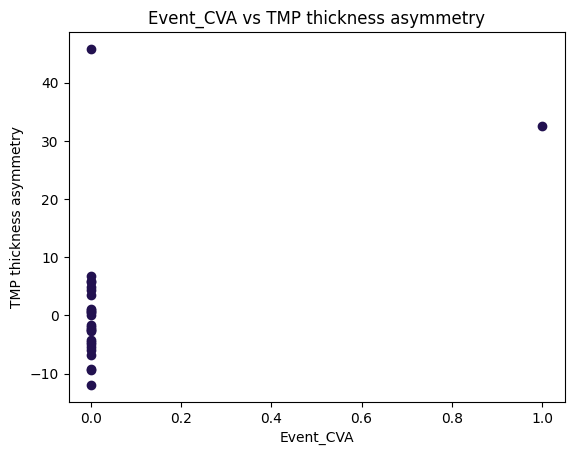

<Figure size 640x480 with 0 Axes>

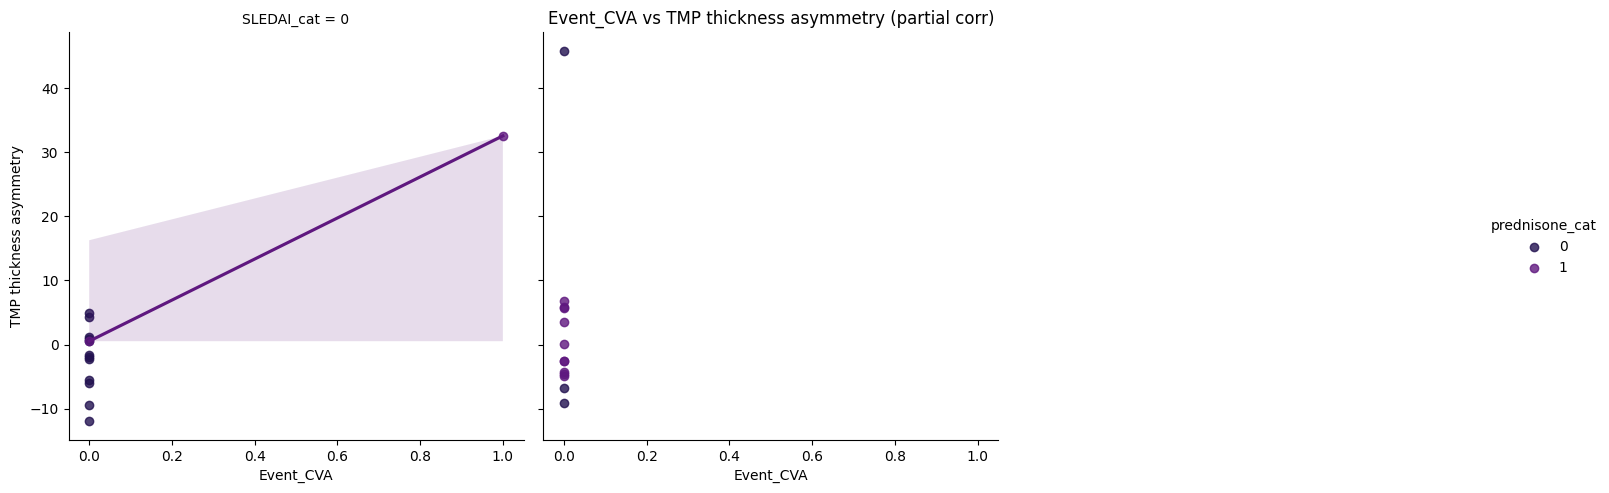

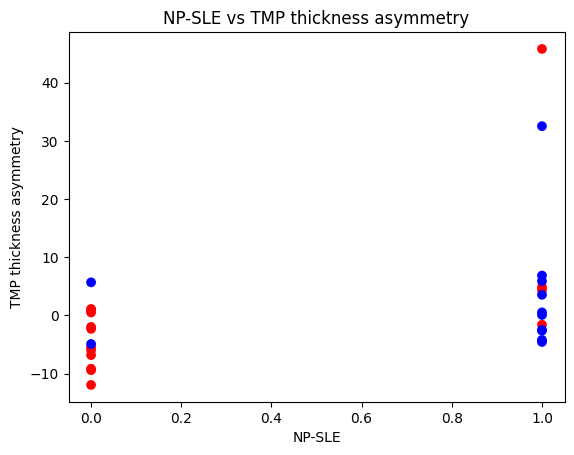

<Figure size 640x480 with 0 Axes>

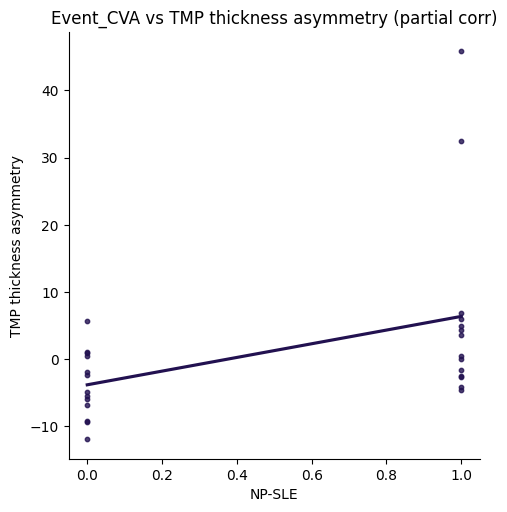

Event_Mood abnormalities (depressive) vs TMP thickness asymmetry: r = 0.05, p = 0.82
Event_Mood abnormalities (depressive) vs TMP thickness asymmetry (partial corr): r = 0.00, p = 0.99
total_neurocog vs TMP thickness asymmetry: r = 0.43, p = 0.03
NP-SLE vs TMP thickness asymmetry (partial corr): r = 0.44, p = 0.03


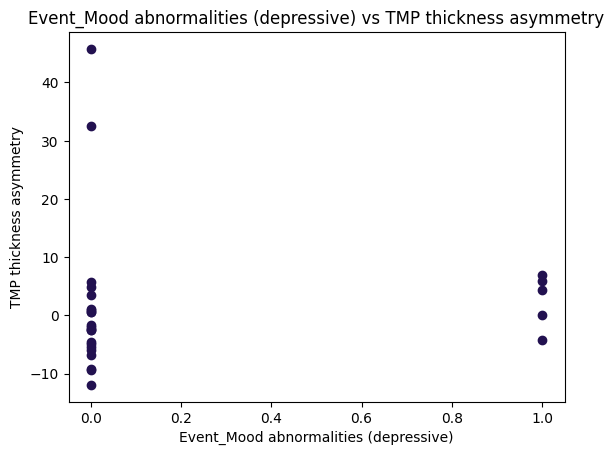

<Figure size 640x480 with 0 Axes>

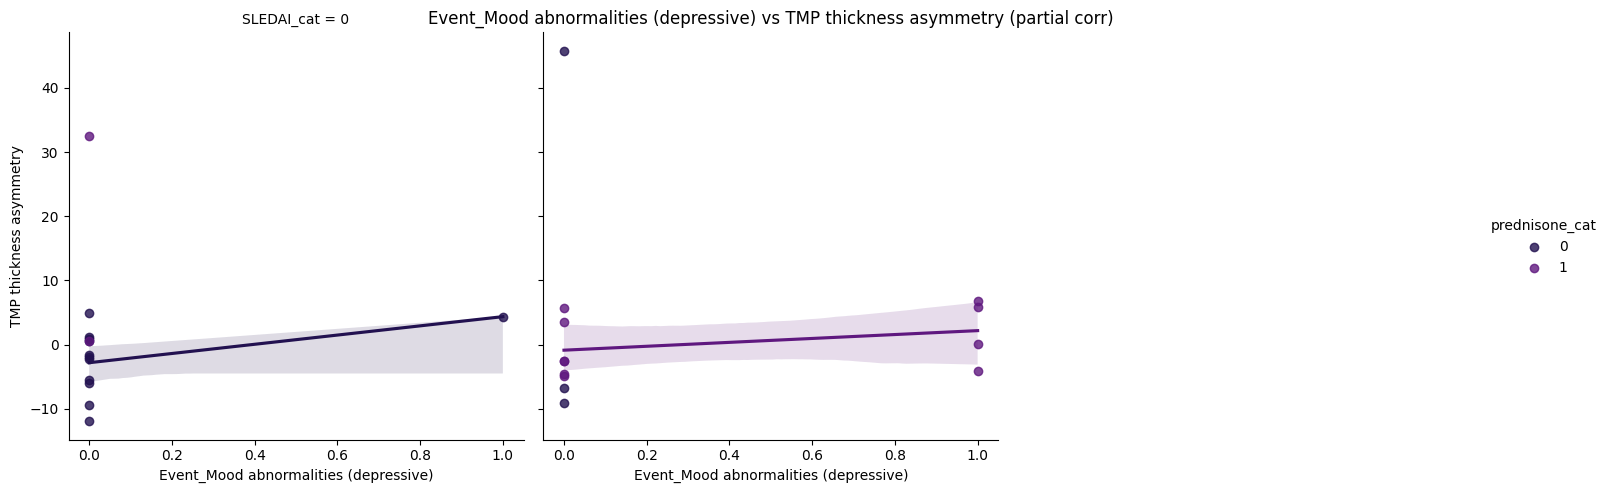

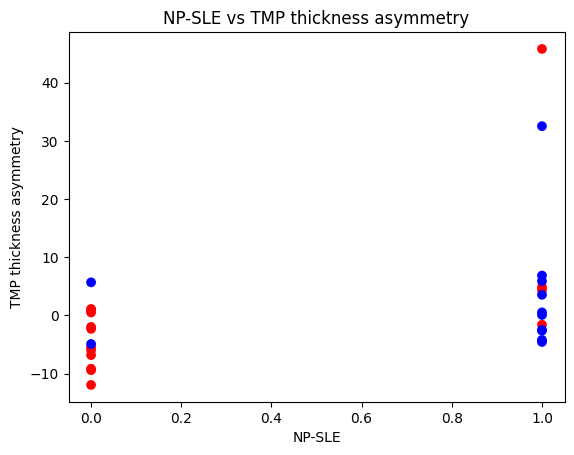

<Figure size 640x480 with 0 Axes>

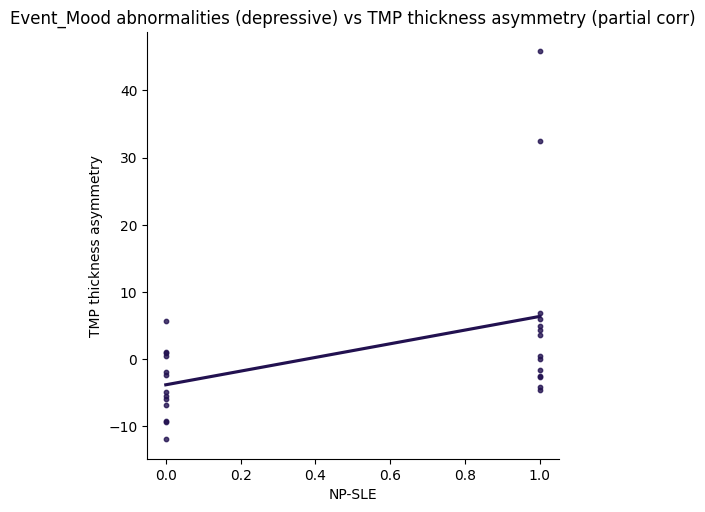

Event_Mood abnormalities (mixed) vs TMP thickness asymmetry: r = -0.07, p = 0.75
Event_Mood abnormalities (mixed) vs TMP thickness asymmetry (partial corr): r = -0.10, p = 0.65
total_neurocog vs TMP thickness asymmetry: r = 0.43, p = 0.03
NP-SLE vs TMP thickness asymmetry (partial corr): r = 0.44, p = 0.03


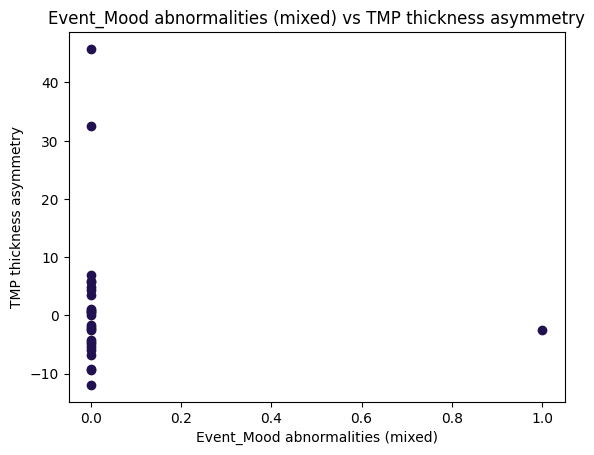

<Figure size 640x480 with 0 Axes>

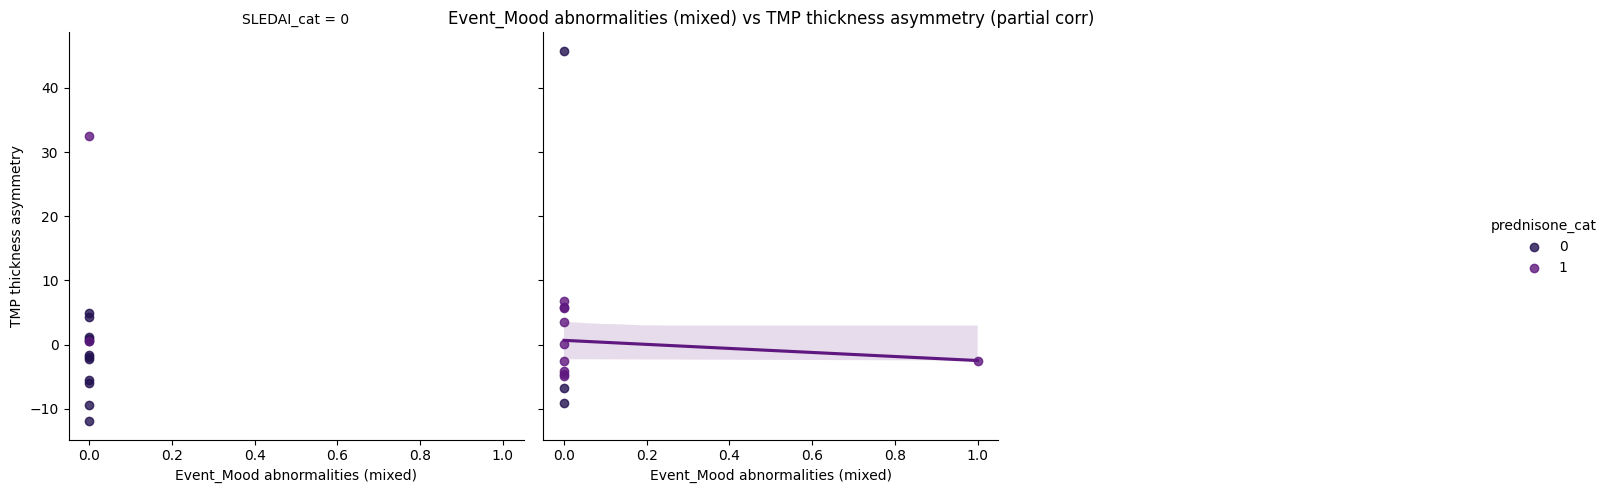

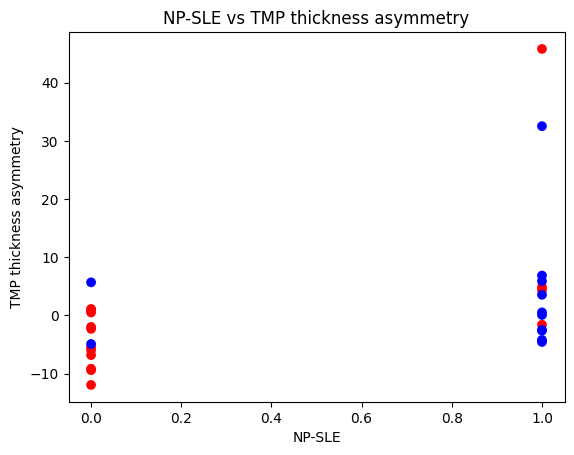

<Figure size 640x480 with 0 Axes>

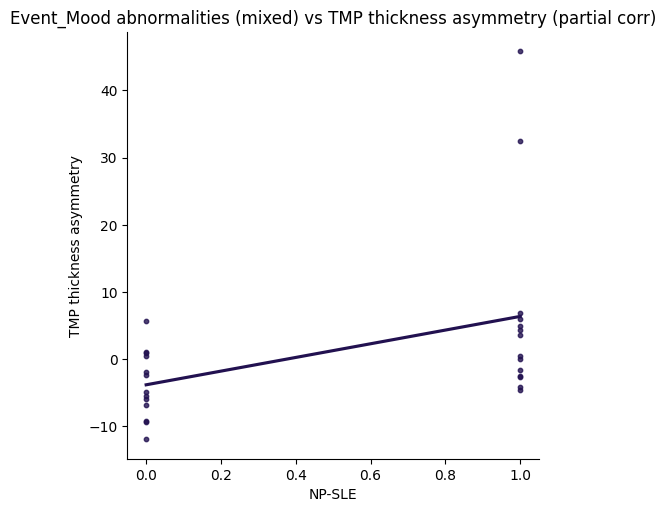

Event_Movement Disorder vs TMP thickness asymmetry: r = -0.10, p = 0.62
Event_Movement Disorder vs TMP thickness asymmetry (partial corr): r = -0.13, p = 0.53
total_neurocog vs TMP thickness asymmetry: r = 0.43, p = 0.03
NP-SLE vs TMP thickness asymmetry (partial corr): r = 0.44, p = 0.03


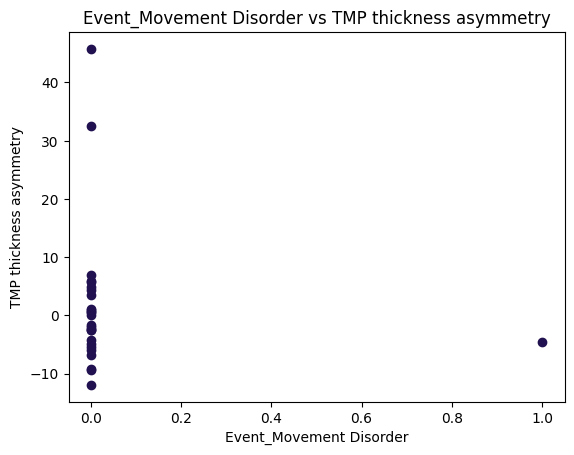

<Figure size 640x480 with 0 Axes>

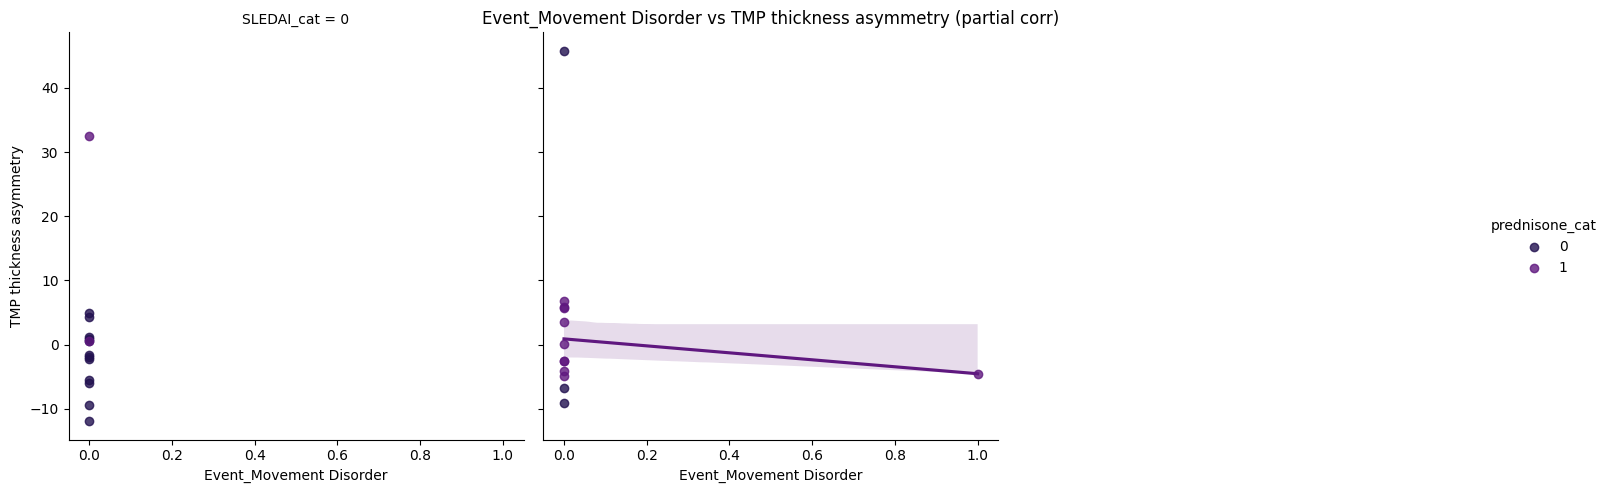

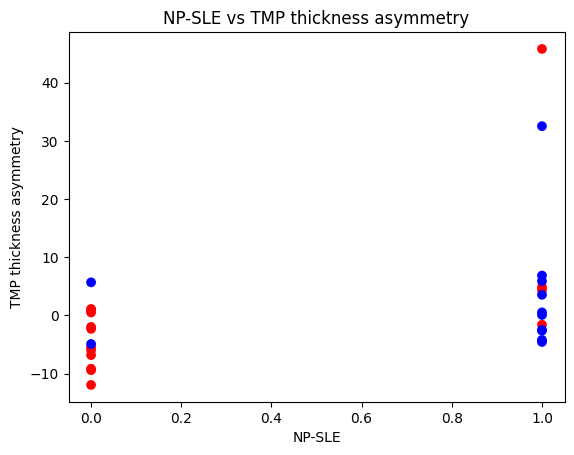

<Figure size 640x480 with 0 Axes>

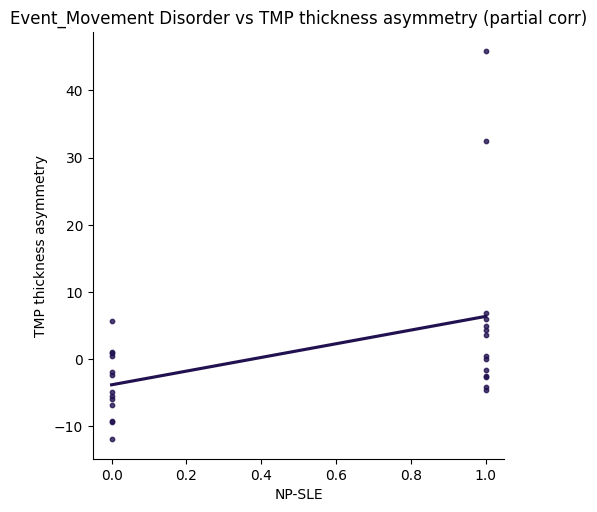

Event_Psychosis vs TMP thickness asymmetry: r = -0.06, p = 0.77
Event_Psychosis vs TMP thickness asymmetry (partial corr): r = -0.10, p = 0.63
total_neurocog vs TMP thickness asymmetry: r = 0.43, p = 0.03
NP-SLE vs TMP thickness asymmetry (partial corr): r = 0.44, p = 0.03


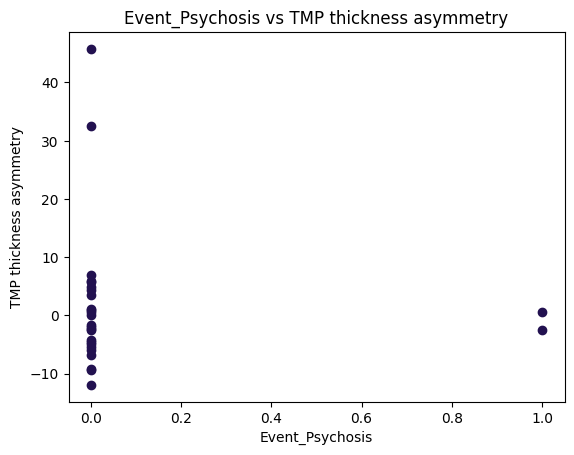

<Figure size 640x480 with 0 Axes>

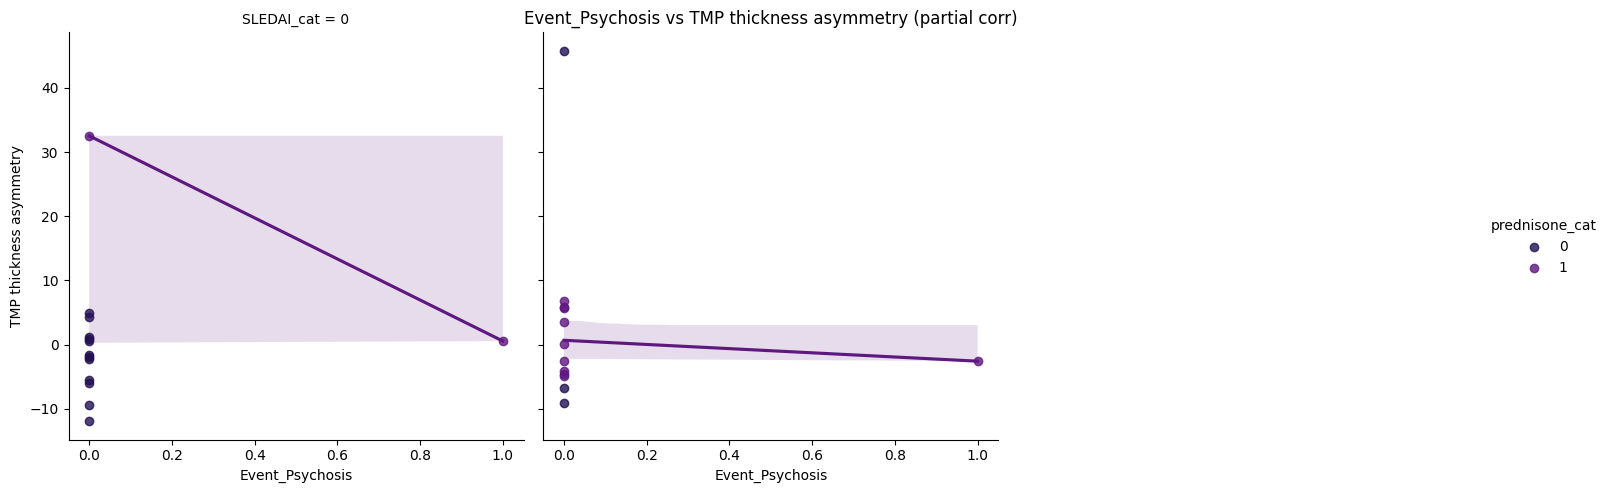

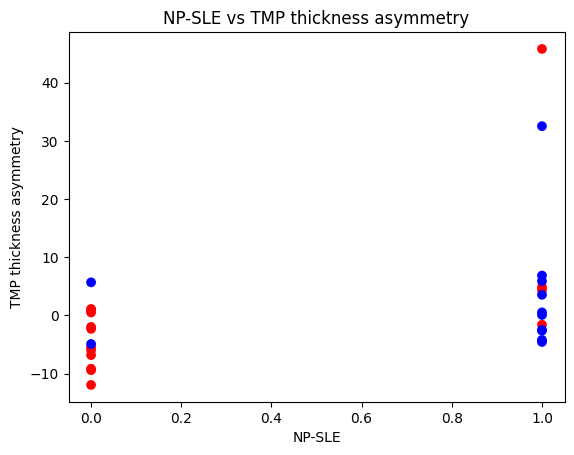

<Figure size 640x480 with 0 Axes>

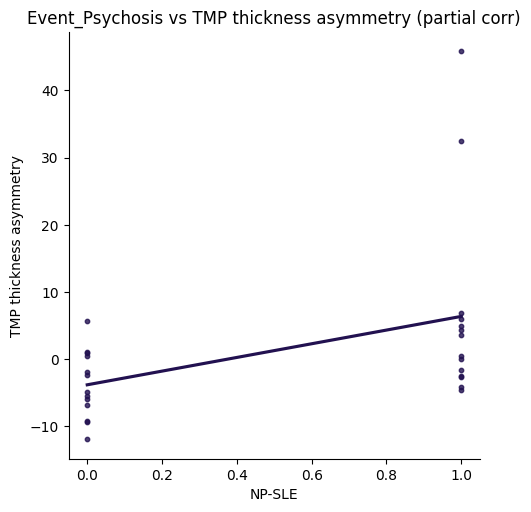

Event_Seizure vs TMP thickness asymmetry: r = 0.02, p = 0.90
Event_Seizure vs TMP thickness asymmetry (partial corr): r = 0.04, p = 0.87
total_neurocog vs TMP thickness asymmetry: r = 0.43, p = 0.03
NP-SLE vs TMP thickness asymmetry (partial corr): r = 0.44, p = 0.03


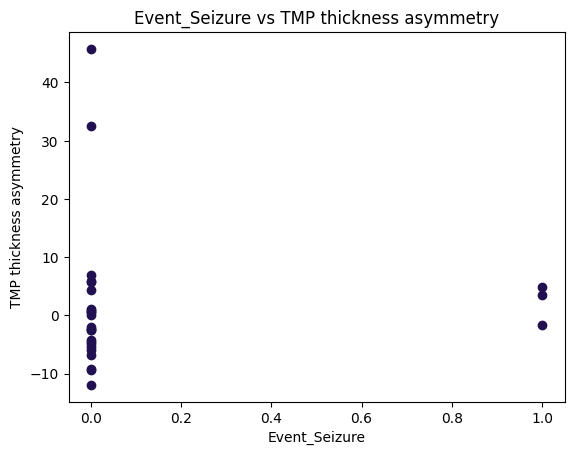

<Figure size 640x480 with 0 Axes>

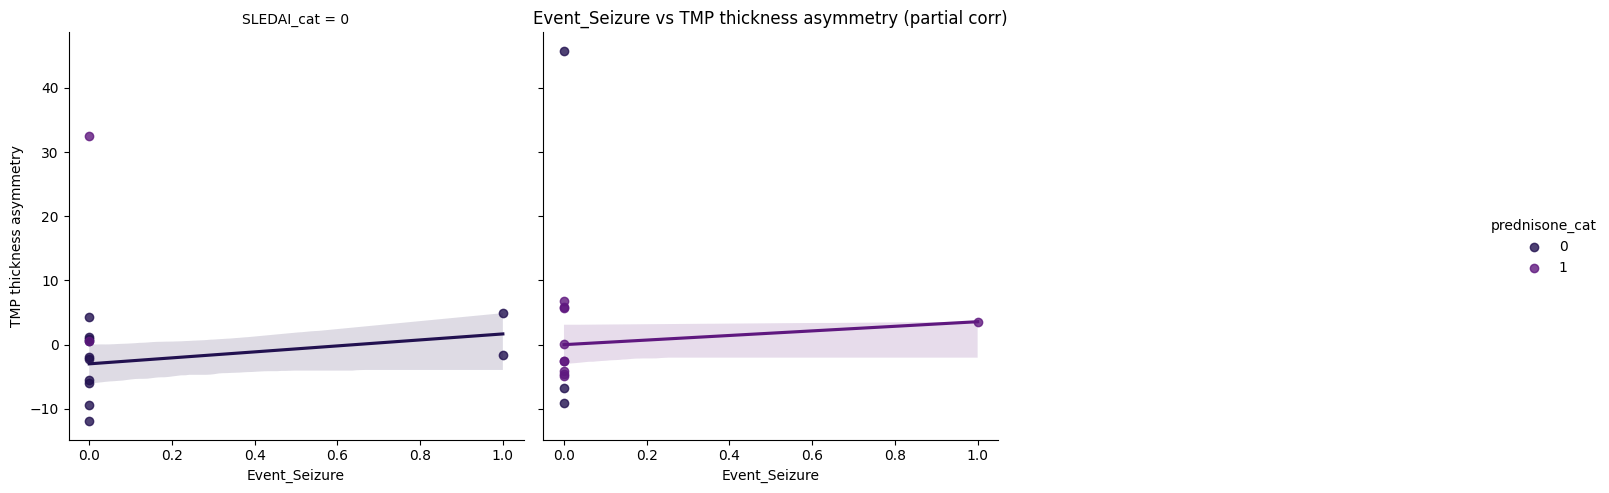

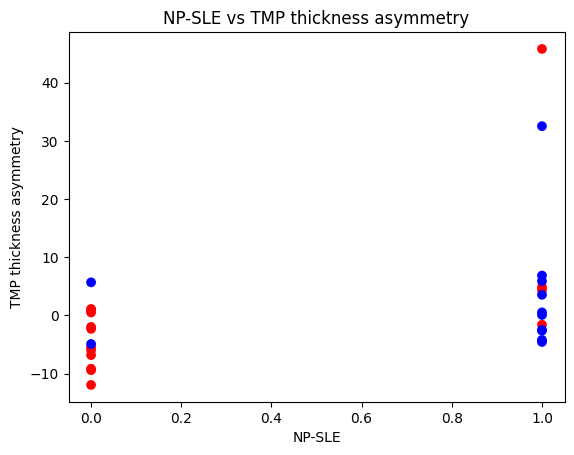

<Figure size 640x480 with 0 Axes>

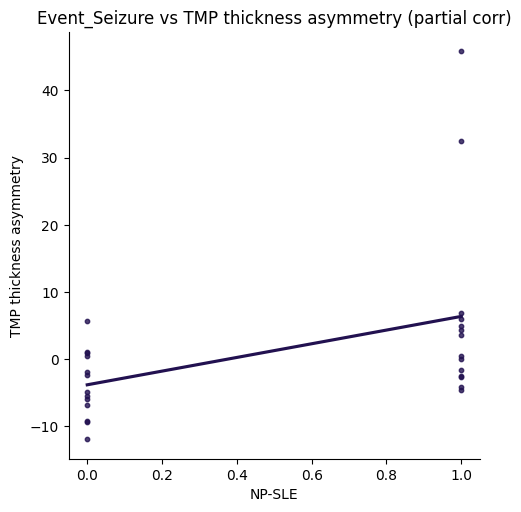

Event_Seizure, ACS, myelitis, CVA vs TMP thickness asymmetry: r = 0.73, p = 0.00
Event_Seizure, ACS, myelitis, CVA vs TMP thickness asymmetry (partial corr): r = 0.84, p = 0.00
total_neurocog vs TMP thickness asymmetry: r = 0.43, p = 0.03
NP-SLE vs TMP thickness asymmetry (partial corr): r = 0.44, p = 0.03


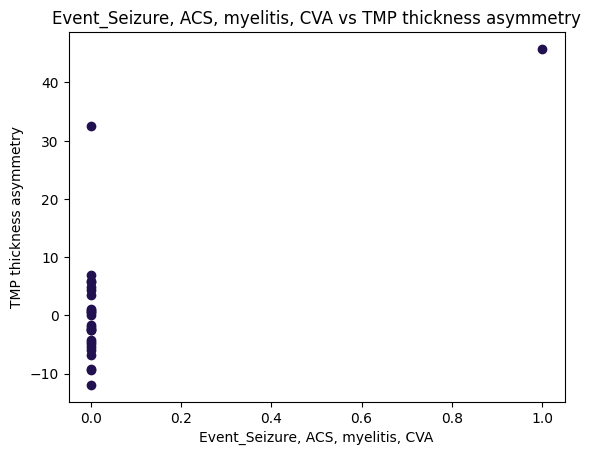

<Figure size 640x480 with 0 Axes>

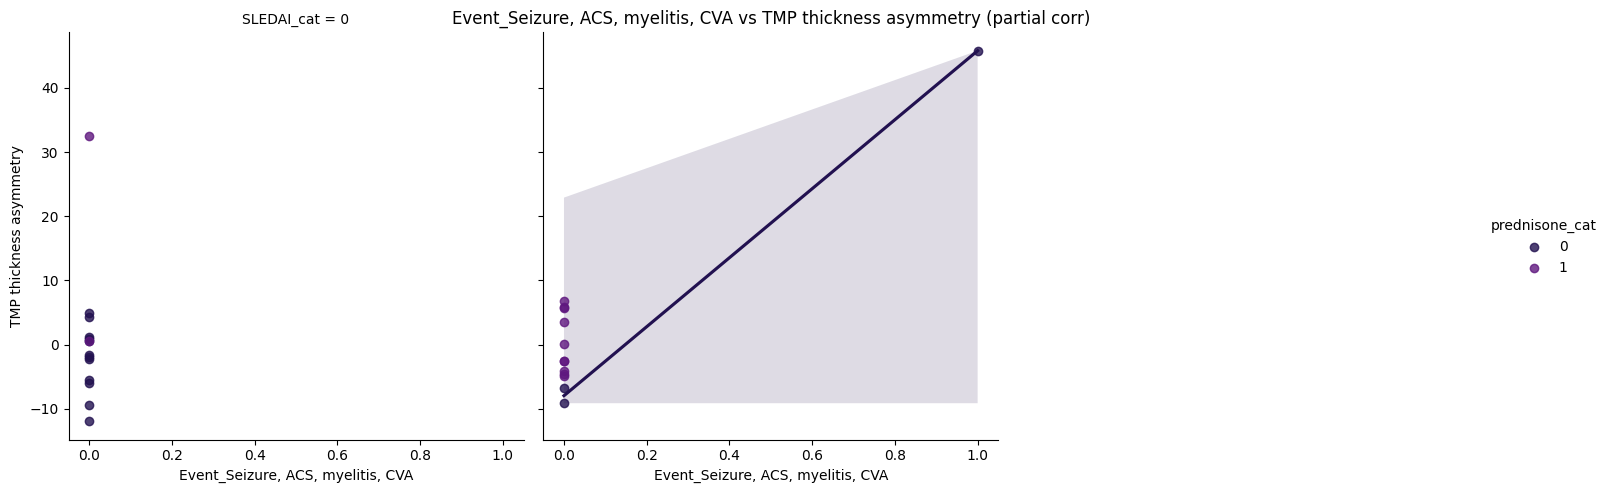

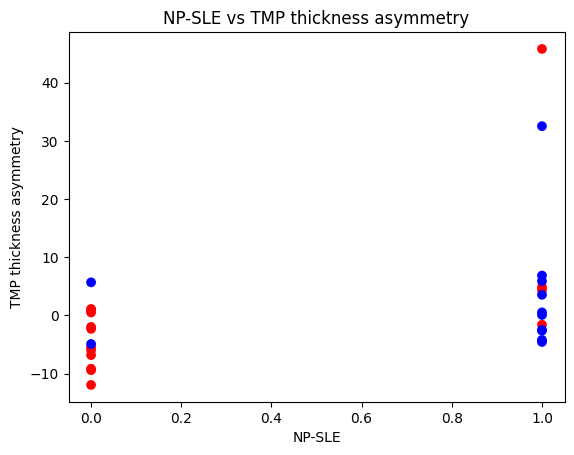

<Figure size 640x480 with 0 Axes>

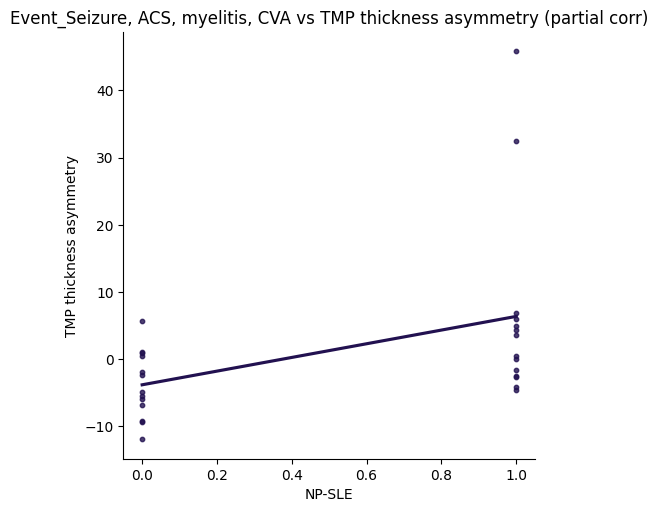

TMP thickness asymmetry vs TMP thickness asymmetry: r = 1.00, p = 0.00
total_neurocog vs TMP thickness asymmetry: r = 0.43, p = 0.03
NP-SLE vs TMP thickness asymmetry (partial corr): r = 0.44, p = 0.03


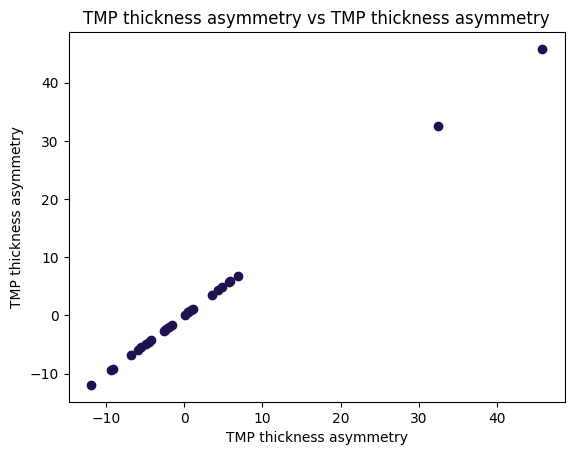

<Figure size 640x480 with 0 Axes>

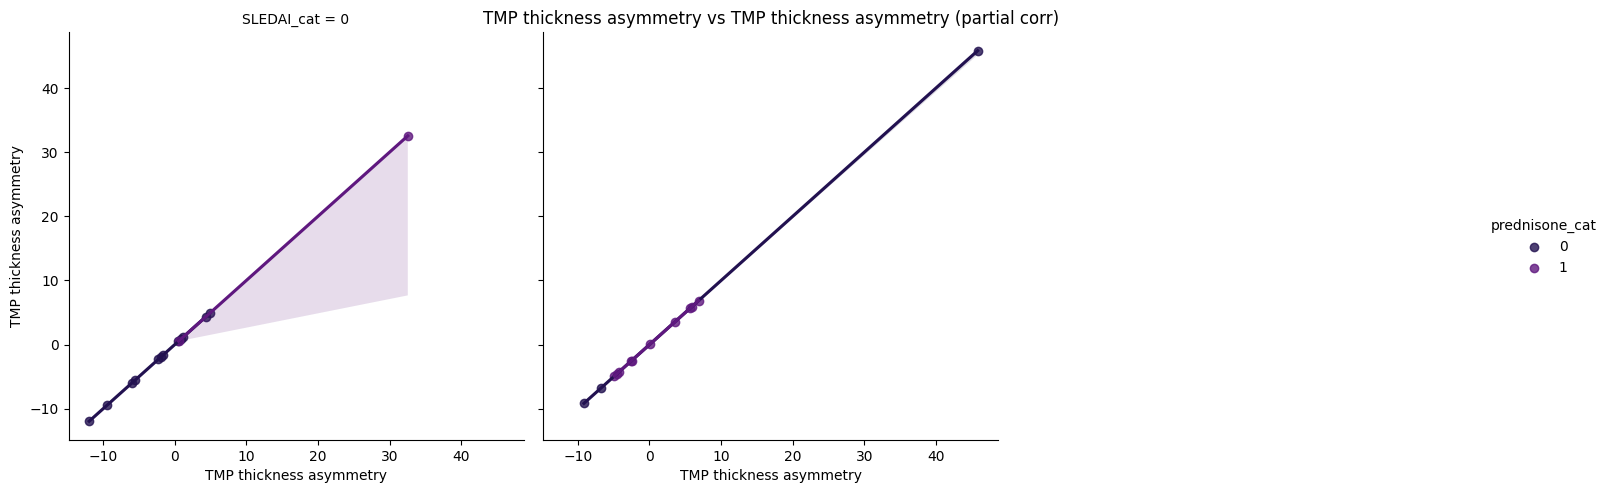

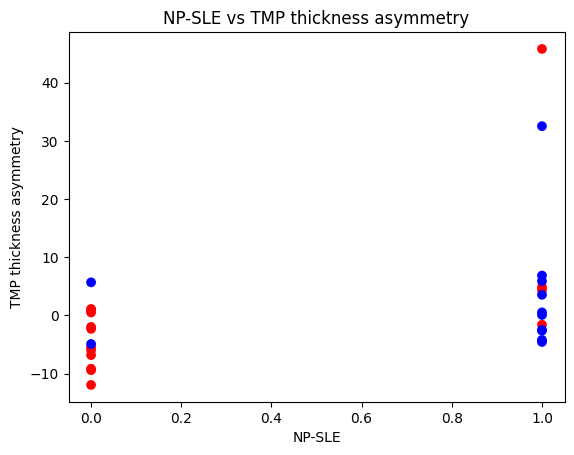

<Figure size 640x480 with 0 Axes>

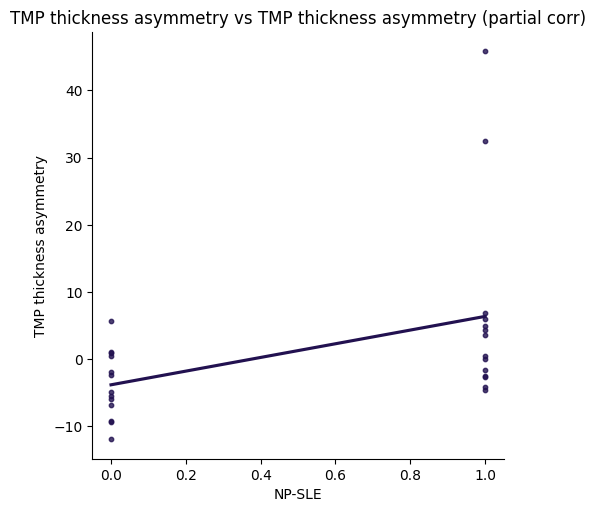

In [10]:
from scipy.stats import pearsonr
import pingouin as pg

df['SLEDAI_cat'] = np.where(df['SLEDAI-2k (at the time of NP event)'] > df['SLEDAI-2k (at the time of NP event)'].median(), 1, 0)
df['prednisone_cat'] = np.where(df['Prednisone  (mg equivalent)'] > df['Prednisone  (mg equivalent)'].median(), 1, 0)
# Define the variables
neurocog_cols = ['Event_CVA', 'Event_Mood abnormalities (depressive)', 'Event_Mood abnormalities (mixed)', 'Event_Movement Disorder', 'Event_Psychosis','Event_Seizure','Event_Seizure, ACS, myelitis, CVA']
lesion_load = 'TMP thickness asymmetry'
prednisone = 'prednisone_cat'
sledai = 'SLEDAI_cat'

# Compute the correlations
for col in neurocog_cols + [lesion_load]:
    # Compute the Pearson correlation between each neurocognitive domain and lesion load
    r, p = pearsonr(df[col], df[lesion_load])
    print(f'{col} vs {lesion_load}: r = {r:.2f}, p = {p:.2f}')

    # Compute the partial correlation adjusting for prednisone and SLEDAI
    if col != lesion_load:
        partial_corr_results = pg.partial_corr(data=df, x=col, y=lesion_load, covar=[prednisone, sledai])
        r_partial, p_partial = partial_corr_results['r'][0], partial_corr_results['p-val'][0]
        print(f'{col} vs {lesion_load} (partial corr): r = {r_partial:.2f}, p = {p_partial:.2f}')
        assert abs(r - r_partial) > 1e-10, f'{col} and {lesion_load} are perfectly correlated'

    # Compute the Pearson correlation between total neurocognitive score and lesion load
    r_total, p_total = pearsonr(df['NP-SLE'], df[lesion_load])
    print(f'total_neurocog vs {lesion_load}: r = {r_total:.2f}, p = {p_total:.2f}')

    # Compute the partial correlation adjusting for prednisone and SLEDAI
    total_partial_results = pg.partial_corr(data=df, x='NP-SLE', y=lesion_load, covar=[prednisone, sledai])
    r_total_partial, p_total_partial = total_partial_results['r'][0], total_partial_results['p-val'][0]
    print(f'NP-SLE vs {lesion_load} (partial corr): r = {r_total_partial:.2f}, p = {p_total_partial:.2f}')


    # Plot the scatter plot
    plt.figure()
    plt.scatter(df[col], df[lesion_load])
    plt.xlabel(col)
    plt.ylabel(lesion_load)
    plt.title(f'{col} vs {lesion_load}')
    plt.show()

    # Plot the partial scatter plot
    plt.figure()
    sns.lmplot(data=df, x=col, y=lesion_load, hue=prednisone, col=sledai, col_wrap=3)
    plt.title(f'{col} vs {lesion_load} (partial corr)')
    plt.show()
    
    colors = ['red' if p == 0 else 'blue' for p in df[prednisone]]
    # Plot the scatter plot of total neurocognitive score vs lesion load
    plt.figure()
    plt.scatter(df['NP-SLE'], df[lesion_load], c=colors)
    plt.xlabel('NP-SLE')
    plt.ylabel(lesion_load)
    plt.title(f'NP-SLE vs {lesion_load}')
    plt.show()

    # Plot the partial scatter plot of total neurocognitive score vs lesion load
    plt.figure()
    sns.lmplot(data=df, x='NP-SLE', y=lesion_load, ci=None, scatter_kws={"s": 10})
    plt.title(f'{col} vs {lesion_load} (partial corr)')
    plt.show()

Event_CVA vs MTG thickness asymmetry: r = 0.13, p = 0.53
Event_CVA vs MTG thickness asymmetry (partial corr): r = 0.12, p = 0.56
total_neurocog vs MTG thickness asymmetry: r = 0.43, p = 0.03
NP-SLE vs MTG thickness asymmetry (partial corr): r = 0.47, p = 0.02


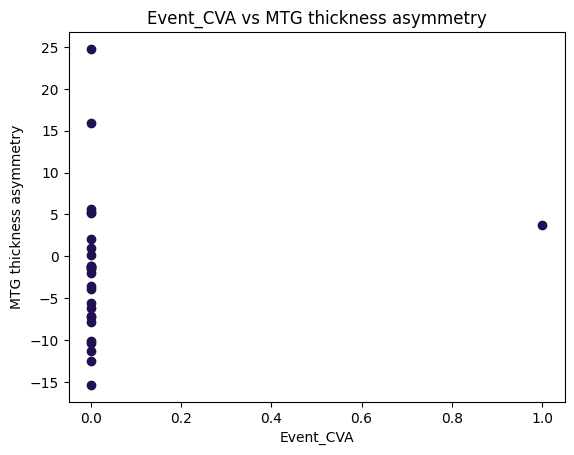

<Figure size 640x480 with 0 Axes>

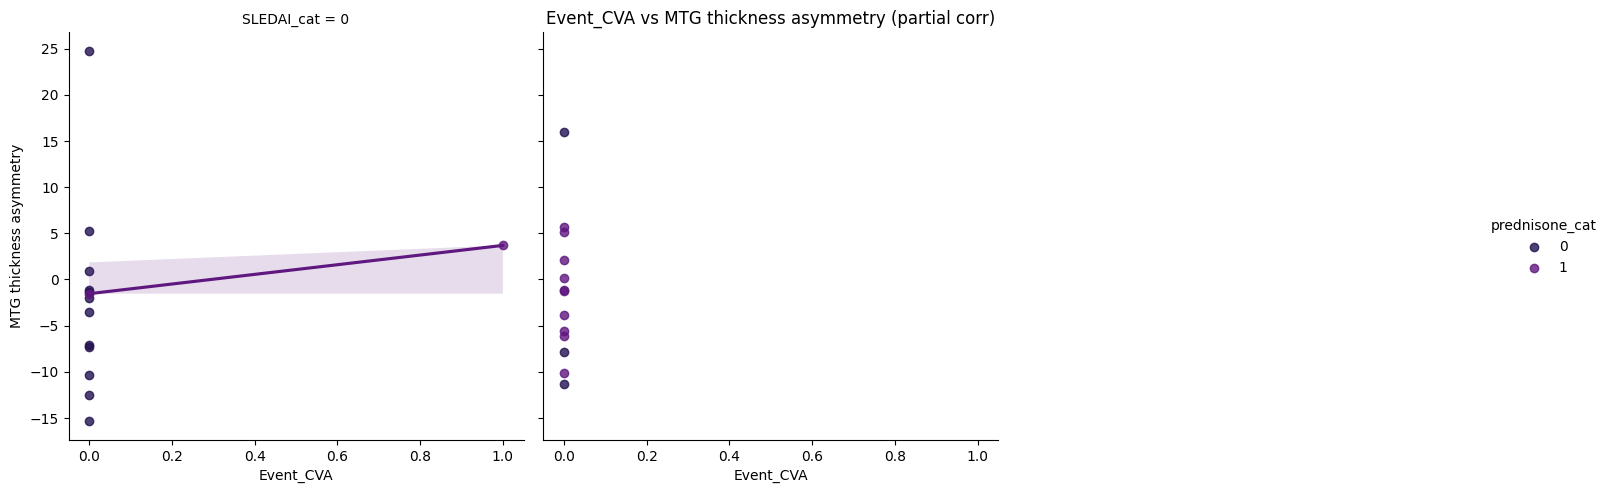

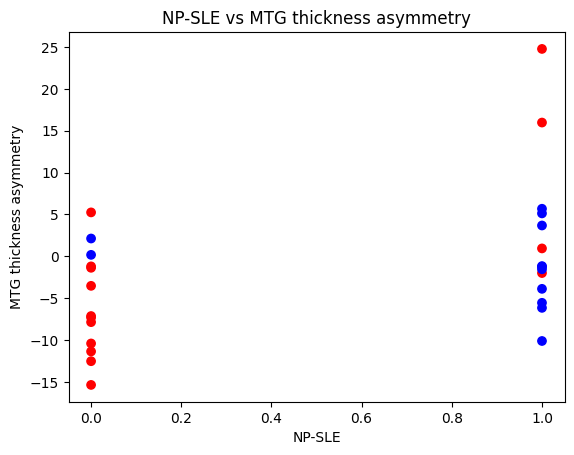

<Figure size 640x480 with 0 Axes>

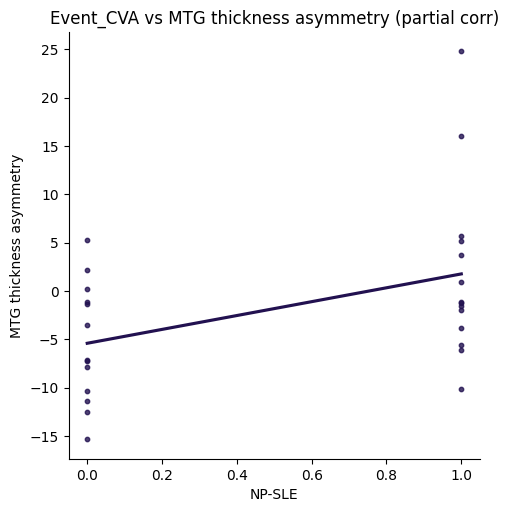

Event_Mood abnormalities (depressive) vs MTG thickness asymmetry: r = 0.05, p = 0.81
Event_Mood abnormalities (depressive) vs MTG thickness asymmetry (partial corr): r = 0.03, p = 0.89
total_neurocog vs MTG thickness asymmetry: r = 0.43, p = 0.03
NP-SLE vs MTG thickness asymmetry (partial corr): r = 0.47, p = 0.02


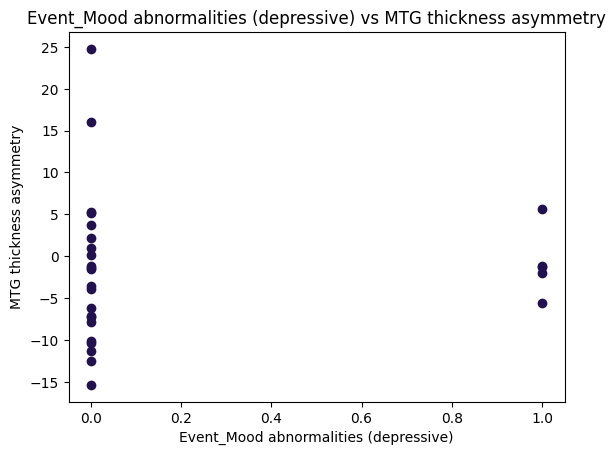

<Figure size 640x480 with 0 Axes>

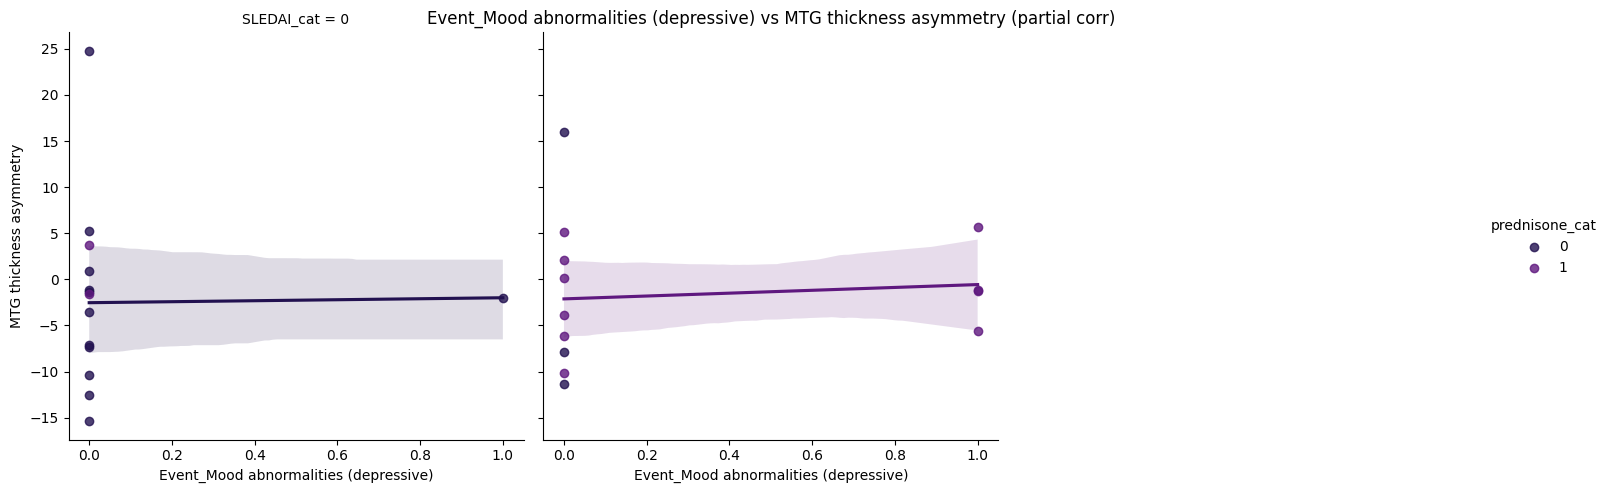

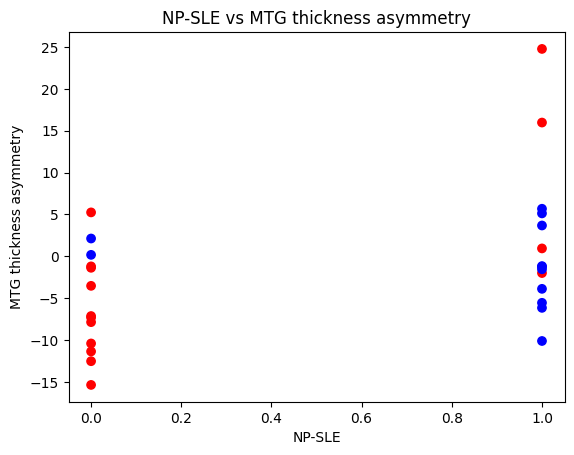

<Figure size 640x480 with 0 Axes>

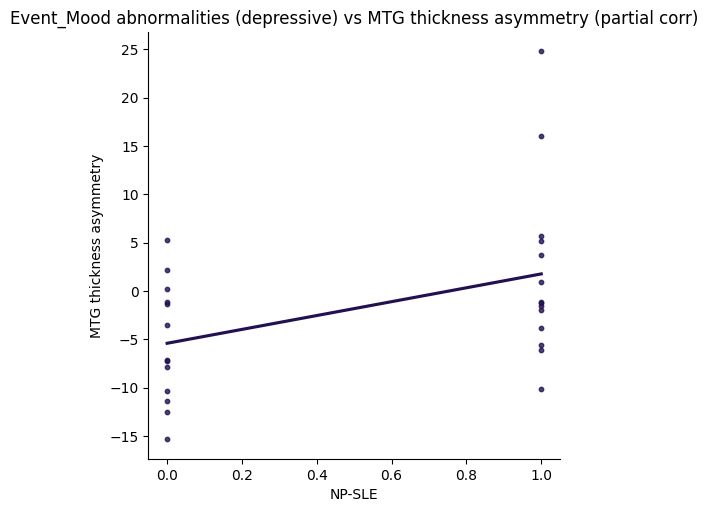

Event_Mood abnormalities (mixed) vs MTG thickness asymmetry: r = -0.10, p = 0.61
Event_Mood abnormalities (mixed) vs MTG thickness asymmetry (partial corr): r = -0.12, p = 0.56
total_neurocog vs MTG thickness asymmetry: r = 0.43, p = 0.03
NP-SLE vs MTG thickness asymmetry (partial corr): r = 0.47, p = 0.02


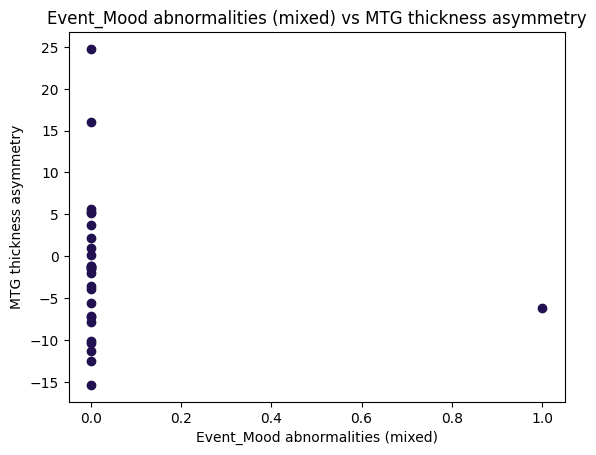

<Figure size 640x480 with 0 Axes>

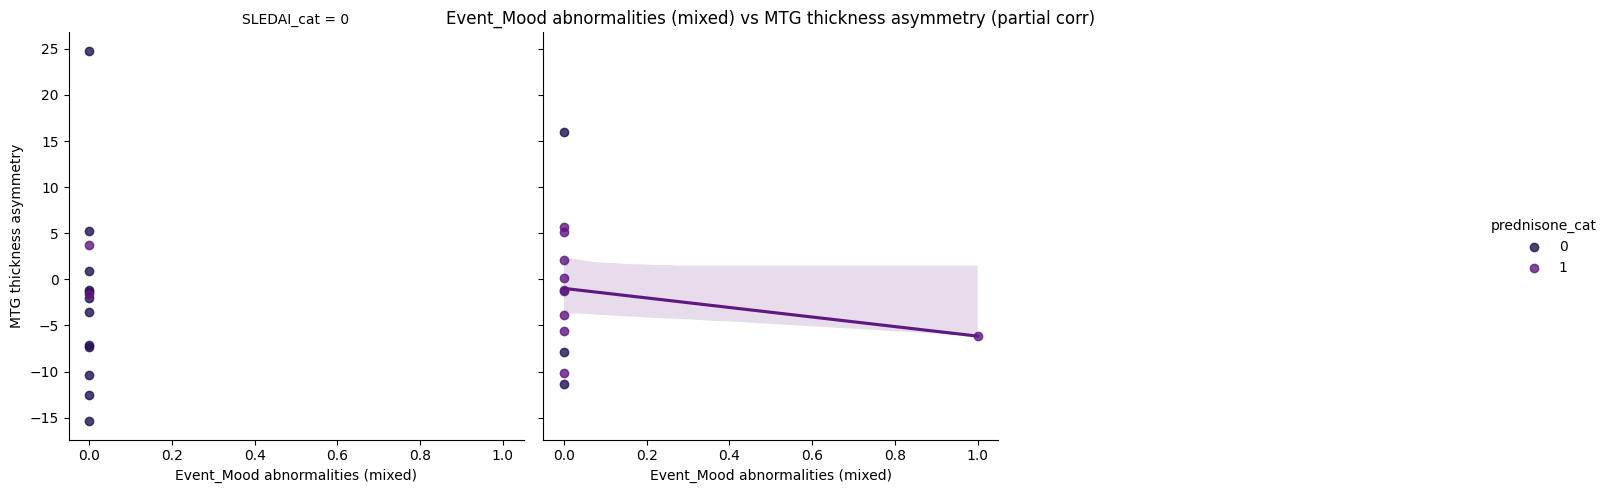

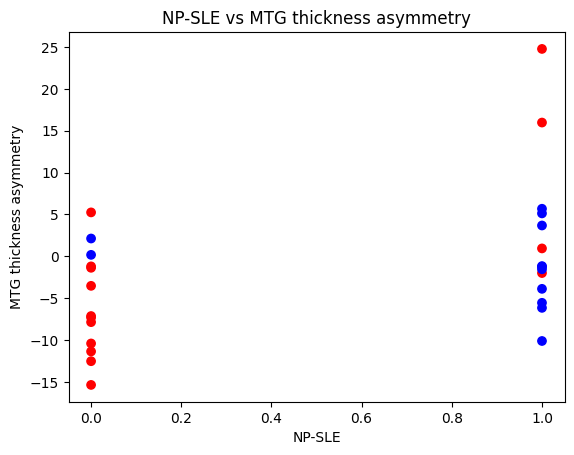

<Figure size 640x480 with 0 Axes>

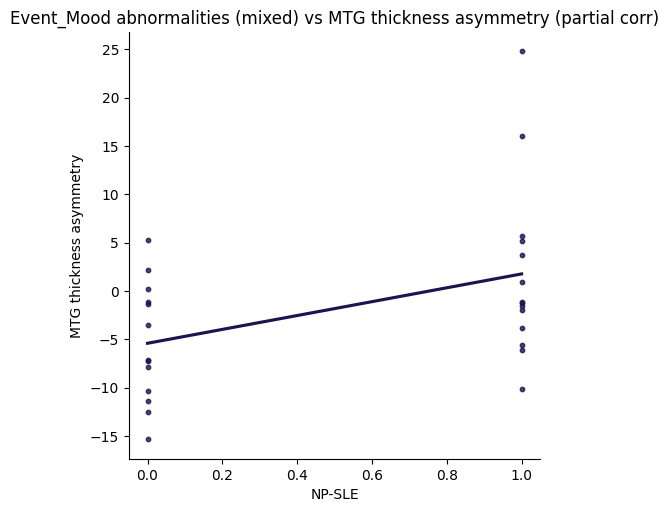

Event_Movement Disorder vs MTG thickness asymmetry: r = 0.16, p = 0.43
Event_Movement Disorder vs MTG thickness asymmetry (partial corr): r = 0.15, p = 0.47
total_neurocog vs MTG thickness asymmetry: r = 0.43, p = 0.03
NP-SLE vs MTG thickness asymmetry (partial corr): r = 0.47, p = 0.02


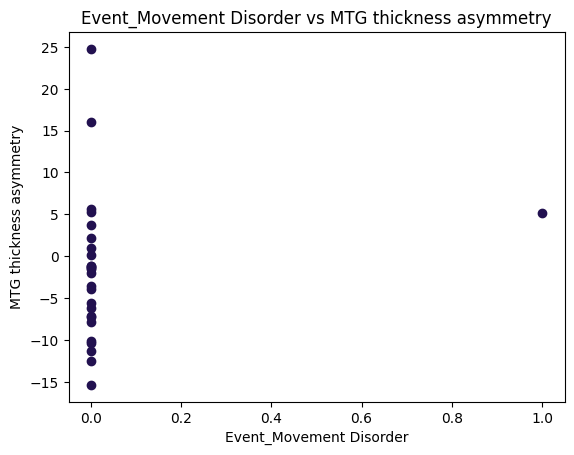

<Figure size 640x480 with 0 Axes>

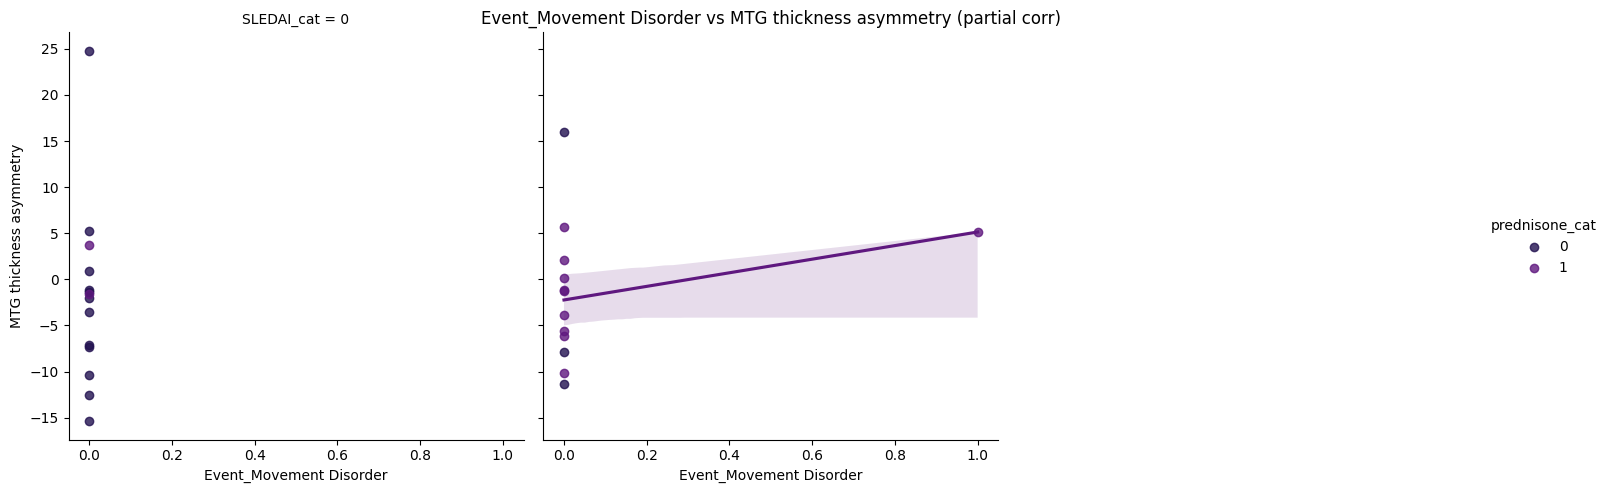

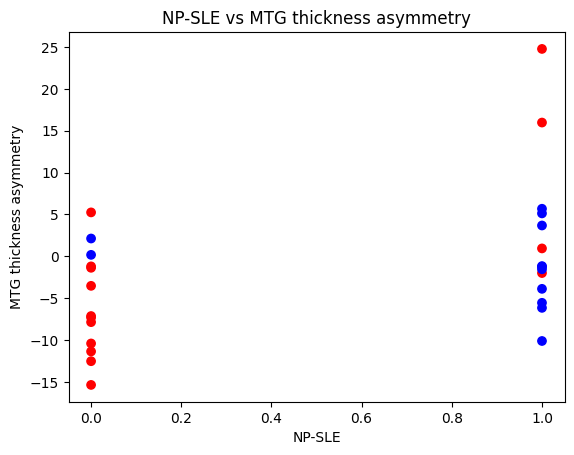

<Figure size 640x480 with 0 Axes>

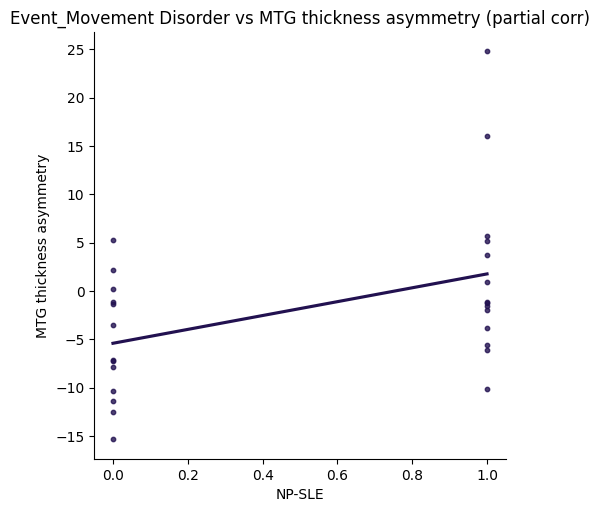

Event_Psychosis vs MTG thickness asymmetry: r = -0.14, p = 0.49
Event_Psychosis vs MTG thickness asymmetry (partial corr): r = -0.18, p = 0.39
total_neurocog vs MTG thickness asymmetry: r = 0.43, p = 0.03
NP-SLE vs MTG thickness asymmetry (partial corr): r = 0.47, p = 0.02


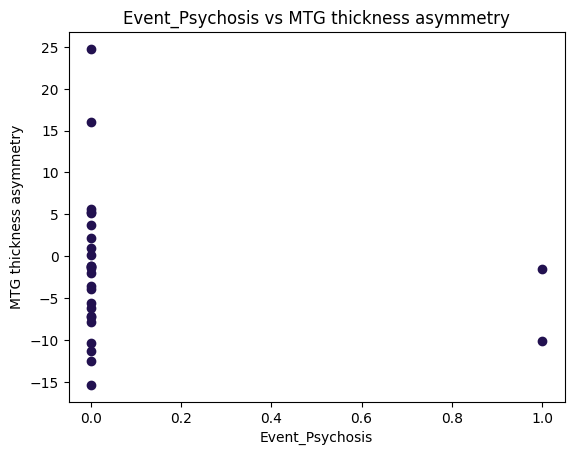

<Figure size 640x480 with 0 Axes>

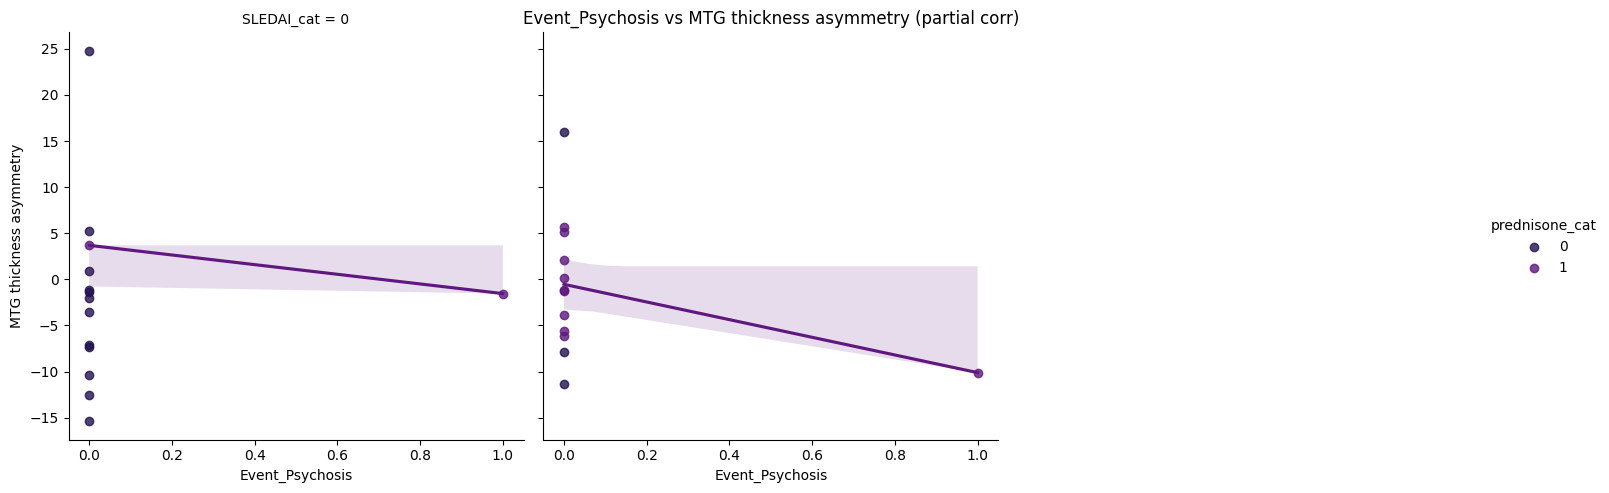

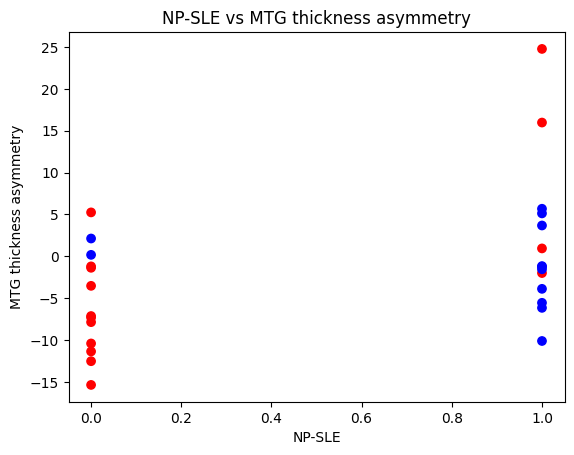

<Figure size 640x480 with 0 Axes>

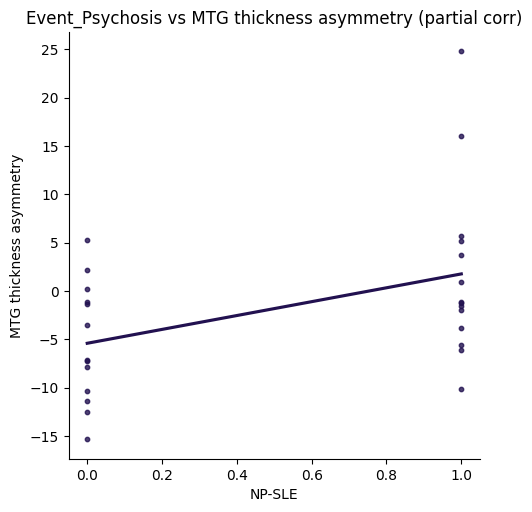

Event_Seizure vs MTG thickness asymmetry: r = 0.38, p = 0.05
Event_Seizure vs MTG thickness asymmetry (partial corr): r = 0.39, p = 0.06
total_neurocog vs MTG thickness asymmetry: r = 0.43, p = 0.03
NP-SLE vs MTG thickness asymmetry (partial corr): r = 0.47, p = 0.02


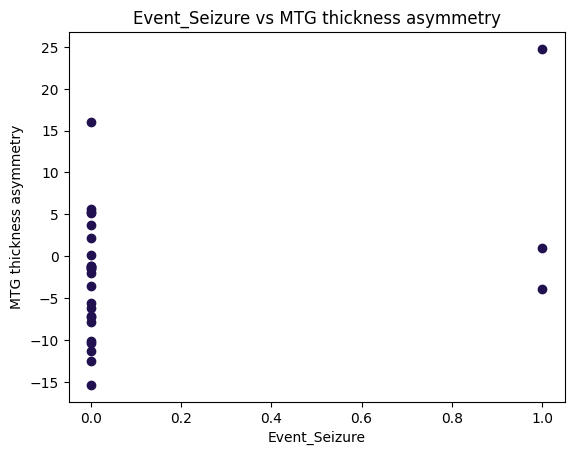

<Figure size 640x480 with 0 Axes>

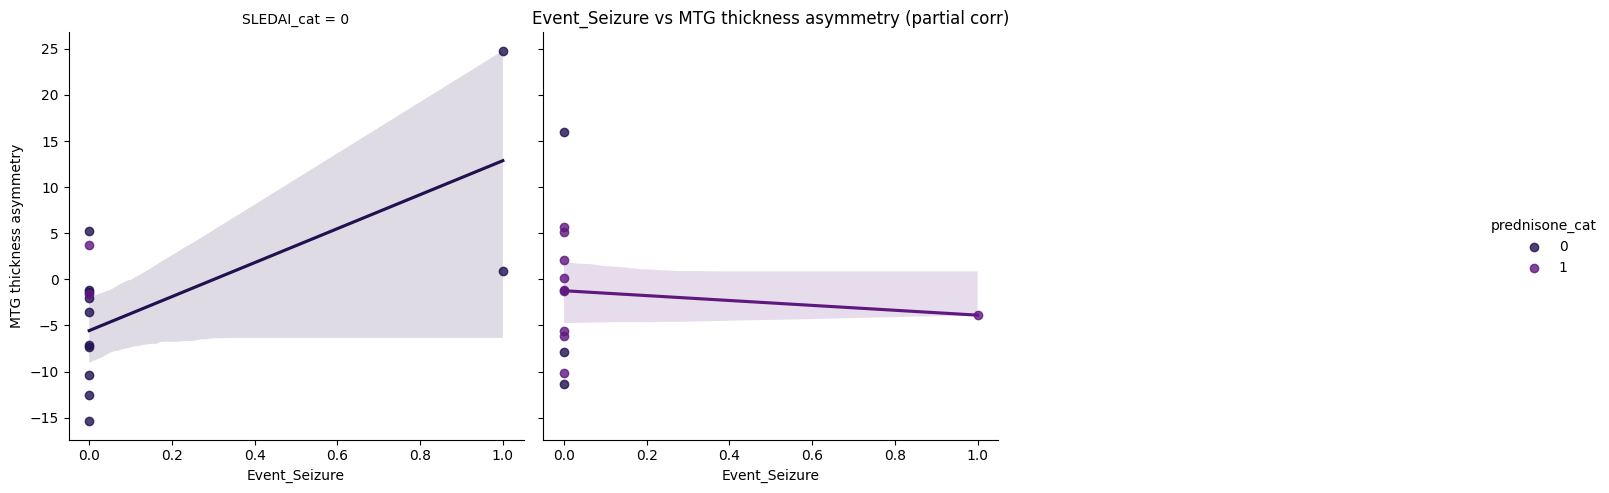

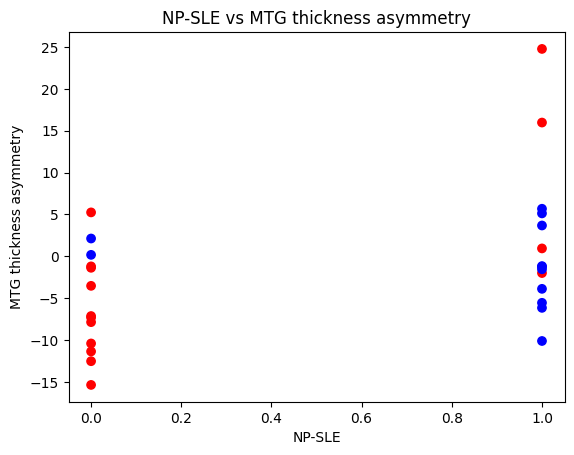

<Figure size 640x480 with 0 Axes>

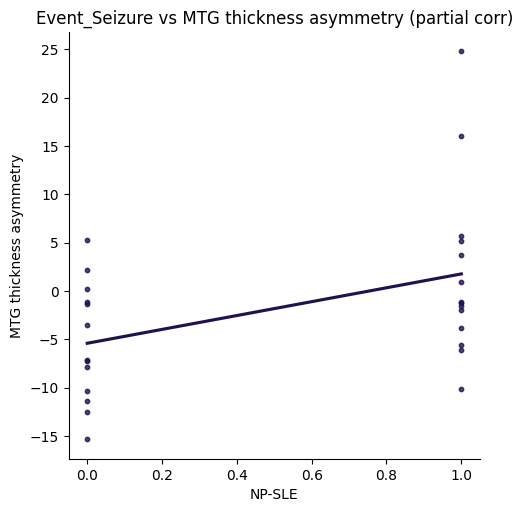

Event_Seizure, ACS, myelitis, CVA vs MTG thickness asymmetry: r = 0.41, p = 0.03
Event_Seizure, ACS, myelitis, CVA vs MTG thickness asymmetry (partial corr): r = 0.48, p = 0.02
total_neurocog vs MTG thickness asymmetry: r = 0.43, p = 0.03
NP-SLE vs MTG thickness asymmetry (partial corr): r = 0.47, p = 0.02


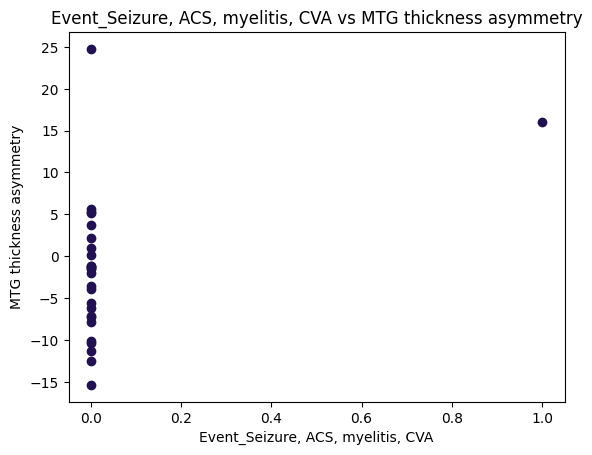

<Figure size 640x480 with 0 Axes>

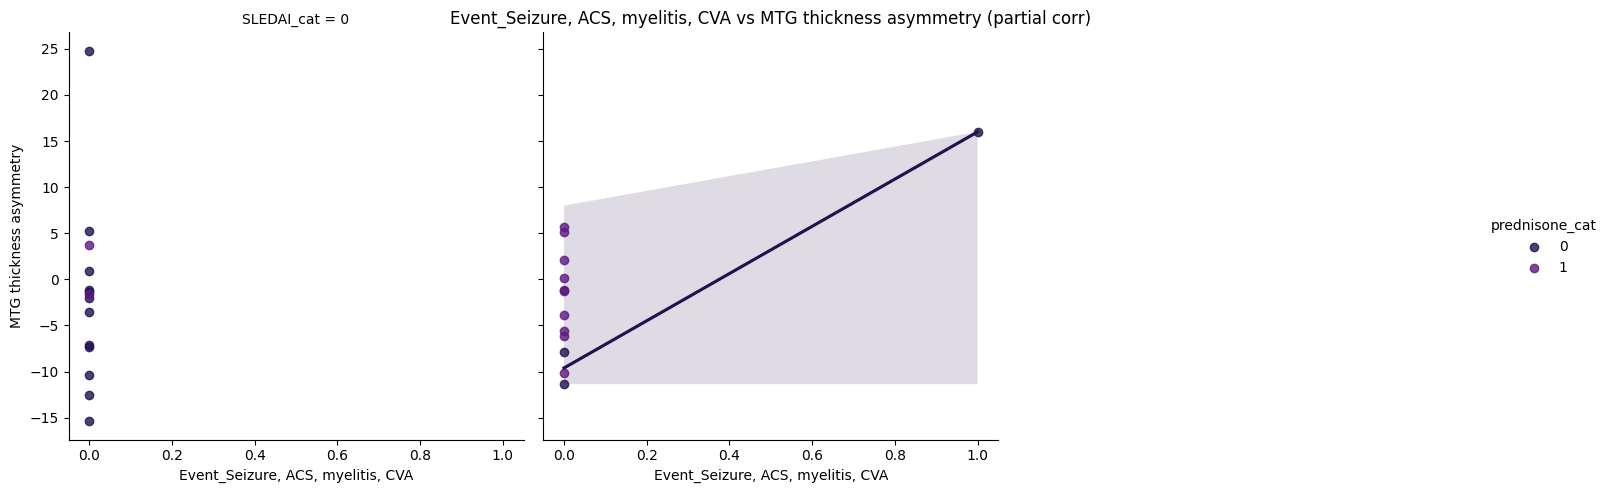

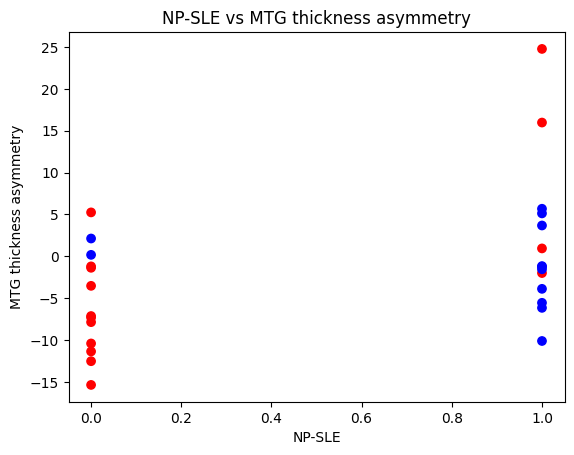

<Figure size 640x480 with 0 Axes>

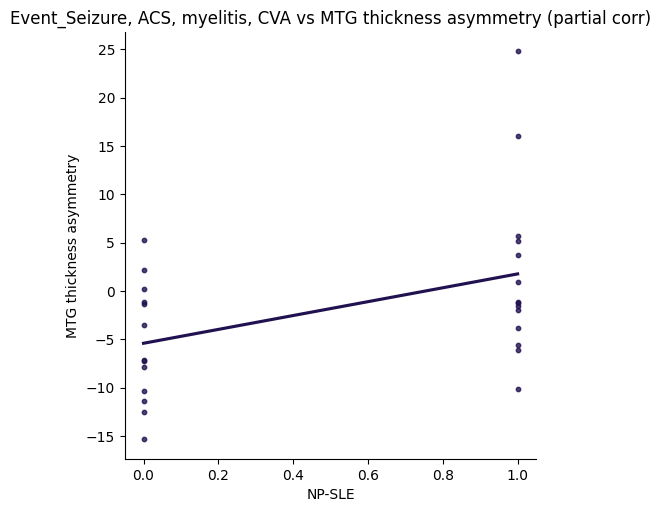

MTG thickness asymmetry vs MTG thickness asymmetry: r = 1.00, p = 0.00
total_neurocog vs MTG thickness asymmetry: r = 0.43, p = 0.03
NP-SLE vs MTG thickness asymmetry (partial corr): r = 0.47, p = 0.02


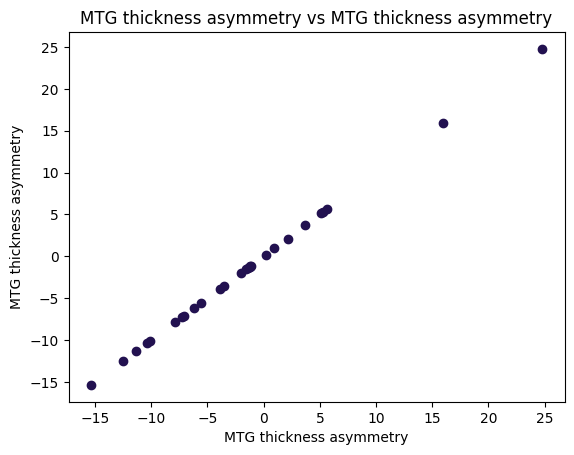

<Figure size 640x480 with 0 Axes>

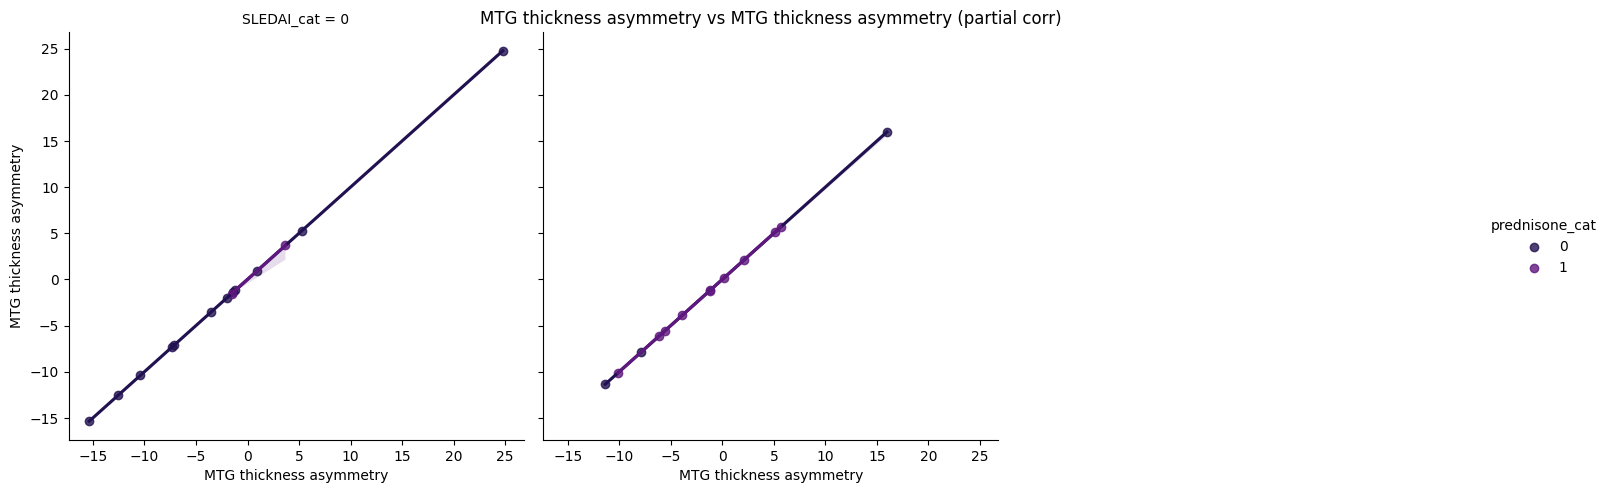

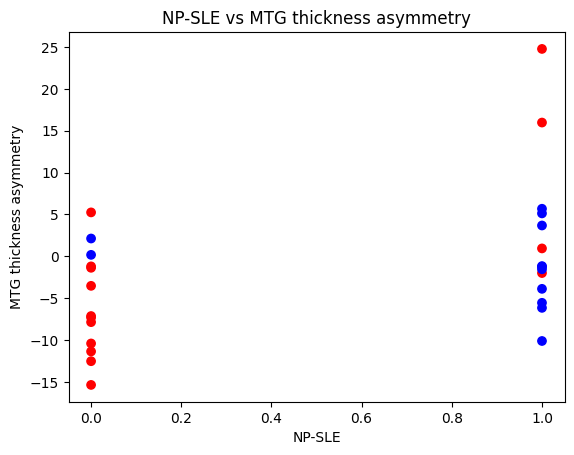

<Figure size 640x480 with 0 Axes>

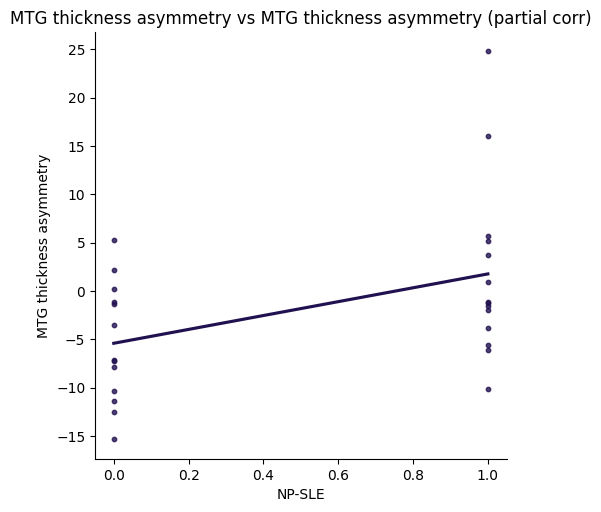

In [11]:
from scipy.stats import pearsonr
import pingouin as pg

df['SLEDAI_cat'] = np.where(df['SLEDAI-2k (at the time of NP event)'] > df['SLEDAI-2k (at the time of NP event)'].median(), 1, 0)
df['prednisone_cat'] = np.where(df['Prednisone  (mg equivalent)'] > df['Prednisone  (mg equivalent)'].median(), 1, 0)
# Define the variables
neurocog_cols = ['Event_CVA', 'Event_Mood abnormalities (depressive)', 'Event_Mood abnormalities (mixed)', 'Event_Movement Disorder', 'Event_Psychosis','Event_Seizure','Event_Seizure, ACS, myelitis, CVA']
lesion_load = 'MTG thickness asymmetry'
prednisone = 'prednisone_cat'
sledai = 'SLEDAI_cat'

# Compute the correlations
for col in neurocog_cols + [lesion_load]:
    # Compute the Pearson correlation between each neurocognitive domain and lesion load
    r, p = pearsonr(df[col], df[lesion_load])
    print(f'{col} vs {lesion_load}: r = {r:.2f}, p = {p:.2f}')

    # Compute the partial correlation adjusting for prednisone and SLEDAI
    if col != lesion_load:
        partial_corr_results = pg.partial_corr(data=df, x=col, y=lesion_load, covar=[prednisone, sledai])
        r_partial, p_partial = partial_corr_results['r'][0], partial_corr_results['p-val'][0]
        print(f'{col} vs {lesion_load} (partial corr): r = {r_partial:.2f}, p = {p_partial:.2f}')
        assert abs(r - r_partial) > 1e-10, f'{col} and {lesion_load} are perfectly correlated'

    # Compute the Pearson correlation between total neurocognitive score and lesion load
    r_total, p_total = pearsonr(df['NP-SLE'], df[lesion_load])
    print(f'total_neurocog vs {lesion_load}: r = {r_total:.2f}, p = {p_total:.2f}')

    # Compute the partial correlation adjusting for prednisone and SLEDAI
    total_partial_results = pg.partial_corr(data=df, x='NP-SLE', y=lesion_load, covar=[prednisone, sledai])
    r_total_partial, p_total_partial = total_partial_results['r'][0], total_partial_results['p-val'][0]
    print(f'NP-SLE vs {lesion_load} (partial corr): r = {r_total_partial:.2f}, p = {p_total_partial:.2f}')


    # Plot the scatter plot
    plt.figure()
    plt.scatter(df[col], df[lesion_load])
    plt.xlabel(col)
    plt.ylabel(lesion_load)
    plt.title(f'{col} vs {lesion_load}')
    plt.show()

    # Plot the partial scatter plot
    plt.figure()
    sns.lmplot(data=df, x=col, y=lesion_load, hue=prednisone, col=sledai, col_wrap=3)
    plt.title(f'{col} vs {lesion_load} (partial corr)')
    plt.show()
    
    colors = ['red' if p == 0 else 'blue' for p in df[prednisone]]
    # Plot the scatter plot of total neurocognitive score vs lesion load
    plt.figure()
    plt.scatter(df['NP-SLE'], df[lesion_load], c=colors)
    plt.xlabel('NP-SLE')
    plt.ylabel(lesion_load)
    plt.title(f'NP-SLE vs {lesion_load}')
    plt.show()

    # Plot the partial scatter plot of total neurocognitive score vs lesion load
    plt.figure()
    sns.lmplot(data=df, x='NP-SLE', y=lesion_load, ci=None, scatter_kws={"s": 10})
    plt.title(f'{col} vs {lesion_load} (partial corr)')
    plt.show()

## SLEDAI

Event_CVA vs SLEDAI-2k (at the time of NP event): r = -0.16, p = 0.41
Event_CVA vs SLEDAI-2k (at the time of NP event) (partial corr): r = -0.28, p = 0.18
Event_Mood abnormalities (depressive) vs SLEDAI-2k (at the time of NP event): r = 0.16, p = 0.42
Event_Mood abnormalities (depressive) vs SLEDAI-2k (at the time of NP event) (partial corr): r = -0.08, p = 0.69
Event_Mood abnormalities (mixed) vs SLEDAI-2k (at the time of NP event): r = 0.22, p = 0.28
Event_Mood abnormalities (mixed) vs SLEDAI-2k (at the time of NP event) (partial corr): r = 0.03, p = 0.90
Event_Movement Disorder vs SLEDAI-2k (at the time of NP event): r = 0.13, p = 0.53
Event_Movement Disorder vs SLEDAI-2k (at the time of NP event) (partial corr): r = -0.08, p = 0.72
Event_Psychosis vs SLEDAI-2k (at the time of NP event): r = 0.17, p = 0.39
Event_Psychosis vs SLEDAI-2k (at the time of NP event) (partial corr): r = -0.02, p = 0.93
Event_Seizure vs SLEDAI-2k (at the time of NP event): r = -0.04, p = 0.85
Event_Seizure 

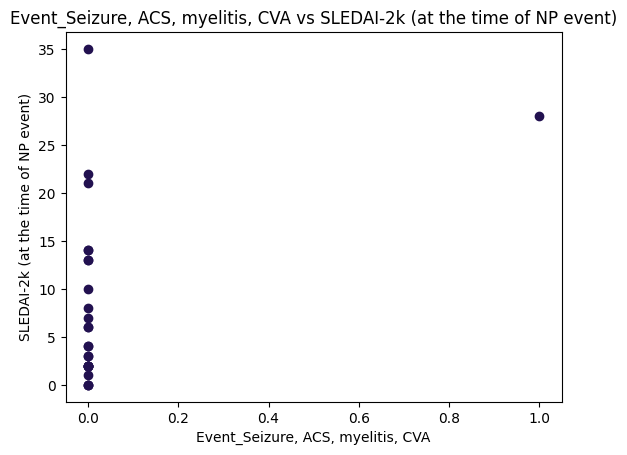

<Figure size 640x480 with 0 Axes>

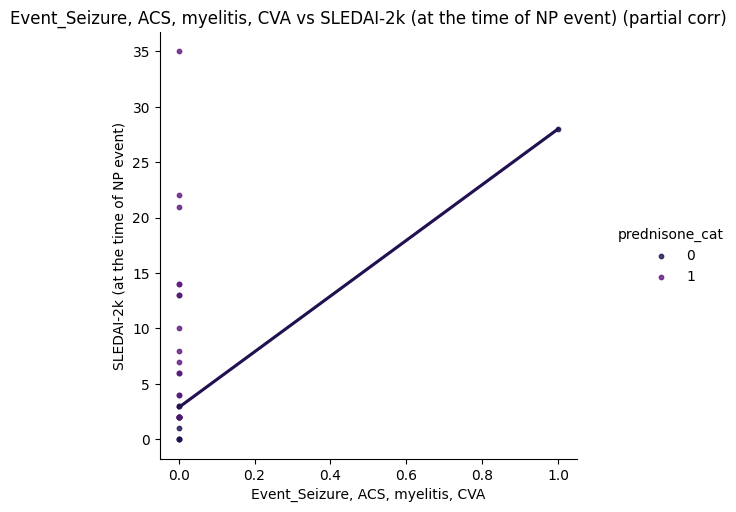

In [13]:
from scipy.stats import spearmanr
import pingouin as pg

#df['SLEDAI_cat'] = np.where(df['SLEDAI-2k (at the time of NP event)'] > df['SLEDAI-2k (at the time of NP event)'].median(), 1, 0)
df['prednisone_cat'] = np.where(df['Prednisone  (mg equivalent)'] > df['Prednisone  (mg equivalent)'].median(), 1, 0)

# Define the variables
neurocog_cols = ['Event_CVA', 'Event_Mood abnormalities (depressive)', 'Event_Mood abnormalities (mixed)', 'Event_Movement Disorder', 'Event_Psychosis','Event_Seizure','Event_Seizure, ACS, myelitis, CVA']
lesion_load = 'IOG volume asymmetry'
prednisone = 'prednisone_cat'
np_sle = 'NP-SLE'
sledai = 'SLEDAI-2k (at the time of NP event)'

## Compute the correlations
for col in neurocog_cols:
    # Compute the Pearson correlation between each neurocognitive domain and SLEDAI
    r, p = spearmanr(df[col], df[sledai])
    print(f'{col} vs {sledai}: r = {r:.2f}, p = {p:.2f}')

    # Compute the partial correlation adjusting for prednisone and NP-SLE
    partial_corr_results = pg.partial_corr(data=df, x=col, y=sledai, covar=[prednisone, np_sle])
    r_partial, p_partial = partial_corr_results['r'][0], partial_corr_results['p-val'][0]
    print(f'{col} vs {sledai} (partial corr): r = {r_partial:.2f}, p = {p_partial:.2f}')
    assert abs(r - r_partial) > 1e-10, f'{col} and {sledai} are perfectly correlated'
    
# Compute the Pearson correlation between MTG thickness and SLEDAI
r_mtg, p_mtg = spearmanr(df[lesion_load], df[sledai])
print(f'{lesion_load} vs {sledai}: r = {r_mtg:.2f}, p = {p_mtg:.2f}')

# Compute the partial correlation adjusting for prednisone and NP-SLE
partial_corr_mtg_results = pg.partial_corr(data=df, x=lesion_load, y=sledai, covar=[prednisone, np_sle])
r_mtg_partial, p_mtg_partial = partial_corr_mtg_results['r'][0], partial_corr_mtg_results['p-val'][0]
print(f'{lesion_load} vs {sledai} (partial corr): r = {r_mtg_partial:.2f}, p = {p_mtg_partial:.2f}')


# Plot the scatter plot
plt.figure()
plt.scatter(df[col], df[sledai])
plt.xlabel(col)
plt.ylabel(sledai)
plt.title(f'{col} vs {sledai}')
plt.show()

# Plot the partial scatter plot
plt.figure()
sns.lmplot(data=df, x=col, y=sledai, hue=prednisone, ci=None, scatter_kws={"s": 10})
plt.title(f'{col} vs {sledai} (partial corr)')
plt.show()


Event_CVA vs SLEDAI-2k (at the time of NP event): r = -0.16, p = 0.41
Event_CVA vs SLEDAI-2k (at the time of NP event) (partial corr): r = -0.28, p = 0.18
Event_Mood abnormalities (depressive) vs SLEDAI-2k (at the time of NP event): r = 0.16, p = 0.42
Event_Mood abnormalities (depressive) vs SLEDAI-2k (at the time of NP event) (partial corr): r = -0.08, p = 0.69
Event_Mood abnormalities (mixed) vs SLEDAI-2k (at the time of NP event): r = 0.22, p = 0.28
Event_Mood abnormalities (mixed) vs SLEDAI-2k (at the time of NP event) (partial corr): r = 0.03, p = 0.90
Event_Movement Disorder vs SLEDAI-2k (at the time of NP event): r = 0.13, p = 0.53
Event_Movement Disorder vs SLEDAI-2k (at the time of NP event) (partial corr): r = -0.08, p = 0.72
Event_Psychosis vs SLEDAI-2k (at the time of NP event): r = 0.17, p = 0.39
Event_Psychosis vs SLEDAI-2k (at the time of NP event) (partial corr): r = -0.02, p = 0.93
Event_Seizure vs SLEDAI-2k (at the time of NP event): r = -0.04, p = 0.85
Event_Seizure 

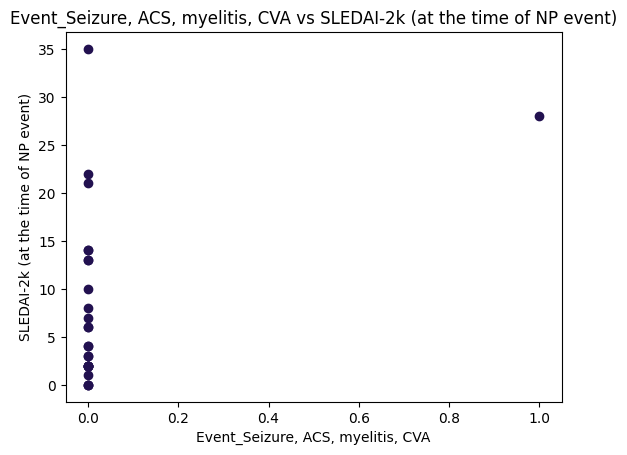

<Figure size 640x480 with 0 Axes>

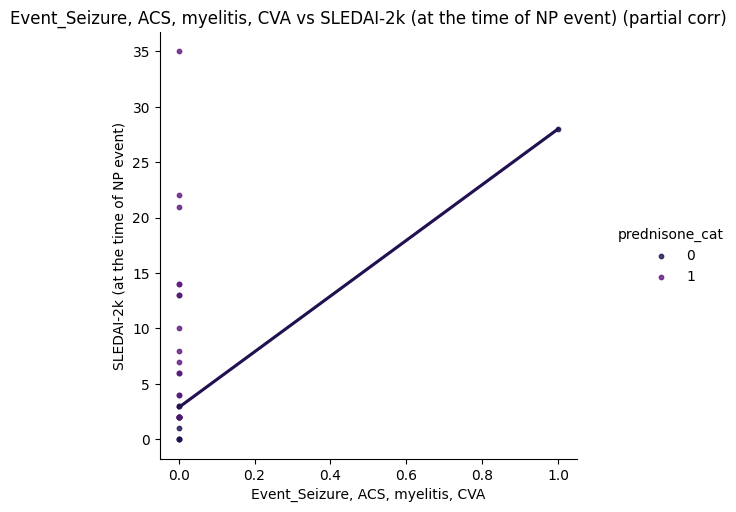

In [15]:
from scipy.stats import spearmanr
import pingouin as pg

#df['SLEDAI_cat'] = np.where(df['SLEDAI-2k (at the time of NP event)'] > df['SLEDAI-2k (at the time of NP event)'].median(), 1, 0)
df['prednisone_cat'] = np.where(df['Prednisone  (mg equivalent)'] > df['Prednisone  (mg equivalent)'].median(), 1, 0)

# Define the variables
neurocog_cols = ['Event_CVA', 'Event_Mood abnormalities (depressive)', 'Event_Mood abnormalities (mixed)', 'Event_Movement Disorder', 'Event_Psychosis','Event_Seizure','Event_Seizure, ACS, myelitis, CVA']
lesion_load = 'Calc total volume %'
prednisone = 'prednisone_cat'
np_sle = 'NP-SLE'
sledai = 'SLEDAI-2k (at the time of NP event)'

## Compute the correlations
for col in neurocog_cols:
    # Compute the Pearson correlation between each neurocognitive domain and SLEDAI
    r, p = spearmanr(df[col], df[sledai])
    print(f'{col} vs {sledai}: r = {r:.2f}, p = {p:.2f}')

    # Compute the partial correlation adjusting for prednisone and NP-SLE
    partial_corr_results = pg.partial_corr(data=df, x=col, y=sledai, covar=[prednisone, np_sle])
    r_partial, p_partial = partial_corr_results['r'][0], partial_corr_results['p-val'][0]
    print(f'{col} vs {sledai} (partial corr): r = {r_partial:.2f}, p = {p_partial:.2f}')
    assert abs(r - r_partial) > 1e-10, f'{col} and {sledai} are perfectly correlated'
    
# Compute the Pearson correlation between MTG thickness and SLEDAI
r_mtg, p_mtg = spearmanr(df[lesion_load], df[sledai])
print(f'{lesion_load} vs {sledai}: r = {r_mtg:.2f}, p = {p_mtg:.2f}')

# Compute the partial correlation adjusting for prednisone and NP-SLE
partial_corr_mtg_results = pg.partial_corr(data=df, x=lesion_load, y=sledai, covar=[prednisone, np_sle])
r_mtg_partial, p_mtg_partial = partial_corr_mtg_results['r'][0], partial_corr_mtg_results['p-val'][0]
print(f'{lesion_load} vs {sledai} (partial corr): r = {r_mtg_partial:.2f}, p = {p_mtg_partial:.2f}')


# Plot the scatter plot
plt.figure()
plt.scatter(df[col], df[sledai])
plt.xlabel(col)
plt.ylabel(sledai)
plt.title(f'{col} vs {sledai}')
plt.show()

# Plot the partial scatter plot
plt.figure()
sns.lmplot(data=df, x=col, y=sledai, hue=prednisone, ci=None, scatter_kws={"s": 10})
plt.title(f'{col} vs {sledai} (partial corr)')
plt.show()


Event_CVA vs SLEDAI-2k (at the time of NP event): r = -0.16, p = 0.41
Event_CVA vs SLEDAI-2k (at the time of NP event) (partial corr): r = -0.28, p = 0.18
Event_Mood abnormalities (depressive) vs SLEDAI-2k (at the time of NP event): r = 0.16, p = 0.42
Event_Mood abnormalities (depressive) vs SLEDAI-2k (at the time of NP event) (partial corr): r = -0.08, p = 0.69
Event_Mood abnormalities (mixed) vs SLEDAI-2k (at the time of NP event): r = 0.22, p = 0.28
Event_Mood abnormalities (mixed) vs SLEDAI-2k (at the time of NP event) (partial corr): r = 0.03, p = 0.90
Event_Movement Disorder vs SLEDAI-2k (at the time of NP event): r = 0.13, p = 0.53
Event_Movement Disorder vs SLEDAI-2k (at the time of NP event) (partial corr): r = -0.08, p = 0.72
Event_Psychosis vs SLEDAI-2k (at the time of NP event): r = 0.17, p = 0.39
Event_Psychosis vs SLEDAI-2k (at the time of NP event) (partial corr): r = -0.02, p = 0.93
Event_Seizure vs SLEDAI-2k (at the time of NP event): r = -0.04, p = 0.85
Event_Seizure 

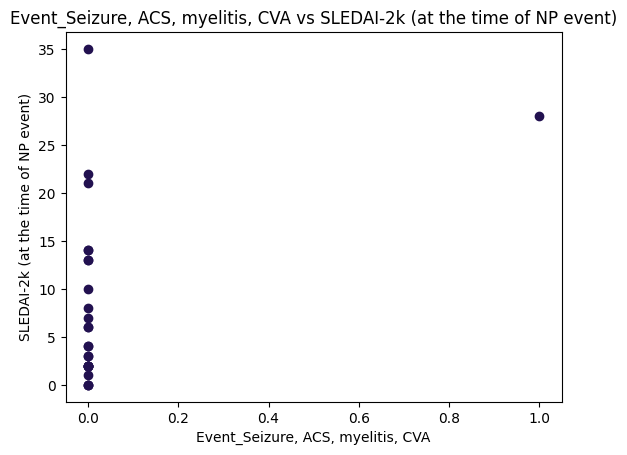

<Figure size 640x480 with 0 Axes>

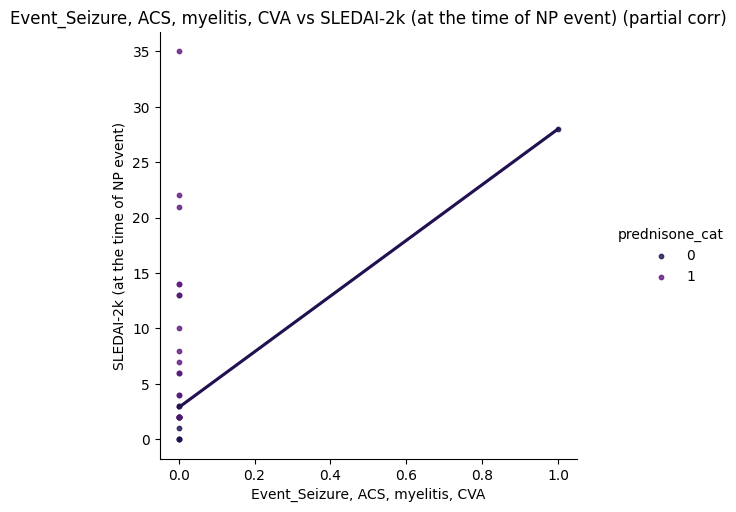

In [16]:
from scipy.stats import spearmanr
import pingouin as pg

#df['SLEDAI_cat'] = np.where(df['SLEDAI-2k (at the time of NP event)'] > df['SLEDAI-2k (at the time of NP event)'].median(), 1, 0)
df['prednisone_cat'] = np.where(df['Prednisone  (mg equivalent)'] > df['Prednisone  (mg equivalent)'].median(), 1, 0)

# Define the variables
neurocog_cols = ['Event_CVA', 'Event_Mood abnormalities (depressive)', 'Event_Mood abnormalities (mixed)', 'Event_Movement Disorder', 'Event_Psychosis','Event_Seizure','Event_Seizure, ACS, myelitis, CVA']
lesion_load = 'Amygdala total volume %'
prednisone = 'prednisone_cat'
np_sle = 'NP-SLE'
sledai = 'SLEDAI-2k (at the time of NP event)'

## Compute the correlations
for col in neurocog_cols:
    # Compute the Pearson correlation between each neurocognitive domain and SLEDAI
    r, p = spearmanr(df[col], df[sledai])
    print(f'{col} vs {sledai}: r = {r:.2f}, p = {p:.2f}')

    # Compute the partial correlation adjusting for prednisone and NP-SLE
    partial_corr_results = pg.partial_corr(data=df, x=col, y=sledai, covar=[prednisone, np_sle])
    r_partial, p_partial = partial_corr_results['r'][0], partial_corr_results['p-val'][0]
    print(f'{col} vs {sledai} (partial corr): r = {r_partial:.2f}, p = {p_partial:.2f}')
    assert abs(r - r_partial) > 1e-10, f'{col} and {sledai} are perfectly correlated'
    
# Compute the Pearson correlation between MTG thickness and SLEDAI
r_mtg, p_mtg = spearmanr(df[lesion_load], df[sledai])
print(f'{lesion_load} vs {sledai}: r = {r_mtg:.2f}, p = {p_mtg:.2f}')

# Compute the partial correlation adjusting for prednisone and NP-SLE
partial_corr_mtg_results = pg.partial_corr(data=df, x=lesion_load, y=sledai, covar=[prednisone, np_sle])
r_mtg_partial, p_mtg_partial = partial_corr_mtg_results['r'][0], partial_corr_mtg_results['p-val'][0]
print(f'{lesion_load} vs {sledai} (partial corr): r = {r_mtg_partial:.2f}, p = {p_mtg_partial:.2f}')


# Plot the scatter plot
plt.figure()
plt.scatter(df[col], df[sledai])
plt.xlabel(col)
plt.ylabel(sledai)
plt.title(f'{col} vs {sledai}')
plt.show()

# Plot the partial scatter plot
plt.figure()
sns.lmplot(data=df, x=col, y=sledai, hue=prednisone, ci=None, scatter_kws={"s": 10})
plt.title(f'{col} vs {sledai} (partial corr)')
plt.show()


Event_CVA vs SLEDAI-2k (at the time of NP event): r = -0.16, p = 0.41
Event_CVA vs SLEDAI-2k (at the time of NP event) (partial corr): r = -0.28, p = 0.18
Event_Mood abnormalities (depressive) vs SLEDAI-2k (at the time of NP event): r = 0.16, p = 0.42
Event_Mood abnormalities (depressive) vs SLEDAI-2k (at the time of NP event) (partial corr): r = -0.08, p = 0.69
Event_Mood abnormalities (mixed) vs SLEDAI-2k (at the time of NP event): r = 0.22, p = 0.28
Event_Mood abnormalities (mixed) vs SLEDAI-2k (at the time of NP event) (partial corr): r = 0.03, p = 0.90
Event_Movement Disorder vs SLEDAI-2k (at the time of NP event): r = 0.13, p = 0.53
Event_Movement Disorder vs SLEDAI-2k (at the time of NP event) (partial corr): r = -0.08, p = 0.72
Event_Psychosis vs SLEDAI-2k (at the time of NP event): r = 0.17, p = 0.39
Event_Psychosis vs SLEDAI-2k (at the time of NP event) (partial corr): r = -0.02, p = 0.93
Event_Seizure vs SLEDAI-2k (at the time of NP event): r = -0.04, p = 0.85
Event_Seizure 

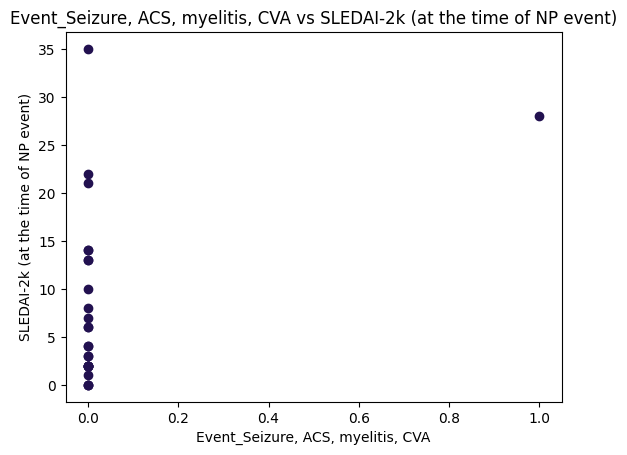

<Figure size 640x480 with 0 Axes>

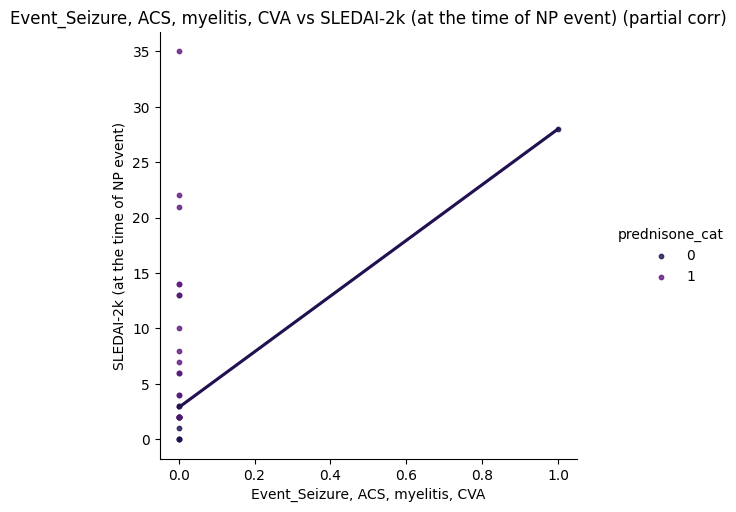

In [17]:
from scipy.stats import spearmanr
import pingouin as pg

#df['SLEDAI_cat'] = np.where(df['SLEDAI-2k (at the time of NP event)'] > df['SLEDAI-2k (at the time of NP event)'].median(), 1, 0)
df['prednisone_cat'] = np.where(df['Prednisone  (mg equivalent)'] > df['Prednisone  (mg equivalent)'].median(), 1, 0)

# Define the variables
neurocog_cols = ['Event_CVA', 'Event_Mood abnormalities (depressive)', 'Event_Mood abnormalities (mixed)', 'Event_Movement Disorder', 'Event_Psychosis','Event_Seizure','Event_Seizure, ACS, myelitis, CVA']
lesion_load = 'Amygdala left volume %'
prednisone = 'prednisone_cat'
np_sle = 'NP-SLE'
sledai = 'SLEDAI-2k (at the time of NP event)'

## Compute the correlations
for col in neurocog_cols:
    # Compute the Pearson correlation between each neurocognitive domain and SLEDAI
    r, p = spearmanr(df[col], df[sledai])
    print(f'{col} vs {sledai}: r = {r:.2f}, p = {p:.2f}')

    # Compute the partial correlation adjusting for prednisone and NP-SLE
    partial_corr_results = pg.partial_corr(data=df, x=col, y=sledai, covar=[prednisone, np_sle])
    r_partial, p_partial = partial_corr_results['r'][0], partial_corr_results['p-val'][0]
    print(f'{col} vs {sledai} (partial corr): r = {r_partial:.2f}, p = {p_partial:.2f}')
    assert abs(r - r_partial) > 1e-10, f'{col} and {sledai} are perfectly correlated'
    
# Compute the Pearson correlation between MTG thickness and SLEDAI
r_mtg, p_mtg = spearmanr(df[lesion_load], df[sledai])
print(f'{lesion_load} vs {sledai}: r = {r_mtg:.2f}, p = {p_mtg:.2f}')

# Compute the partial correlation adjusting for prednisone and NP-SLE
partial_corr_mtg_results = pg.partial_corr(data=df, x=lesion_load, y=sledai, covar=[prednisone, np_sle])
r_mtg_partial, p_mtg_partial = partial_corr_mtg_results['r'][0], partial_corr_mtg_results['p-val'][0]
print(f'{lesion_load} vs {sledai} (partial corr): r = {r_mtg_partial:.2f}, p = {p_mtg_partial:.2f}')


# Plot the scatter plot
plt.figure()
plt.scatter(df[col], df[sledai])
plt.xlabel(col)
plt.ylabel(sledai)
plt.title(f'{col} vs {sledai}')
plt.show()

# Plot the partial scatter plot
plt.figure()
sns.lmplot(data=df, x=col, y=sledai, hue=prednisone, ci=None, scatter_kws={"s": 10})
plt.title(f'{col} vs {sledai} (partial corr)')
plt.show()


Event_CVA vs SLEDAI-2k (at the time of NP event): r = -0.16, p = 0.41
Event_CVA vs SLEDAI-2k (at the time of NP event) (partial corr): r = -0.28, p = 0.18
Event_Mood abnormalities (depressive) vs SLEDAI-2k (at the time of NP event): r = 0.16, p = 0.42
Event_Mood abnormalities (depressive) vs SLEDAI-2k (at the time of NP event) (partial corr): r = -0.08, p = 0.69
Event_Mood abnormalities (mixed) vs SLEDAI-2k (at the time of NP event): r = 0.22, p = 0.28
Event_Mood abnormalities (mixed) vs SLEDAI-2k (at the time of NP event) (partial corr): r = 0.03, p = 0.90
Event_Movement Disorder vs SLEDAI-2k (at the time of NP event): r = 0.13, p = 0.53
Event_Movement Disorder vs SLEDAI-2k (at the time of NP event) (partial corr): r = -0.08, p = 0.72
Event_Psychosis vs SLEDAI-2k (at the time of NP event): r = 0.17, p = 0.39
Event_Psychosis vs SLEDAI-2k (at the time of NP event) (partial corr): r = -0.02, p = 0.93
Event_Seizure vs SLEDAI-2k (at the time of NP event): r = -0.04, p = 0.85
Event_Seizure 

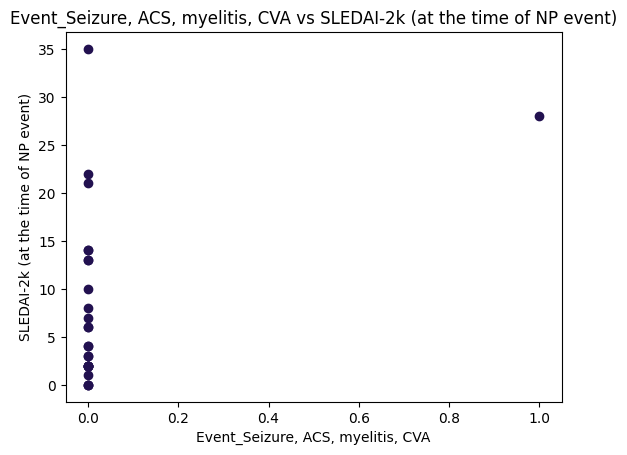

<Figure size 640x480 with 0 Axes>

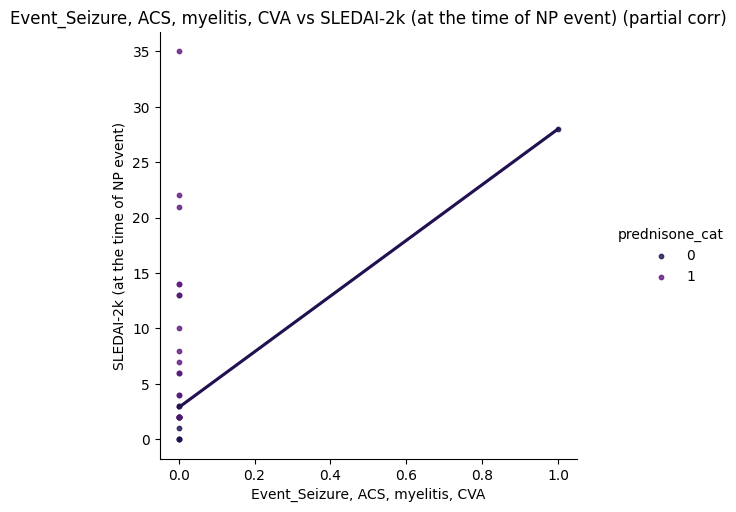

In [18]:
from scipy.stats import spearmanr
import pingouin as pg

#df['SLEDAI_cat'] = np.where(df['SLEDAI-2k (at the time of NP event)'] > df['SLEDAI-2k (at the time of NP event)'].median(), 1, 0)
df['prednisone_cat'] = np.where(df['Prednisone  (mg equivalent)'] > df['Prednisone  (mg equivalent)'].median(), 1, 0)

# Define the variables
neurocog_cols = ['Event_CVA', 'Event_Mood abnormalities (depressive)', 'Event_Mood abnormalities (mixed)', 'Event_Movement Disorder', 'Event_Psychosis','Event_Seizure','Event_Seizure, ACS, myelitis, CVA']
lesion_load = 'IOG right volume %'
prednisone = 'prednisone_cat'
np_sle = 'NP-SLE'
sledai = 'SLEDAI-2k (at the time of NP event)'

## Compute the correlations
for col in neurocog_cols:
    # Compute the Pearson correlation between each neurocognitive domain and SLEDAI
    r, p = spearmanr(df[col], df[sledai])
    print(f'{col} vs {sledai}: r = {r:.2f}, p = {p:.2f}')

    # Compute the partial correlation adjusting for prednisone and NP-SLE
    partial_corr_results = pg.partial_corr(data=df, x=col, y=sledai, covar=[prednisone, np_sle])
    r_partial, p_partial = partial_corr_results['r'][0], partial_corr_results['p-val'][0]
    print(f'{col} vs {sledai} (partial corr): r = {r_partial:.2f}, p = {p_partial:.2f}')
    assert abs(r - r_partial) > 1e-10, f'{col} and {sledai} are perfectly correlated'
    
# Compute the Pearson correlation between MTG thickness and SLEDAI
r_mtg, p_mtg = spearmanr(df[lesion_load], df[sledai])
print(f'{lesion_load} vs {sledai}: r = {r_mtg:.2f}, p = {p_mtg:.2f}')

# Compute the partial correlation adjusting for prednisone and NP-SLE
partial_corr_mtg_results = pg.partial_corr(data=df, x=lesion_load, y=sledai, covar=[prednisone, np_sle])
r_mtg_partial, p_mtg_partial = partial_corr_mtg_results['r'][0], partial_corr_mtg_results['p-val'][0]
print(f'{lesion_load} vs {sledai} (partial corr): r = {r_mtg_partial:.2f}, p = {p_mtg_partial:.2f}')


# Plot the scatter plot
plt.figure()
plt.scatter(df[col], df[sledai])
plt.xlabel(col)
plt.ylabel(sledai)
plt.title(f'{col} vs {sledai}')
plt.show()

# Plot the partial scatter plot
plt.figure()
sns.lmplot(data=df, x=col, y=sledai, hue=prednisone, ci=None, scatter_kws={"s": 10})
plt.title(f'{col} vs {sledai} (partial corr)')
plt.show()


Event_CVA vs SLEDAI-2k (at the time of NP event): r = -0.16, p = 0.41
Event_CVA vs SLEDAI-2k (at the time of NP event) (partial corr): r = -0.28, p = 0.18
Event_Mood abnormalities (depressive) vs SLEDAI-2k (at the time of NP event): r = 0.16, p = 0.42
Event_Mood abnormalities (depressive) vs SLEDAI-2k (at the time of NP event) (partial corr): r = -0.08, p = 0.69
Event_Mood abnormalities (mixed) vs SLEDAI-2k (at the time of NP event): r = 0.22, p = 0.28
Event_Mood abnormalities (mixed) vs SLEDAI-2k (at the time of NP event) (partial corr): r = 0.03, p = 0.90
Event_Movement Disorder vs SLEDAI-2k (at the time of NP event): r = 0.13, p = 0.53
Event_Movement Disorder vs SLEDAI-2k (at the time of NP event) (partial corr): r = -0.08, p = 0.72
Event_Psychosis vs SLEDAI-2k (at the time of NP event): r = 0.17, p = 0.39
Event_Psychosis vs SLEDAI-2k (at the time of NP event) (partial corr): r = -0.02, p = 0.93
Event_Seizure vs SLEDAI-2k (at the time of NP event): r = -0.04, p = 0.85
Event_Seizure 

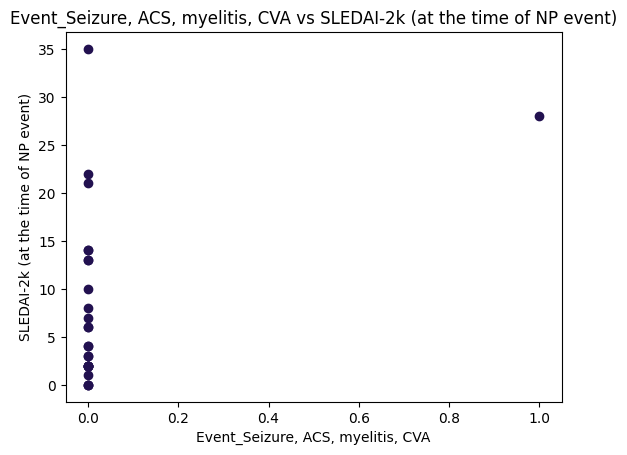

<Figure size 640x480 with 0 Axes>

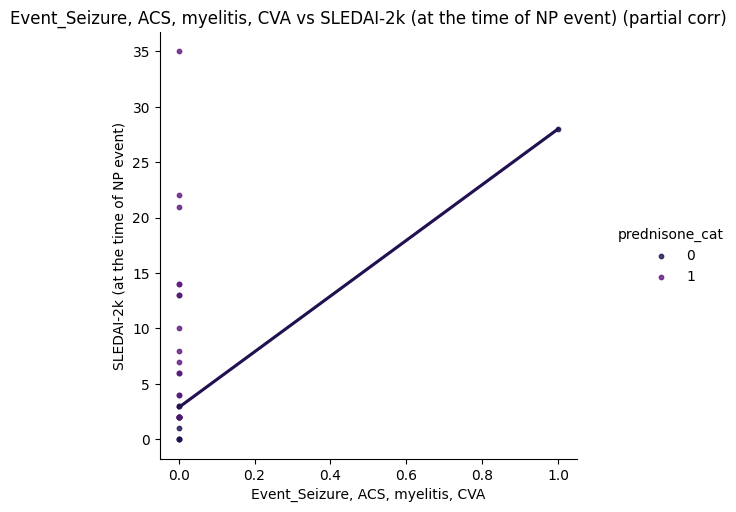

In [6]:
from scipy.stats import spearmanr
import pingouin as pg

#df['SLEDAI_cat'] = np.where(df['SLEDAI-2k (at the time of NP event)'] > df['SLEDAI-2k (at the time of NP event)'].median(), 1, 0)
df['prednisone_cat'] = np.where(df['Prednisone  (mg equivalent)'] > df['Prednisone  (mg equivalent)'].median(), 1, 0)

# Define the variables
neurocog_cols = ['Event_CVA', 'Event_Mood abnormalities (depressive)', 'Event_Mood abnormalities (mixed)', 'Event_Movement Disorder', 'Event_Psychosis','Event_Seizure','Event_Seizure, ACS, myelitis, CVA']
lesion_load = 'PHG total thickness norm.'
prednisone = 'prednisone_cat'
np_sle = 'NP-SLE'
sledai = 'SLEDAI-2k (at the time of NP event)'

## Compute the correlations
for col in neurocog_cols:
    # Compute the Pearson correlation between each neurocognitive domain and SLEDAI
    r, p = spearmanr(df[col], df[sledai])
    print(f'{col} vs {sledai}: r = {r:.2f}, p = {p:.2f}')

    # Compute the partial correlation adjusting for prednisone and NP-SLE
    partial_corr_results = pg.partial_corr(data=df, x=col, y=sledai, covar=[prednisone, np_sle])
    r_partial, p_partial = partial_corr_results['r'][0], partial_corr_results['p-val'][0]
    print(f'{col} vs {sledai} (partial corr): r = {r_partial:.2f}, p = {p_partial:.2f}')
    assert abs(r - r_partial) > 1e-10, f'{col} and {sledai} are perfectly correlated'
    
# Compute the Pearson correlation between MTG thickness and SLEDAI
r_mtg, p_mtg = spearmanr(df[lesion_load], df[sledai])
print(f'{lesion_load} vs {sledai}: r = {r_mtg:.2f}, p = {p_mtg:.2f}')

# Compute the partial correlation adjusting for prednisone and NP-SLE
partial_corr_mtg_results = pg.partial_corr(data=df, x=lesion_load, y=sledai, covar=[prednisone, np_sle])
r_mtg_partial, p_mtg_partial = partial_corr_mtg_results['r'][0], partial_corr_mtg_results['p-val'][0]
print(f'{lesion_load} vs {sledai} (partial corr): r = {r_mtg_partial:.2f}, p = {p_mtg_partial:.2f}')


# Plot the scatter plot
plt.figure()
plt.scatter(df[col], df[sledai])
plt.xlabel(col)
plt.ylabel(sledai)
plt.title(f'{col} vs {sledai}')
plt.show()

# Plot the partial scatter plot
plt.figure()
sns.lmplot(data=df, x=col, y=sledai, hue=prednisone, ci=None, scatter_kws={"s": 10})
plt.title(f'{col} vs {sledai} (partial corr)')
plt.show()


Event_CVA vs SLEDAI-2k (at the time of NP event): r = -0.16, p = 0.41
Event_CVA vs SLEDAI-2k (at the time of NP event) (partial corr): r = -0.28, p = 0.18
Event_Mood abnormalities (depressive) vs SLEDAI-2k (at the time of NP event): r = 0.16, p = 0.42
Event_Mood abnormalities (depressive) vs SLEDAI-2k (at the time of NP event) (partial corr): r = -0.08, p = 0.69
Event_Mood abnormalities (mixed) vs SLEDAI-2k (at the time of NP event): r = 0.22, p = 0.28
Event_Mood abnormalities (mixed) vs SLEDAI-2k (at the time of NP event) (partial corr): r = 0.03, p = 0.90
Event_Movement Disorder vs SLEDAI-2k (at the time of NP event): r = 0.13, p = 0.53
Event_Movement Disorder vs SLEDAI-2k (at the time of NP event) (partial corr): r = -0.08, p = 0.72
Event_Psychosis vs SLEDAI-2k (at the time of NP event): r = 0.17, p = 0.39
Event_Psychosis vs SLEDAI-2k (at the time of NP event) (partial corr): r = -0.02, p = 0.93
Event_Seizure vs SLEDAI-2k (at the time of NP event): r = -0.04, p = 0.85
Event_Seizure 

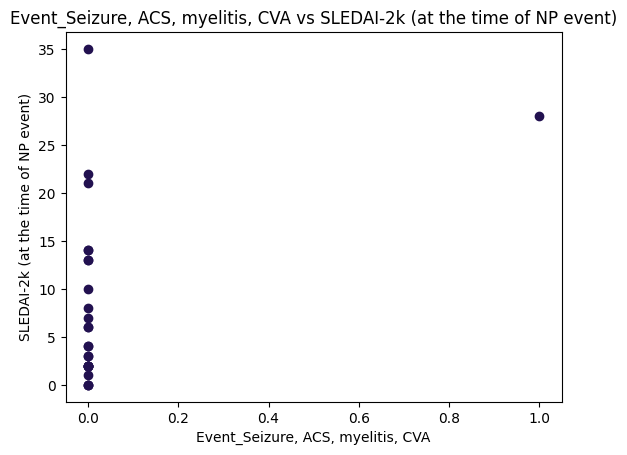

<Figure size 640x480 with 0 Axes>

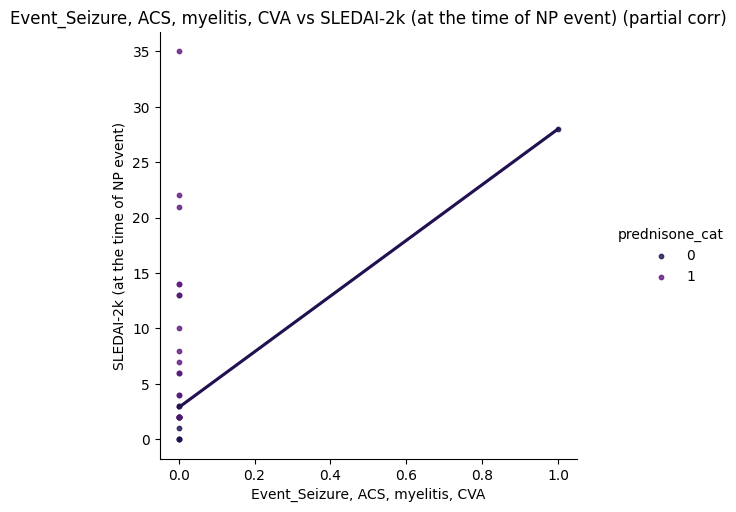

In [7]:
from scipy.stats import spearmanr
import pingouin as pg

#df['SLEDAI_cat'] = np.where(df['SLEDAI-2k (at the time of NP event)'] > df['SLEDAI-2k (at the time of NP event)'].median(), 1, 0)
df['prednisone_cat'] = np.where(df['Prednisone  (mg equivalent)'] > df['Prednisone  (mg equivalent)'].median(), 1, 0)

# Define the variables
neurocog_cols = ['Event_CVA', 'Event_Mood abnormalities (depressive)', 'Event_Mood abnormalities (mixed)', 'Event_Movement Disorder', 'Event_Psychosis','Event_Seizure','Event_Seizure, ACS, myelitis, CVA']
lesion_load = '4th Ventricle volume %'
prednisone = 'prednisone_cat'
np_sle = 'NP-SLE'
sledai = 'SLEDAI-2k (at the time of NP event)'

## Compute the correlations
for col in neurocog_cols:
    # Compute the Pearson correlation between each neurocognitive domain and SLEDAI
    r, p = spearmanr(df[col], df[sledai])
    print(f'{col} vs {sledai}: r = {r:.2f}, p = {p:.2f}')

    # Compute the partial correlation adjusting for prednisone and NP-SLE
    partial_corr_results = pg.partial_corr(data=df, x=col, y=sledai, covar=[prednisone, np_sle])
    r_partial, p_partial = partial_corr_results['r'][0], partial_corr_results['p-val'][0]
    print(f'{col} vs {sledai} (partial corr): r = {r_partial:.2f}, p = {p_partial:.2f}')
    assert abs(r - r_partial) > 1e-10, f'{col} and {sledai} are perfectly correlated'
    
# Compute the Pearson correlation between MTG thickness and SLEDAI
r_mtg, p_mtg = spearmanr(df[lesion_load], df[sledai])
print(f'{lesion_load} vs {sledai}: r = {r_mtg:.2f}, p = {p_mtg:.2f}')

# Compute the partial correlation adjusting for prednisone and NP-SLE
partial_corr_mtg_results = pg.partial_corr(data=df, x=lesion_load, y=sledai, covar=[prednisone, np_sle])
r_mtg_partial, p_mtg_partial = partial_corr_mtg_results['r'][0], partial_corr_mtg_results['p-val'][0]
print(f'{lesion_load} vs {sledai} (partial corr): r = {r_mtg_partial:.2f}, p = {p_mtg_partial:.2f}')


# Plot the scatter plot
plt.figure()
plt.scatter(df[col], df[sledai])
plt.xlabel(col)
plt.ylabel(sledai)
plt.title(f'{col} vs {sledai}')
plt.show()

# Plot the partial scatter plot
plt.figure()
sns.lmplot(data=df, x=col, y=sledai, hue=prednisone, ci=None, scatter_kws={"s": 10})
plt.title(f'{col} vs {sledai} (partial corr)')
plt.show()
